# 1. Loading Data and Early Explorations

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from helpers import feature_importance, pearson_correlation, transform_2D, seed_everything, scaler
from calculate import ml_predict, val_score, calc_average
from nn import create_model, train_model_mae, train_model_rmse, load_model

In [291]:
# specify image save directory
image_directory = '/link/to/your/save/directory'

In [292]:
# Set fonts to Arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [293]:
# Seed all parameters to ensure repeatability
seed_everything()

In [294]:
# Read in our data file
df = pd.read_csv('CO Dimerization Training.csv')

In [297]:
# Drop adsorbates 1 and 2 from our feature space as they will not participate in training
df = df.drop(columns = ['Adsorbate 1', 'Adsorbate 2'])

# 2. Creating some Noise

In [304]:
final_df = df

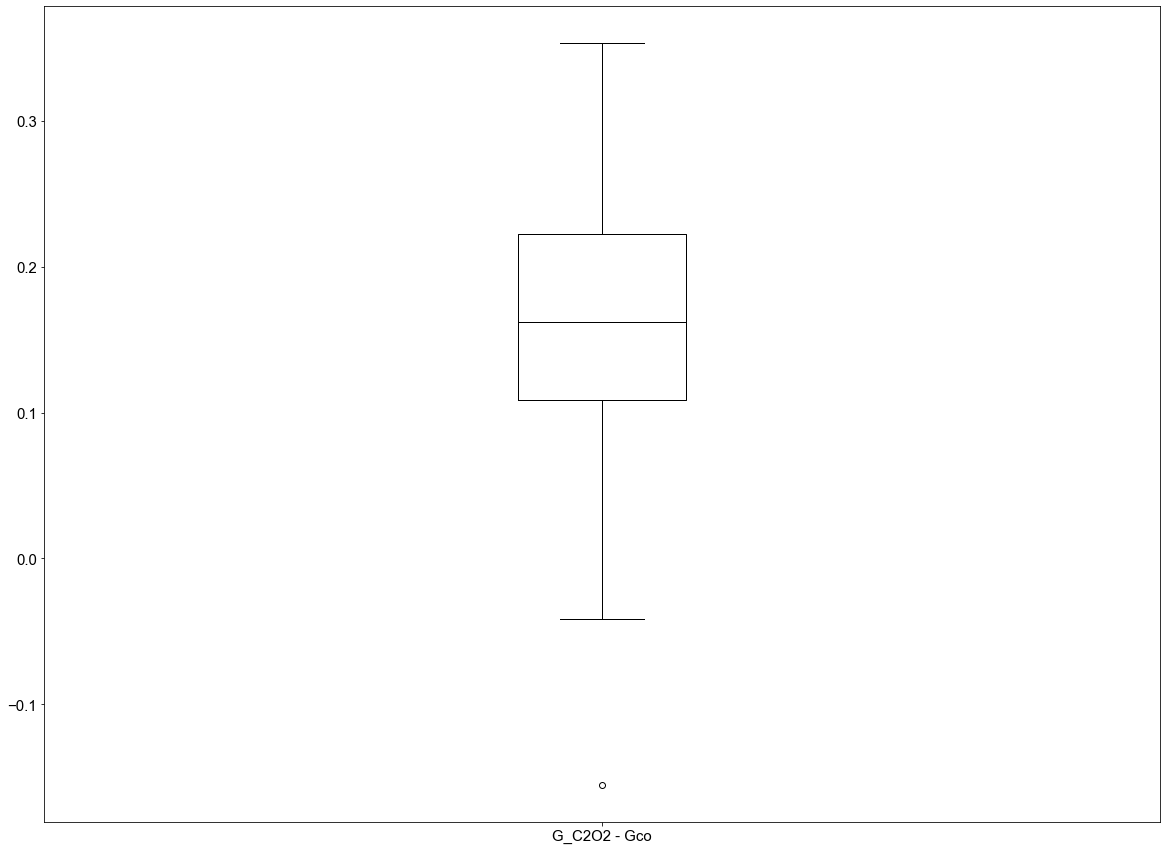

In [305]:
# Boxplot of the target feature
final_df.boxplot(color=dict(boxes='black', whiskers='black', medians='black', caps='black'), 
                      column='G_C2O2 - Gco', grid=False, figsize=(20, 15));

In [306]:
# Adding gaussian noise to target values to prevent overfitting

np.random.seed(1)
mu, sigma = 0, 0.065
noise = np.random.normal(mu, sigma, [1,65]).tolist()
final_df['G_C2O2 - Gco'] = final_df['G_C2O2 - Gco'] + noise[0]

# 3. Machine Learning

## 3.1 Feature Selection and Performance Testing

### Round 1

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge

# Instantiate regressor algorithms
GBR = GradientBoostingRegressor(random_state=42)
KNR = KNeighborsRegressor()
RFR = RandomForestRegressor(random_state=42)
SR = SVR()
KRR = KernelRidge()
xgbr = XGBRegressor(random_state=42)
light = LGBMRegressor(random_state=42)

regressors = [GBR, KNR, RFR, SR, KRR, xgbr, light]
reg_xgbr = [xgbr]

In [20]:
# Create an empty df to save the results of each regressor for each round of feature removal
results_df = pd.DataFrame(columns = ['# Features', 'GBR', 'KNR', 'RFR', 'SVR', 'KRR', 'XGBR', 'LightGBM', 'Time'])

In [21]:
results_xgbr = pd.DataFrame(columns = ['# Features', 'XGBR', 'Time'])

In [22]:
val_score(final_df, 1, reg_xgbr, results_xgbr,10)

In [23]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.21022


In [24]:
# Model performance evalution using CV
val_score(final_df, 1, regressors, results_df, 10)

In [25]:
# Check the results of model performance
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778


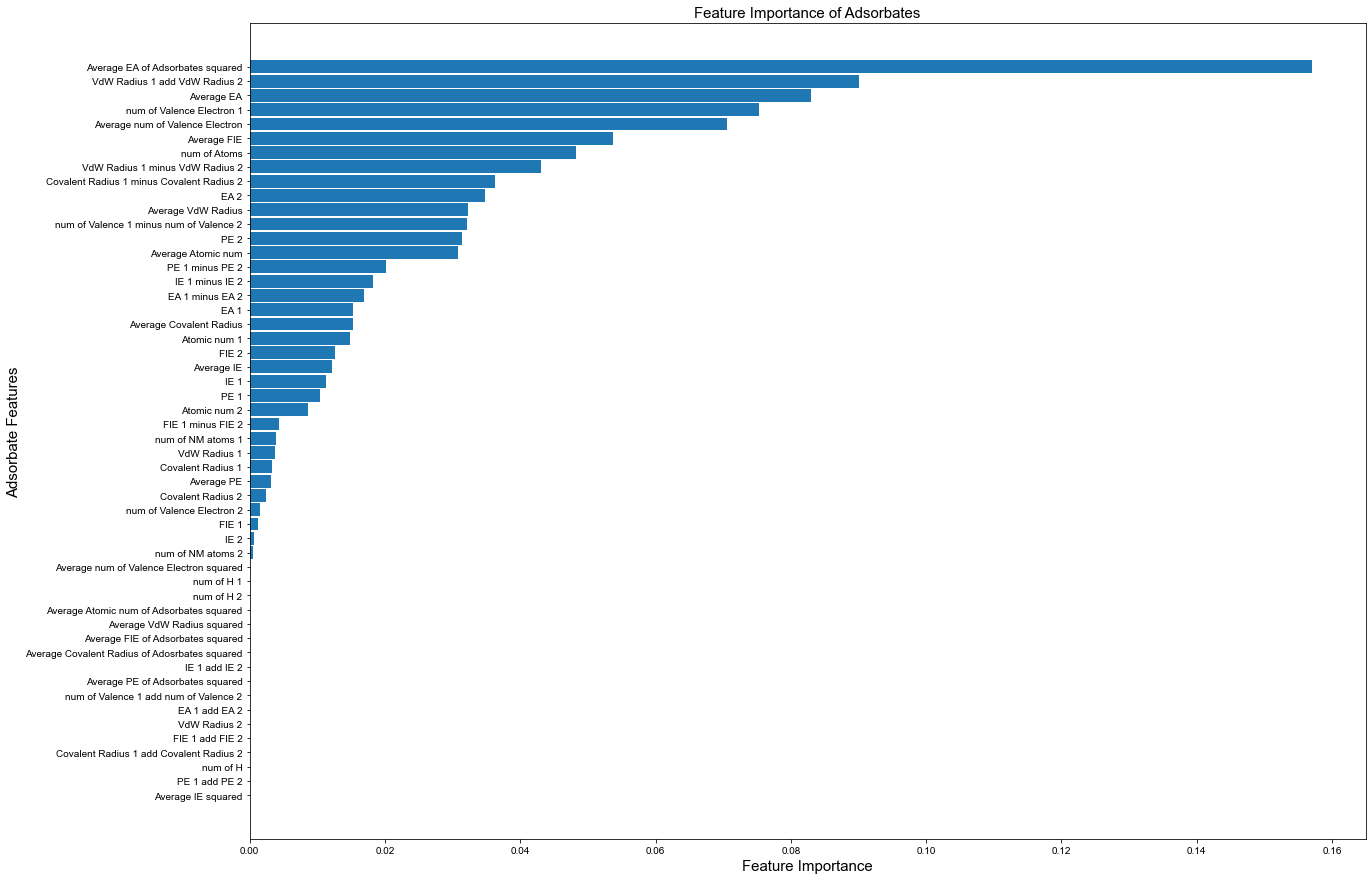

In [26]:
# Print a ranking of initial feature importance
feature_importance(XGBRegressor(), final_df)

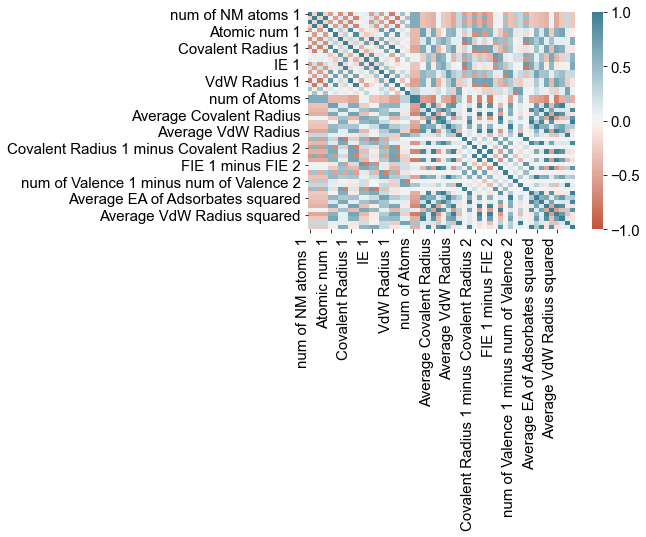

In [27]:
# Pearson's correlation heatmap of feature pairs
pearson_correlation(final_df, last=True)

### Round 2

In [28]:
# make a copy of the df from the previoud edition
df_v2 = final_df.copy()

In [29]:
# Dropping low ranking or dependent features
df_v2 = df_v2.drop(columns = ['VdW Radius 1 add VdW Radius 2',
       'FIE 1 add FIE 2', 'EA 1 add EA 2',
       'num of Valence 1 add num of Valence 2',
       'IE 1 add IE 2', 'Average EA'])

In [30]:
val_score(df_v2, 2, reg_xgbr, results_xgbr, 10)

In [31]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248


In [32]:
val_score(df_v2, 2, regressors, results_df, 10)

In [33]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367


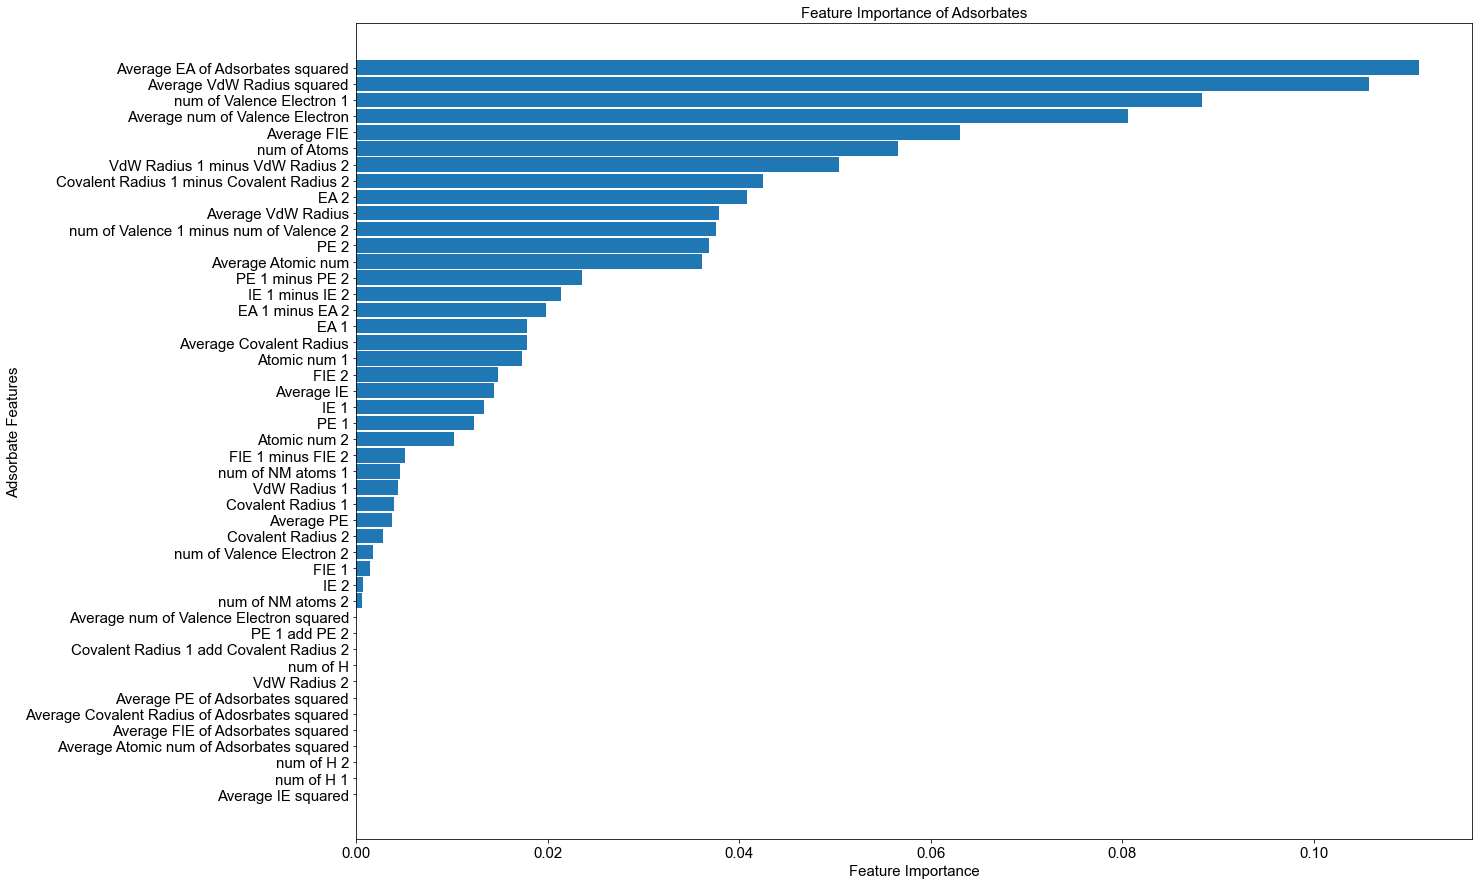

In [34]:
feature_importance(XGBRegressor(), df_v2)

### Round 3

In [35]:
df_v3 = df_v2.copy()

In [36]:
df_v3 = df_v3.drop(columns = ['PE 1 add PE 2',
       'Covalent Radius 1 add Covalent Radius 2', 'Average EA of Adsorbates squared', 'Average PE of Adsorbates squared',
       'Average Covalent Radius of Adosrbates squared',
       'Average FIE of Adsorbates squared',
       'Average Atomic num of Adsorbates squared',
       'Average num of Valence Electron squared', 'Average IE squared', 'num of Valence Electron 1', 'num of Valence Electron 2'])

In [37]:
val_score(df_v3, 3, reg_xgbr, results_xgbr, 10)

In [38]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525


In [39]:
val_score(df_v3, 3, regressors, results_df, 10)

In [40]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966


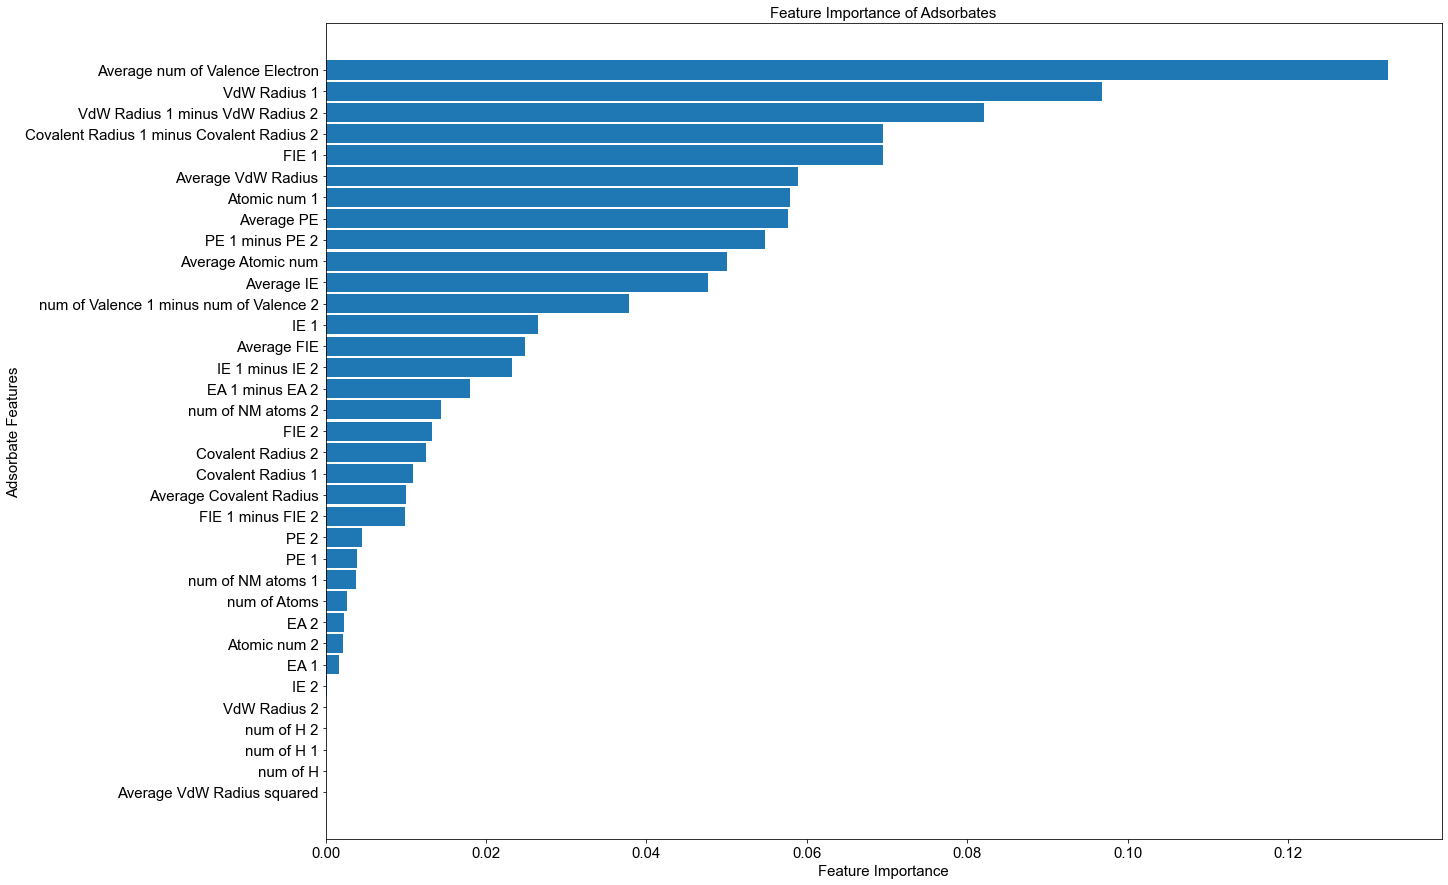

In [41]:
feature_importance(XGBRegressor(), df_v3)

### Round 4

In [42]:
df_v4 = df_v3.copy()

In [43]:
df_v4 = df_v4.drop(columns = ['num of H 1', 'num of H 2', 'num of H', 'VdW Radius 1',
       'VdW Radius 2', 'IE 1', 'IE 2', 'PE 1', 'PE 2'])

In [44]:
val_score(df_v4, 4, reg_xgbr, results_xgbr, 10)

In [45]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535


In [46]:
val_score(df_v4, 4, regressors, results_df, 10)

In [47]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482


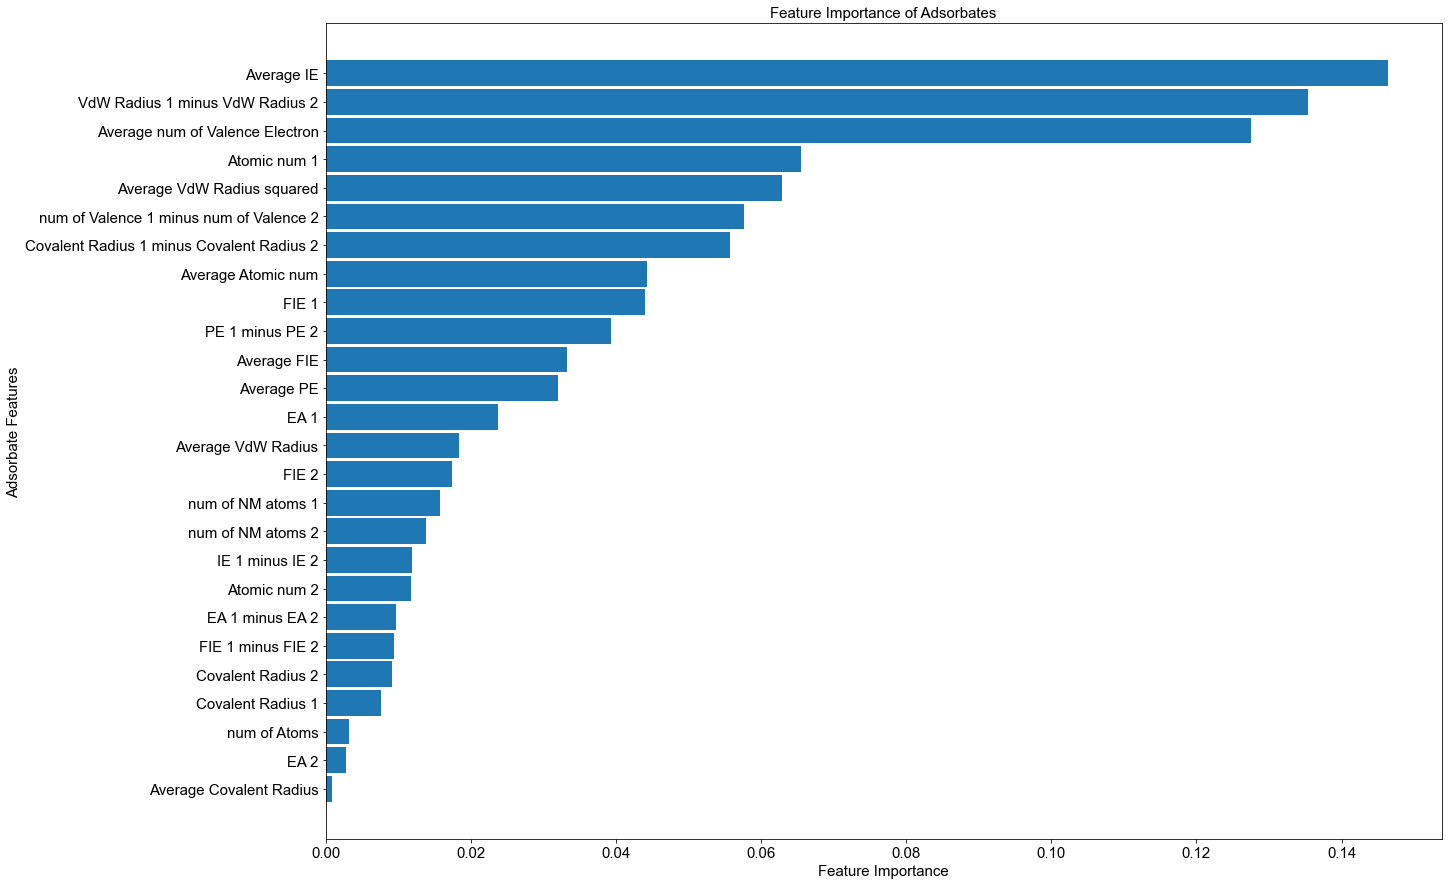

In [48]:
feature_importance(XGBRegressor(), df_v4)

### Round 5

In [49]:
df_v5 = df_v4.copy()

In [50]:
df_v5 = df_v5.drop(columns = ['Average PE', 'FIE 1', 'FIE 2', 'num of NM atoms 1', 'num of NM atoms 2', 'Average Atomic num'])

In [51]:
val_score(df_v5, 5, reg_xgbr, results_xgbr, 10)

In [52]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055


In [53]:
val_score(df_v5, 5, regressors, results_df, 10)

In [54]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436


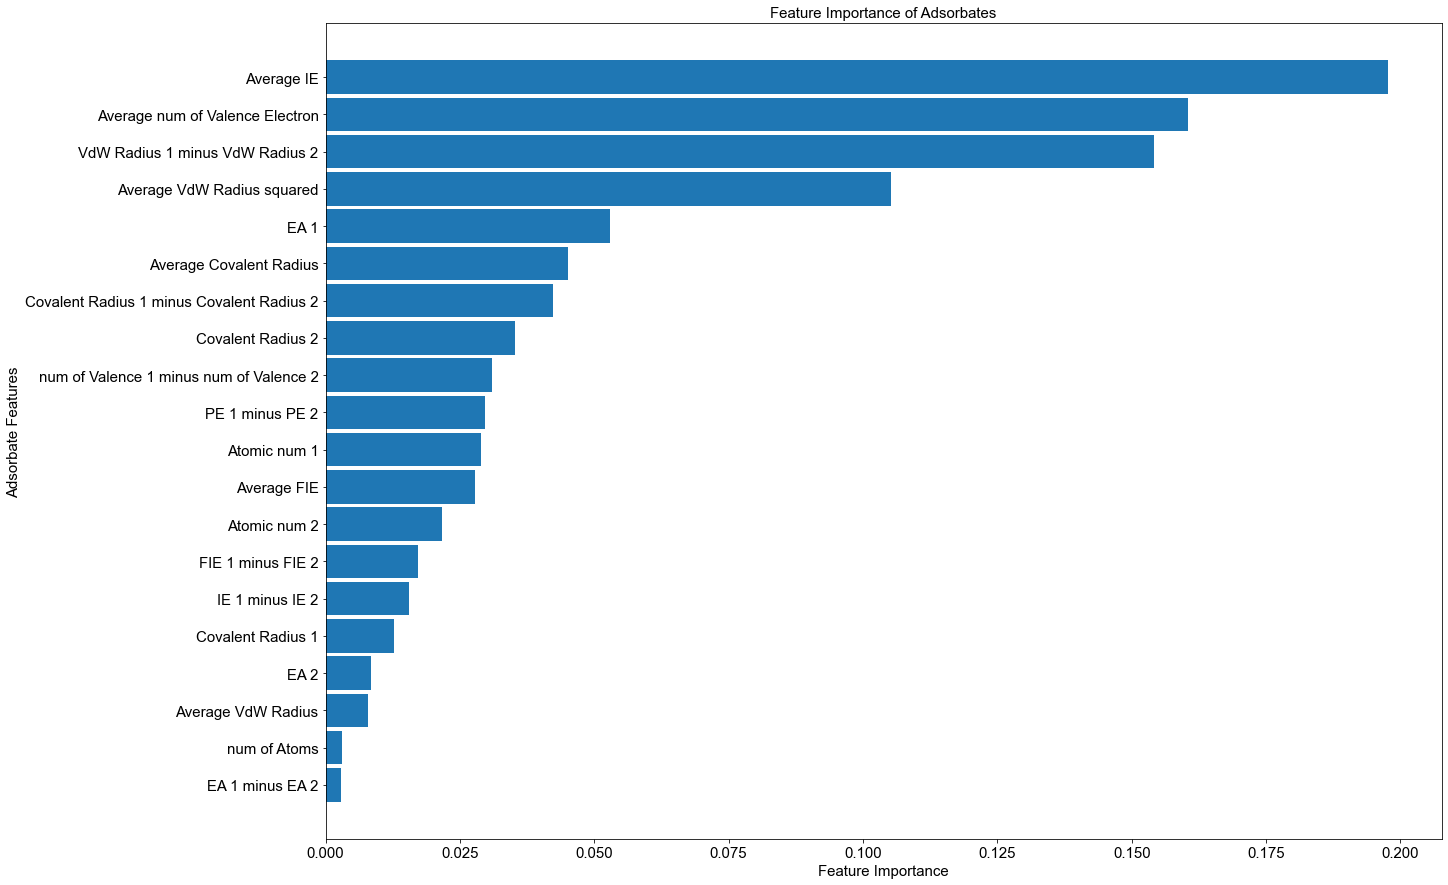

In [55]:
feature_importance(XGBRegressor(), df_v5)

### Round 6

In [56]:
df_v6 = df_v5.copy()

In [57]:
df_v6 = df_v6.drop(columns = ['Atomic num 1', 'VdW Radius 1 minus VdW Radius 2', 'Average FIE', 'Atomic num 2', 'FIE 1 minus FIE 2', 
                              'Covalent Radius 1', 'Covalent Radius 2', 
                              'EA 1', 'Average VdW Radius squared', 'EA 2', 'num of Atoms'])

In [58]:
val_score(df_v6, 6, reg_xgbr, results_xgbr, 10)

In [59]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055
6,9,"[0.0715, 0.0868]",4.143456


In [60]:
val_score(df_v6, 6, regressors, results_df, 10)

In [61]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436
6,9,"[0.0712, 0.084]","[0.0804, 0.0997]","[0.0663, 0.0832]","[0.079, 0.0953]","[0.0808, 0.0979]","[0.0715, 0.0868]","[0.0681, 0.0856]",18.259124


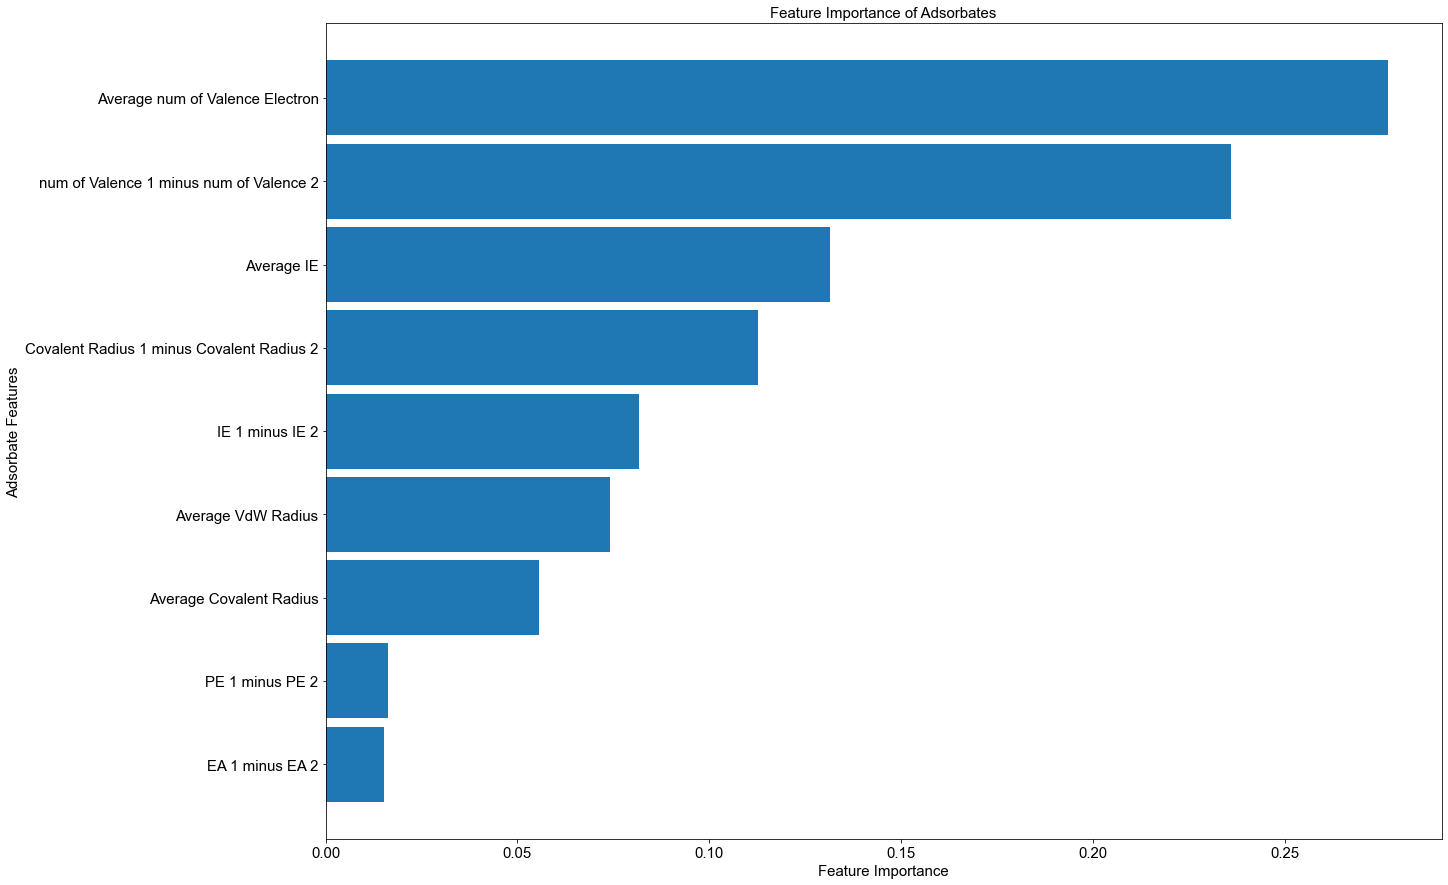

In [62]:
feature_importance(XGBRegressor(), df_v6)

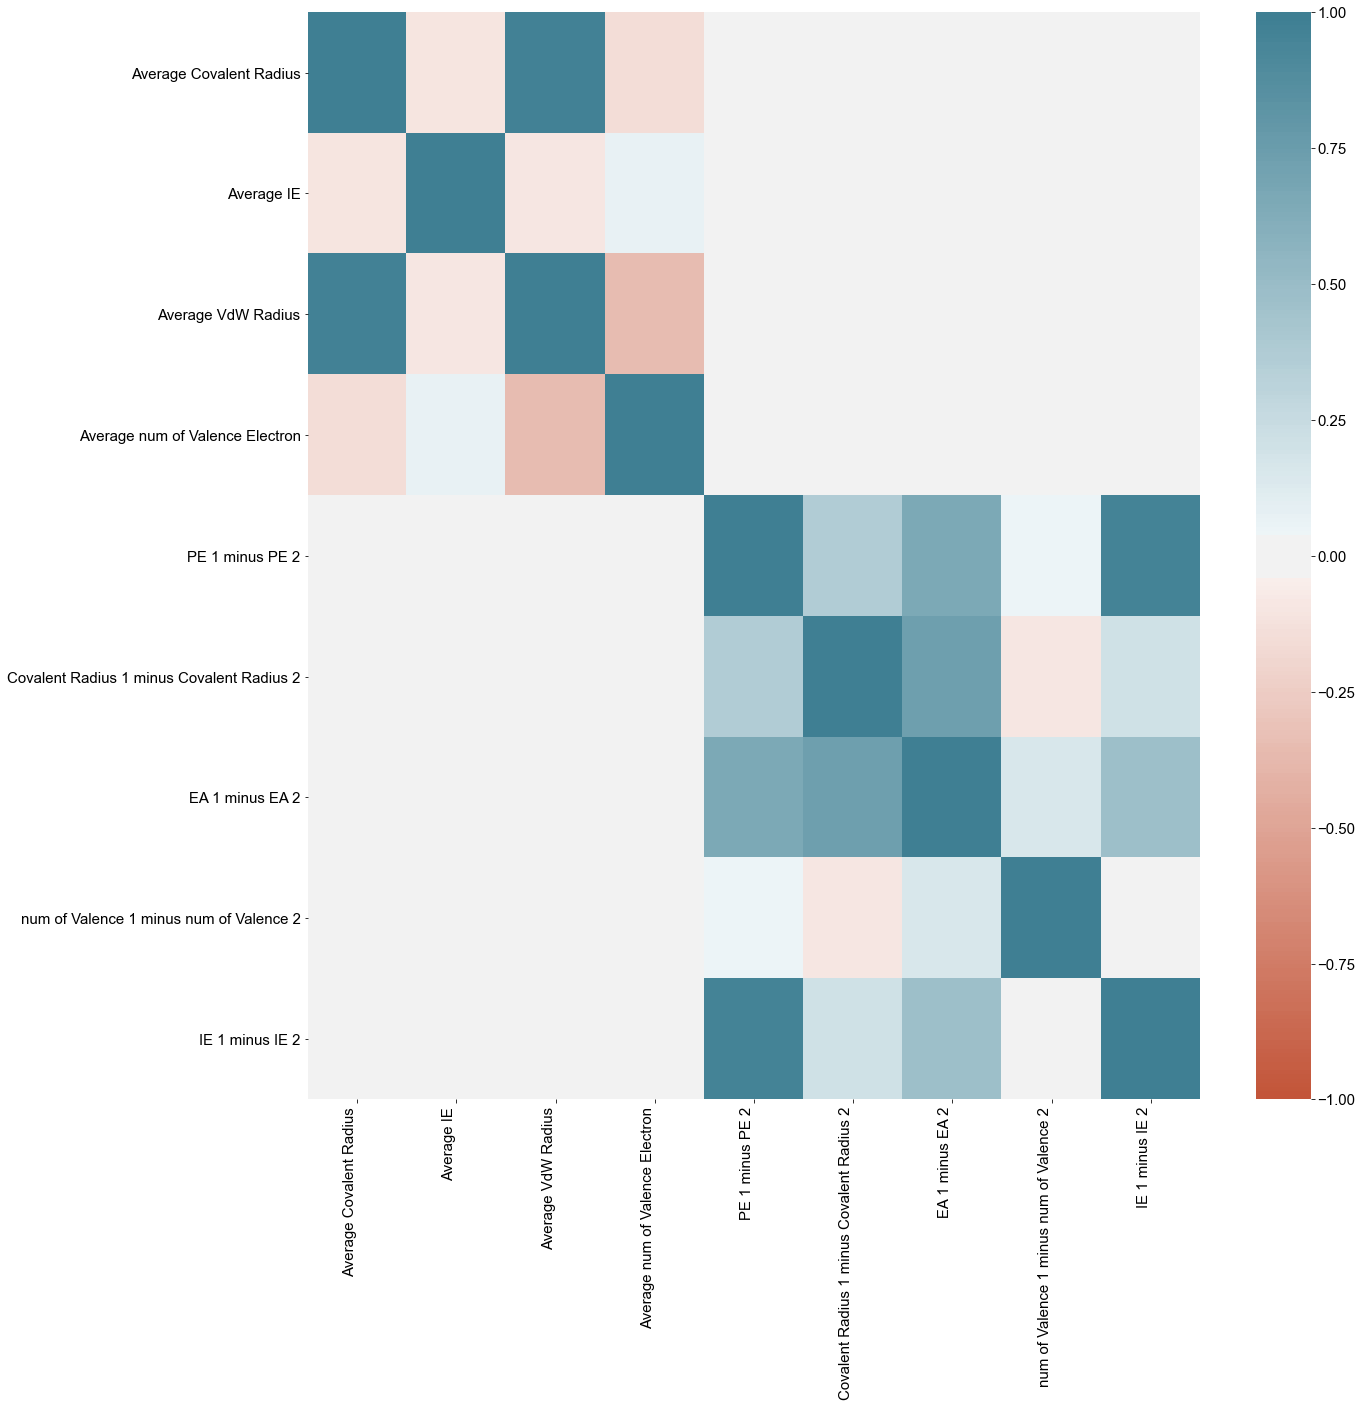

In [63]:
pearson_correlation(df_v6, last=True)

### Round 7

In [64]:
df_v7 = df_v6.copy()

In [65]:
df_v7 = df_v7.drop(columns = ['Average VdW Radius'])

In [66]:
val_score(df_v7, 7, reg_xgbr, results_xgbr, 10)

In [67]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055
6,9,"[0.0715, 0.0868]",4.143456
7,8,"[0.0715, 0.086]",2.691040


In [68]:
val_score(df_v7, 7, regressors, results_df, 10)

In [69]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436
6,9,"[0.0712, 0.084]","[0.0804, 0.0997]","[0.0663, 0.0832]","[0.079, 0.0953]","[0.0808, 0.0979]","[0.0715, 0.0868]","[0.0681, 0.0856]",18.259124
7,8,"[0.0708, 0.0851]","[0.0805, 0.0998]","[0.0669, 0.0838]","[0.079, 0.0952]","[0.0835, 0.1006]","[0.0715, 0.086]","[0.072, 0.0901]",17.697513


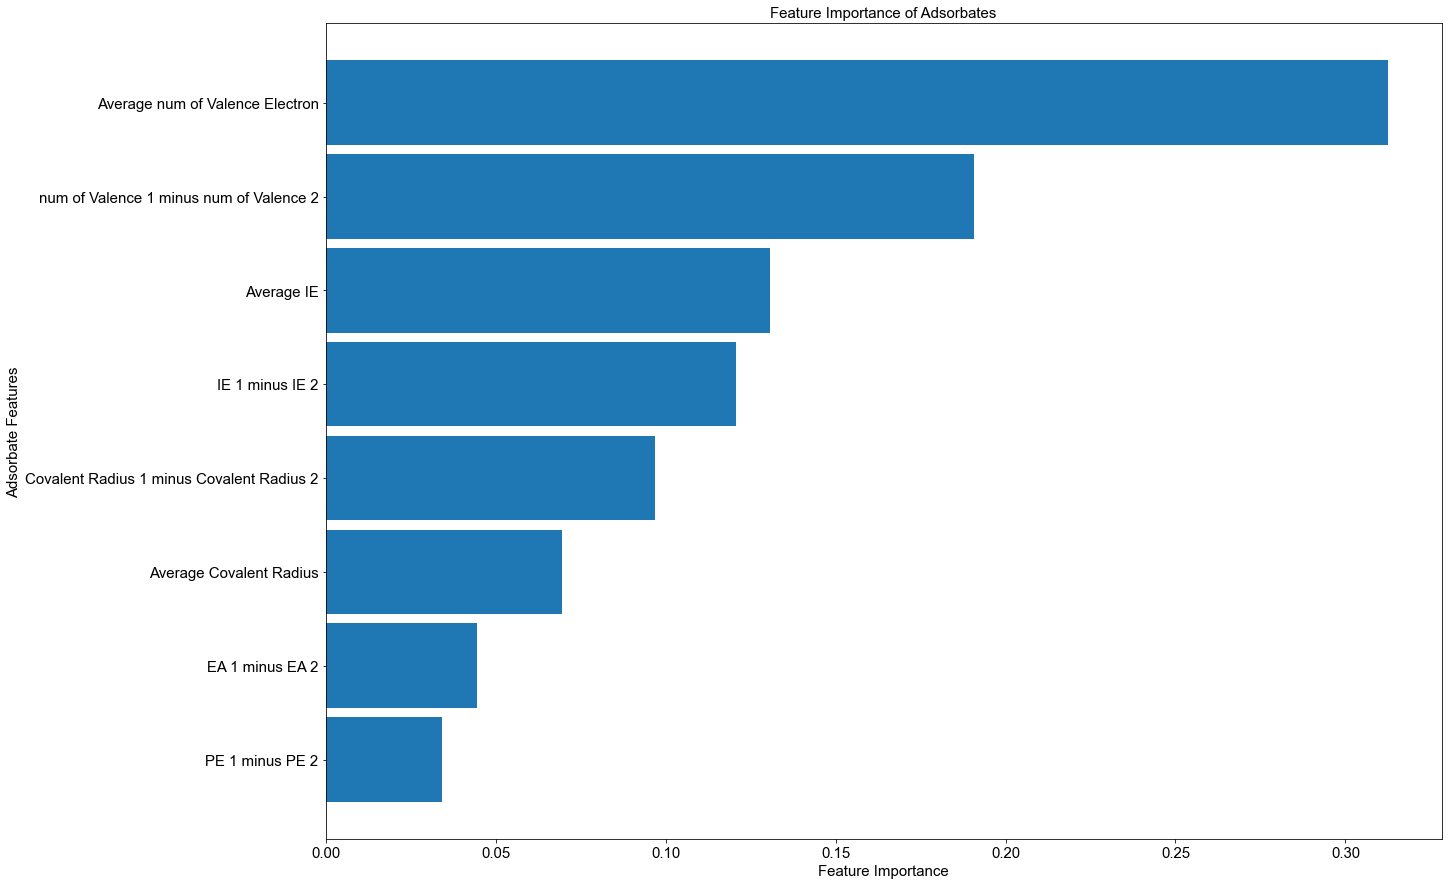

In [70]:
feature_importance(XGBRegressor(), df_v7)

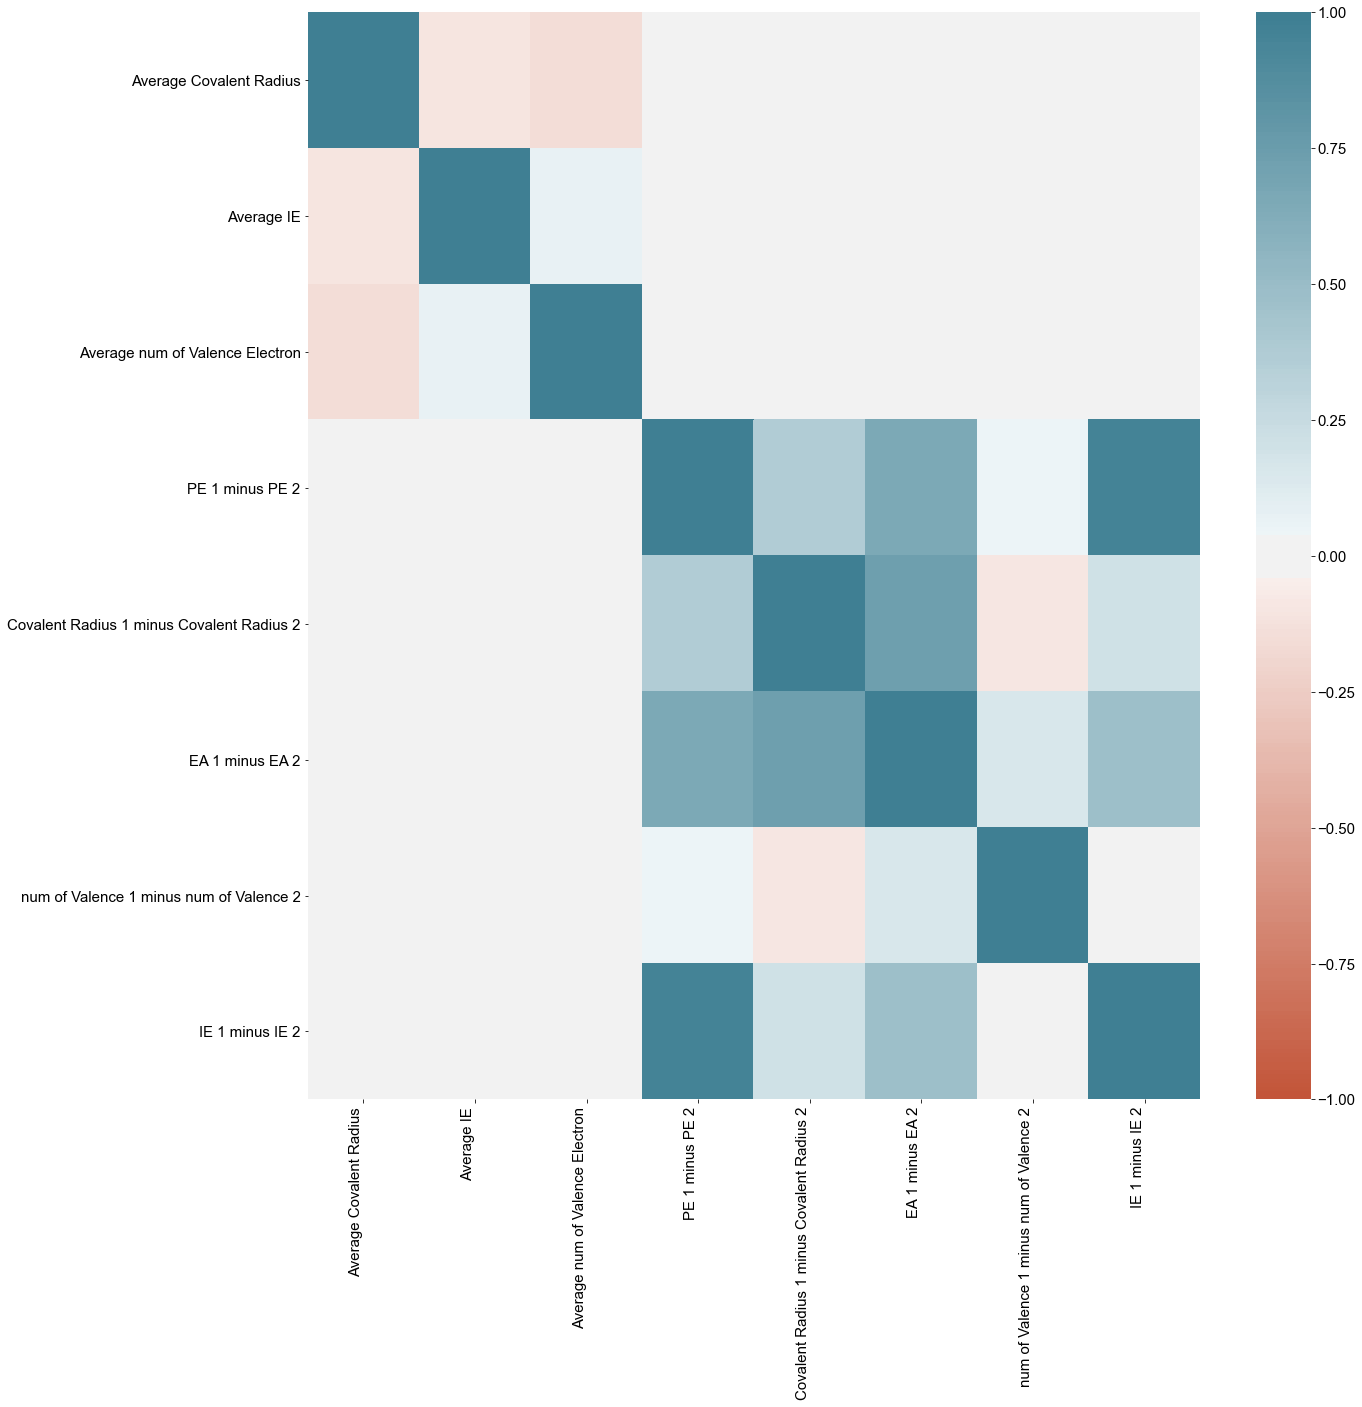

In [71]:
pearson_correlation(df_v7, last=True)

### Round 8

In [72]:
df_v8 = df_v7.copy()

In [73]:
df_v8 = df_v8.drop(columns = [ 'PE 1 minus PE 2'])

In [74]:
val_score(df_v8, 8, reg_xgbr, results_xgbr, 10)

In [75]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055
6,9,"[0.0715, 0.0868]",4.143456
7,8,"[0.0715, 0.086]",2.691040
8,7,"[0.0687, 0.0841]",2.801476


In [76]:
val_score(df_v8, 8, regressors, results_df, 10)

In [77]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436
6,9,"[0.0712, 0.084]","[0.0804, 0.0997]","[0.0663, 0.0832]","[0.079, 0.0953]","[0.0808, 0.0979]","[0.0715, 0.0868]","[0.0681, 0.0856]",18.259124
7,8,"[0.0708, 0.0851]","[0.0805, 0.0998]","[0.0669, 0.0838]","[0.079, 0.0952]","[0.0835, 0.1006]","[0.0715, 0.086]","[0.072, 0.0901]",17.697513
8,7,"[0.0705, 0.0842]","[0.0806, 0.0997]","[0.066, 0.0831]","[0.0788, 0.0951]","[0.0827, 0.0998]","[0.0687, 0.0841]","[0.0718, 0.09]",17.594259


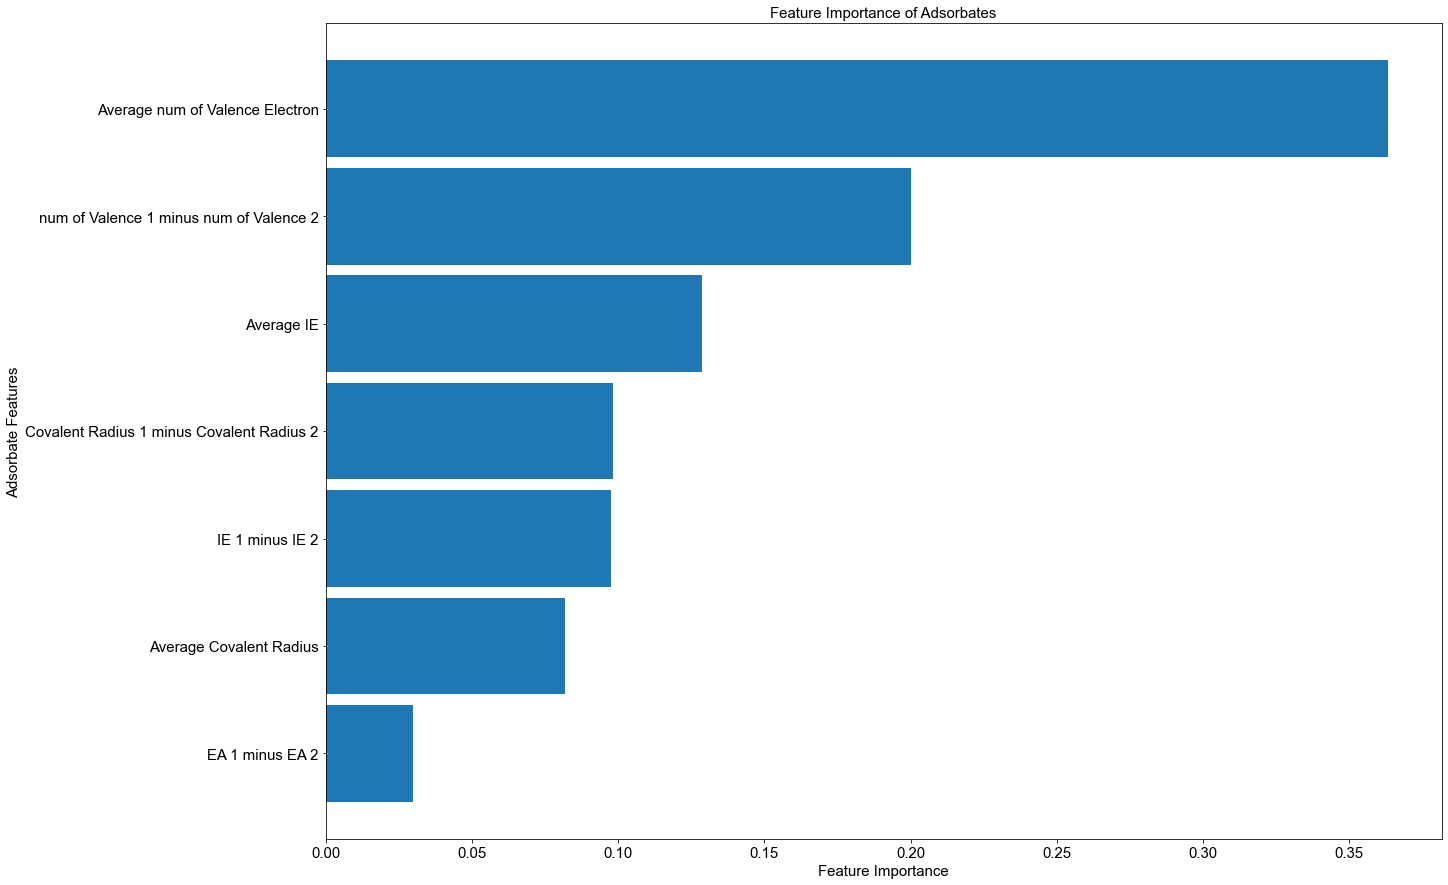

In [78]:
feature_importance(XGBRegressor(), df_v8)

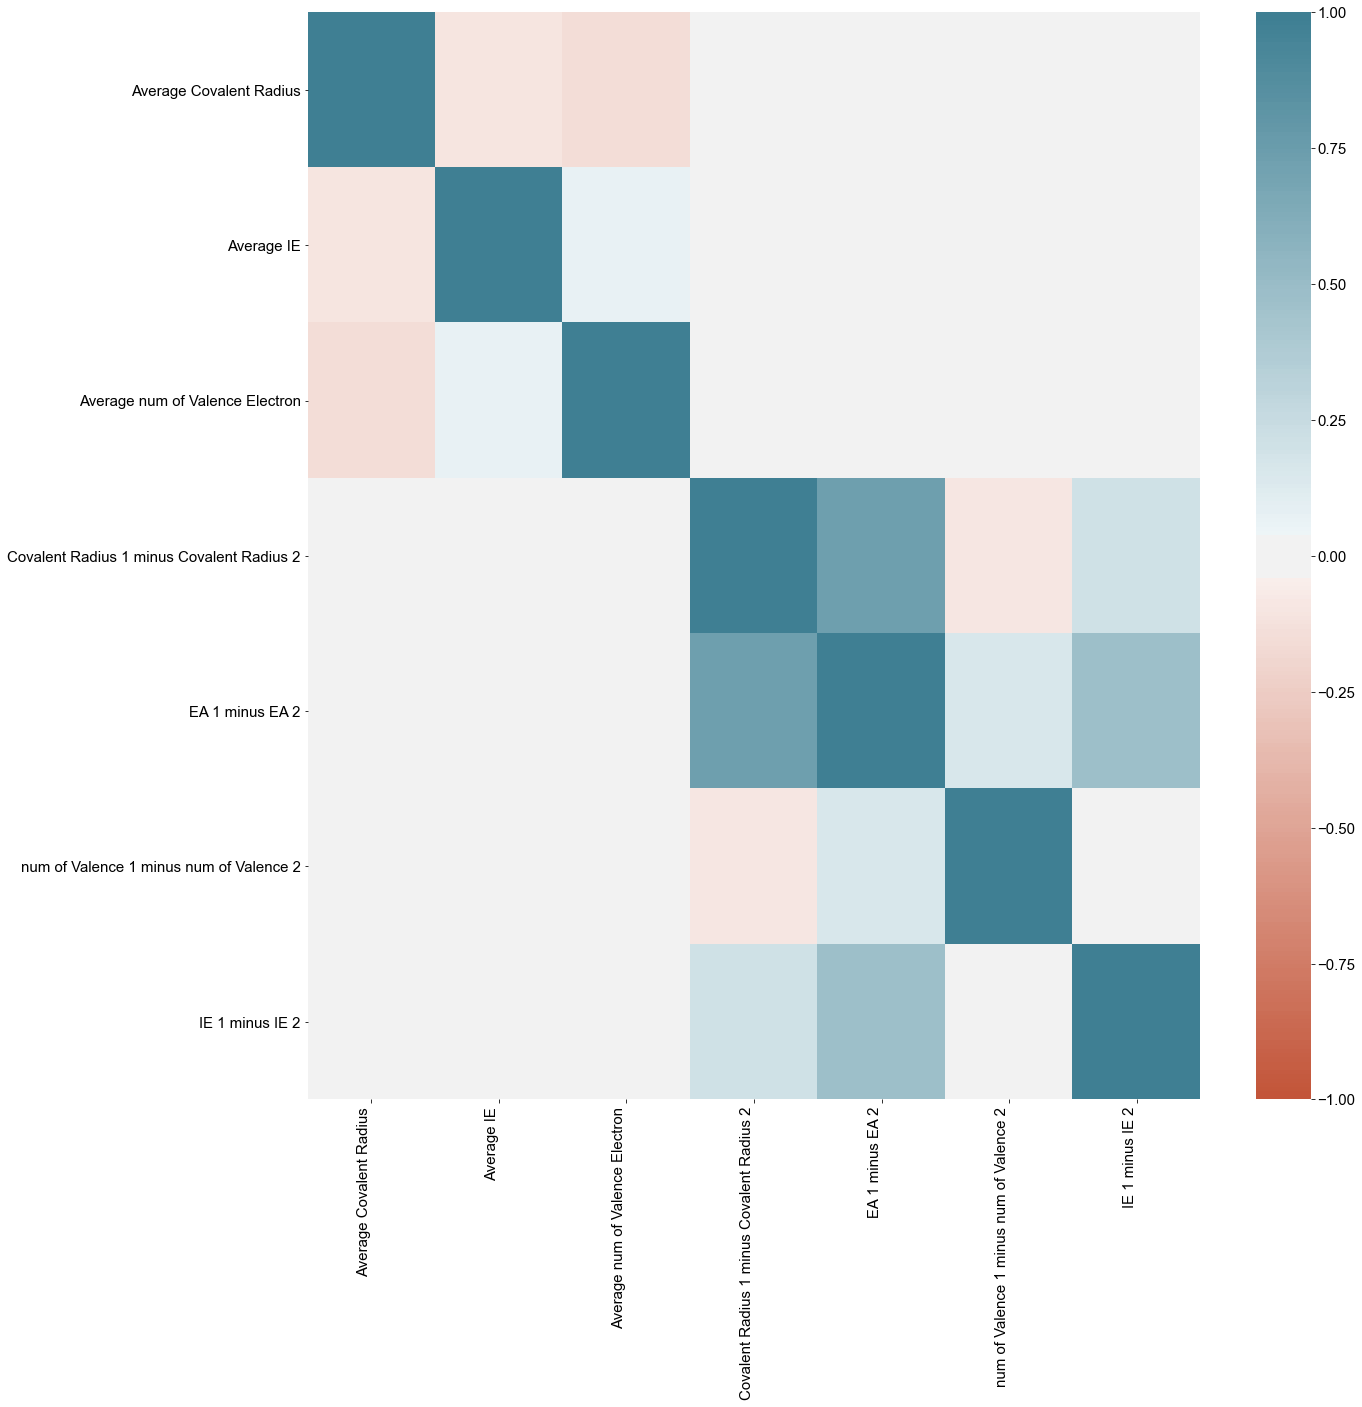

In [79]:
pearson_correlation(df_v8, last=True)

### Round 9

In [80]:
df_v9 = df_v8.copy()

In [81]:
df_v9 = df_v9.drop(columns = ['IE 1 minus IE 2'])

In [82]:
val_score(df_v9, 9, reg_xgbr, results_xgbr, 10)

In [83]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055
6,9,"[0.0715, 0.0868]",4.143456
7,8,"[0.0715, 0.086]",2.691040
8,7,"[0.0687, 0.0841]",2.801476
9,6,"[0.067, 0.0815]",3.330697


In [84]:
val_score(df_v9, 9, regressors, results_df, 10)

In [85]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436
6,9,"[0.0712, 0.084]","[0.0804, 0.0997]","[0.0663, 0.0832]","[0.079, 0.0953]","[0.0808, 0.0979]","[0.0715, 0.0868]","[0.0681, 0.0856]",18.259124
7,8,"[0.0708, 0.0851]","[0.0805, 0.0998]","[0.0669, 0.0838]","[0.079, 0.0952]","[0.0835, 0.1006]","[0.0715, 0.086]","[0.072, 0.0901]",17.697513
8,7,"[0.0705, 0.0842]","[0.0806, 0.0997]","[0.066, 0.0831]","[0.0788, 0.0951]","[0.0827, 0.0998]","[0.0687, 0.0841]","[0.0718, 0.09]",17.594259
9,6,"[0.0701, 0.0828]","[0.0745, 0.0913]","[0.0668, 0.0824]","[0.0789, 0.0933]","[0.0806, 0.0978]","[0.067, 0.0815]","[0.0704, 0.0884]",18.432683


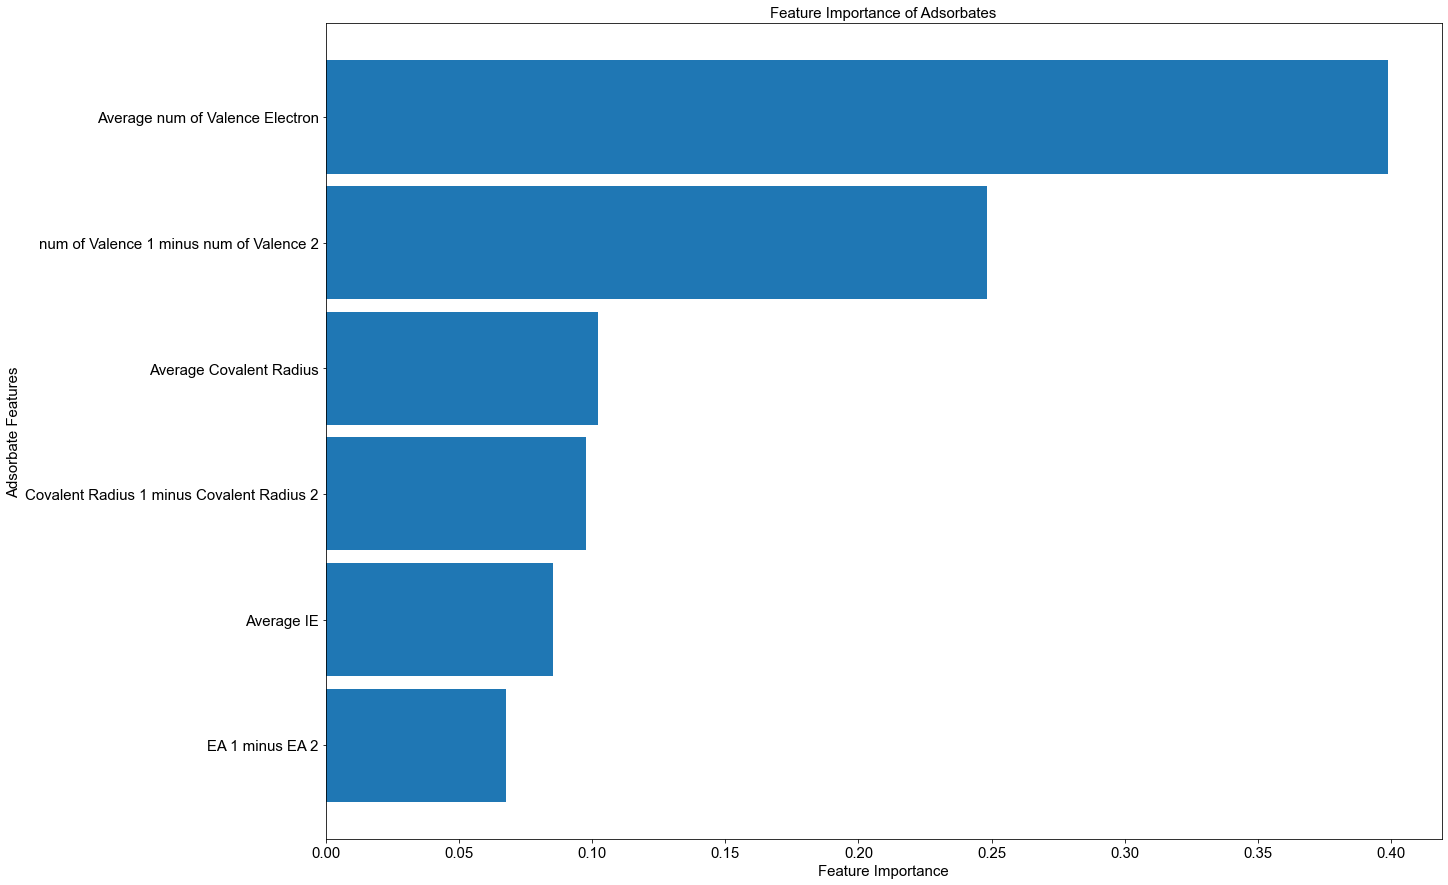

In [86]:
feature_importance(XGBRegressor(), df_v9)

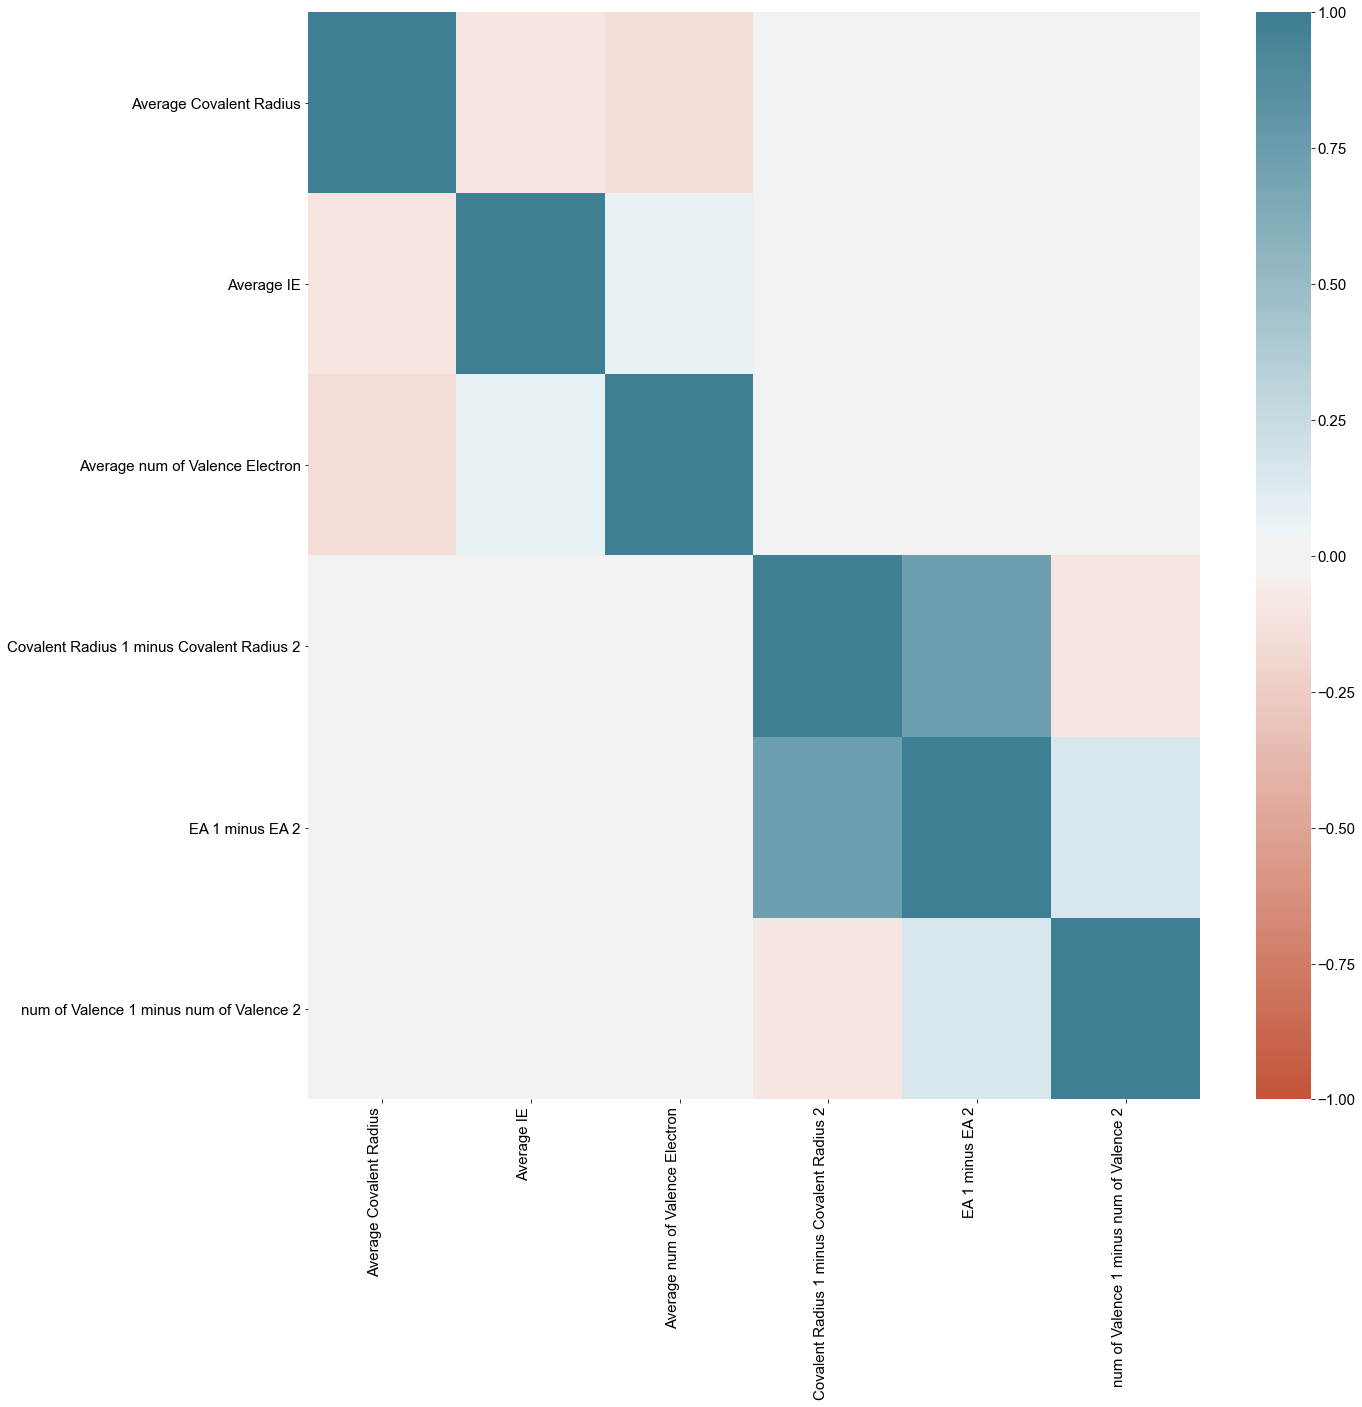

In [87]:
pearson_correlation(df_v9, last=True)

### Round 10

In [88]:
df_v10 = df_v9.copy()

In [89]:
df_v10 = df_v10.drop(columns = ['Average IE'])

In [90]:
val_score(df_v10, 10, reg_xgbr, results_xgbr, 10)

In [91]:
results_xgbr

,# Features,XGBR,Time
1,52,"[0.0715, 0.0912]",7.210220
2,46,"[0.0715, 0.0912]",3.408248
3,35,"[0.0744, 0.0911]",3.671525
4,26,"[0.0746, 0.0915]",3.187535
5,20,"[0.0736, 0.09]",2.799055
6,9,"[0.0715, 0.0868]",4.143456
7,8,"[0.0715, 0.086]",2.691040
8,7,"[0.0687, 0.0841]",2.801476
9,6,"[0.067, 0.0815]",3.330697
10,5,"[0.0692, 0.0848]",2.942763


In [92]:
val_score(df_v10, 10, regressors, results_df, 10)

In [93]:
results_df

,# Features,GBR,KNR,RFR,SVR,KRR,XGBR,LightGBM,Time
1,52,"[0.0678, 0.084]","[0.0824, 0.1022]","[0.0664, 0.0863]","[0.079, 0.0976]","[0.085, 0.1052]","[0.0715, 0.0912]","[0.0672, 0.0851]",24.519778
2,46,"[0.067, 0.0831]","[0.0825, 0.1024]","[0.0666, 0.0864]","[0.079, 0.0977]","[0.0839, 0.104]","[0.0715, 0.0912]","[0.067, 0.085]",23.979367
3,35,"[0.0733, 0.088]","[0.0949, 0.113]","[0.0685, 0.0874]","[0.0835, 0.1013]","[0.0827, 0.1005]","[0.0744, 0.0911]","[0.075, 0.0937]",22.227966
4,26,"[0.0732, 0.0875]","[0.0898, 0.1082]","[0.0676, 0.0862]","[0.084, 0.1022]","[0.0822, 0.0996]","[0.0746, 0.0915]","[0.0746, 0.0933]",21.668482
5,20,"[0.0723, 0.0868]","[0.0875, 0.1056]","[0.0682, 0.0865]","[0.0845, 0.1026]","[0.0805, 0.0977]","[0.0736, 0.09]","[0.0729, 0.0909]",19.404436
6,9,"[0.0712, 0.084]","[0.0804, 0.0997]","[0.0663, 0.0832]","[0.079, 0.0953]","[0.0808, 0.0979]","[0.0715, 0.0868]","[0.0681, 0.0856]",18.259124
7,8,"[0.0708, 0.0851]","[0.0805, 0.0998]","[0.0669, 0.0838]","[0.079, 0.0952]","[0.0835, 0.1006]","[0.0715, 0.086]","[0.072, 0.0901]",17.697513
8,7,"[0.0705, 0.0842]","[0.0806, 0.0997]","[0.066, 0.0831]","[0.0788, 0.0951]","[0.0827, 0.0998]","[0.0687, 0.0841]","[0.0718, 0.09]",17.594259
9,6,"[0.0701, 0.0828]","[0.0745, 0.0913]","[0.0668, 0.0824]","[0.0789, 0.0933]","[0.0806, 0.0978]","[0.067, 0.0815]","[0.0704, 0.0884]",18.432683
10,5,"[0.0682, 0.0824]","[0.0694, 0.0904]","[0.0661, 0.0821]","[0.0769, 0.0918]","[0.0795, 0.0976]","[0.0692, 0.0848]","[0.0708, 0.0894]",17.271556


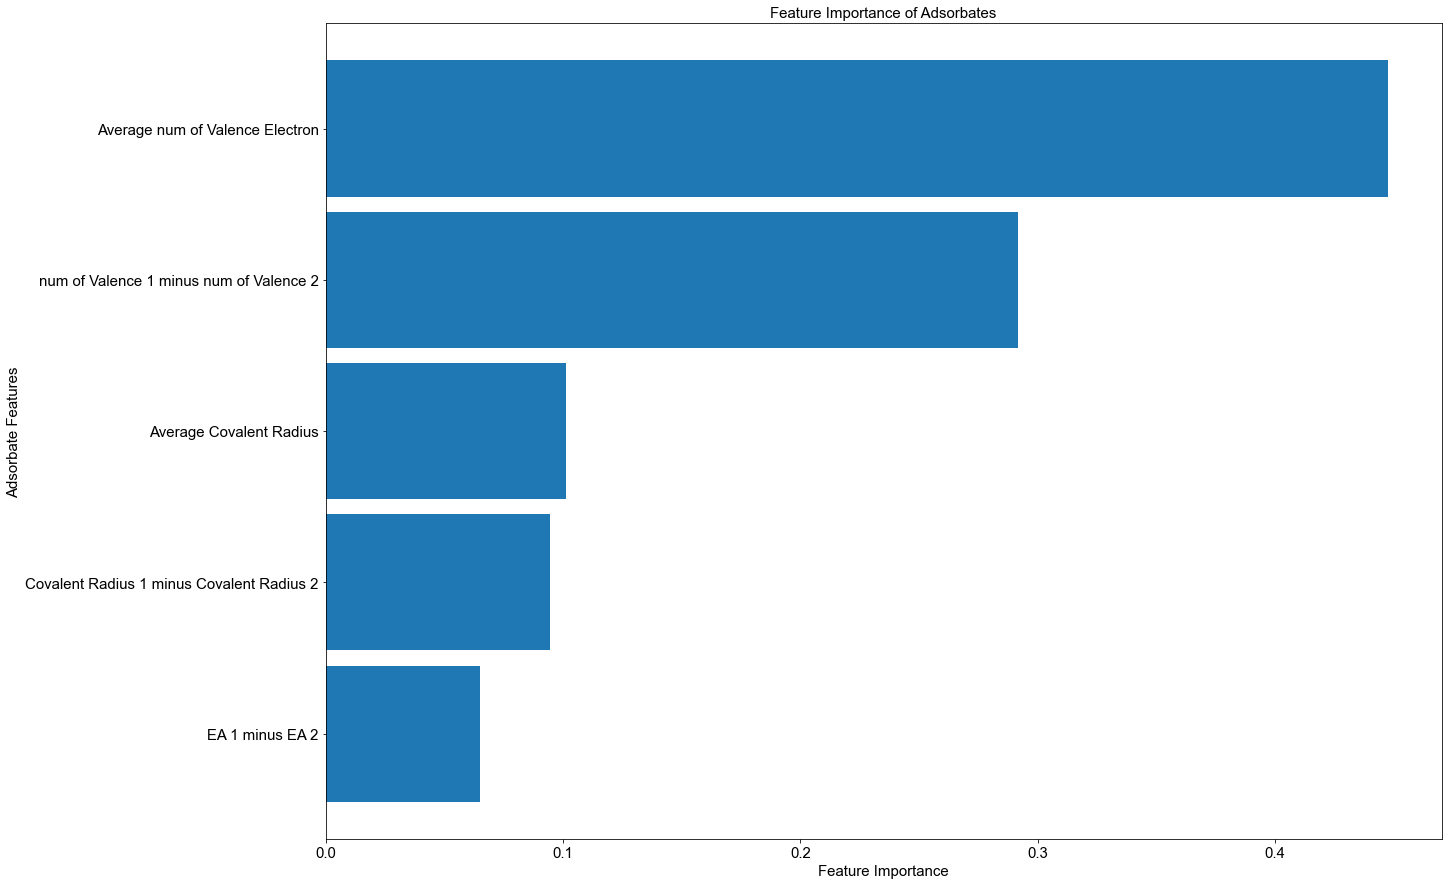

In [94]:
feature_importance(XGBRegressor(), df_v10)

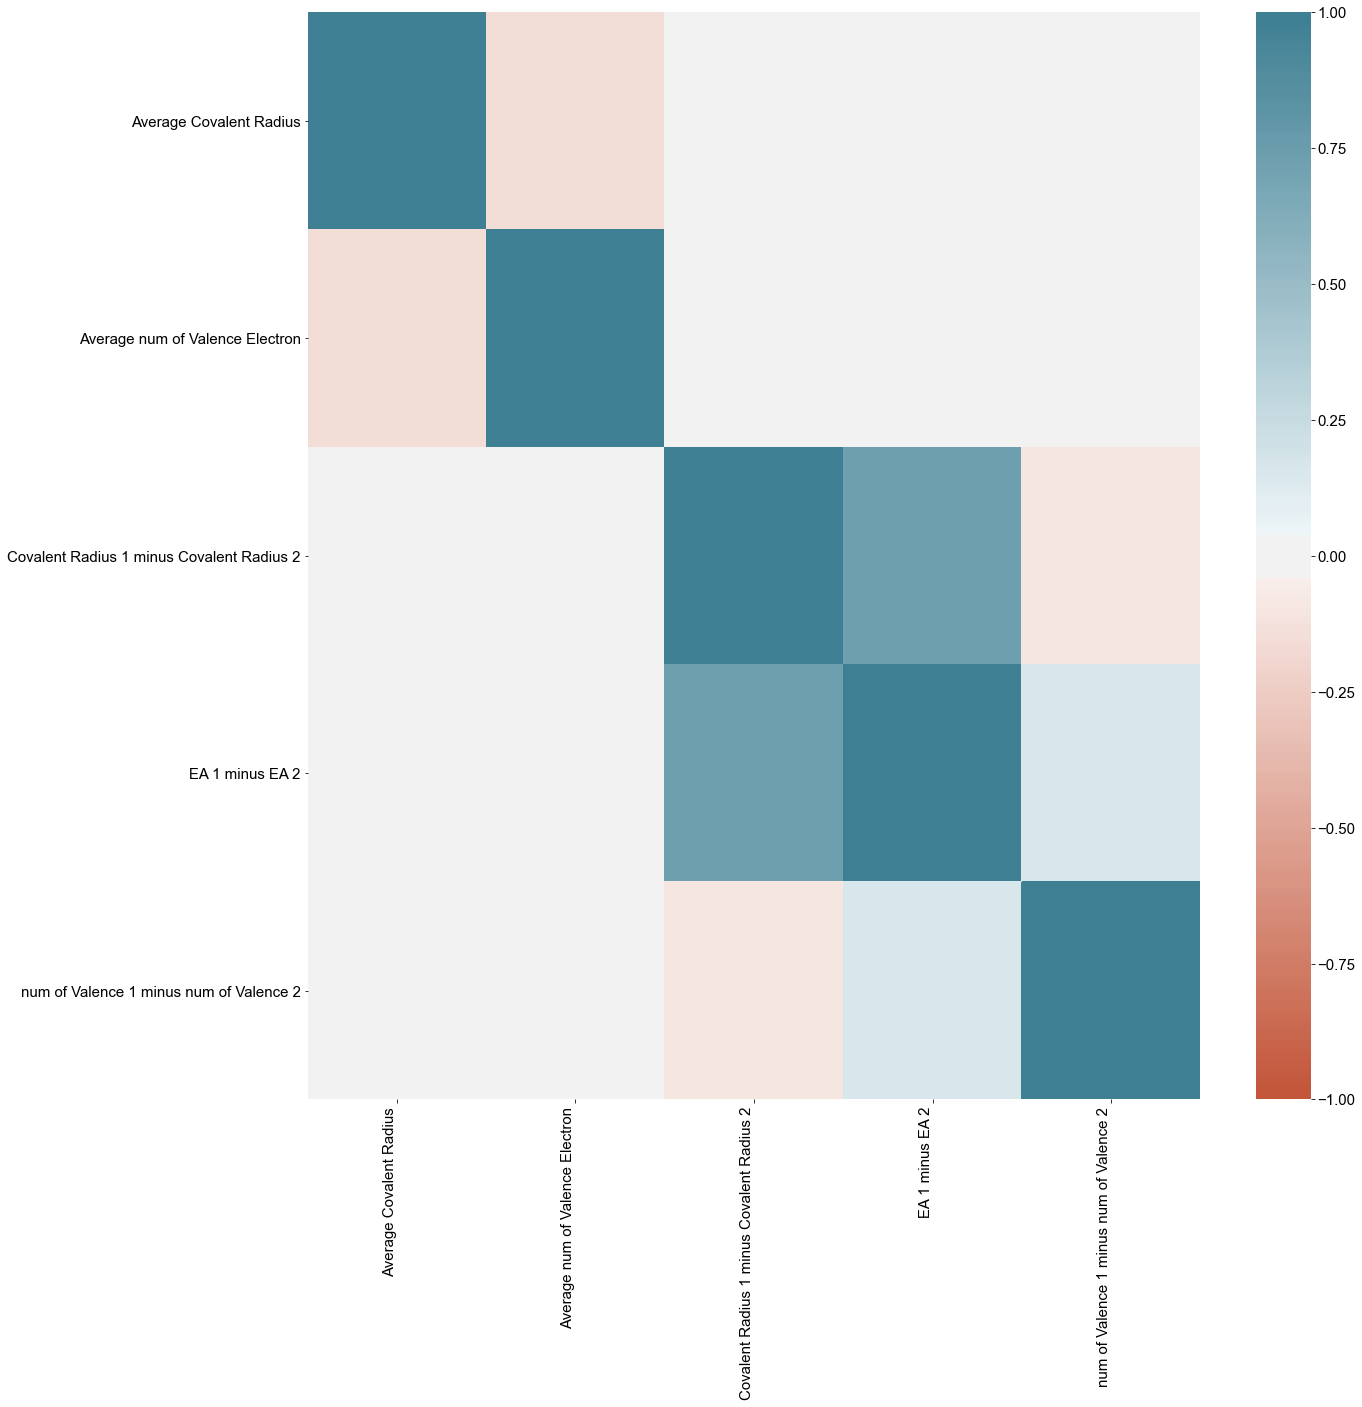

In [95]:
pearson_correlation(df_v10, last=True)

## 3.2 Final Feature Selection Figures

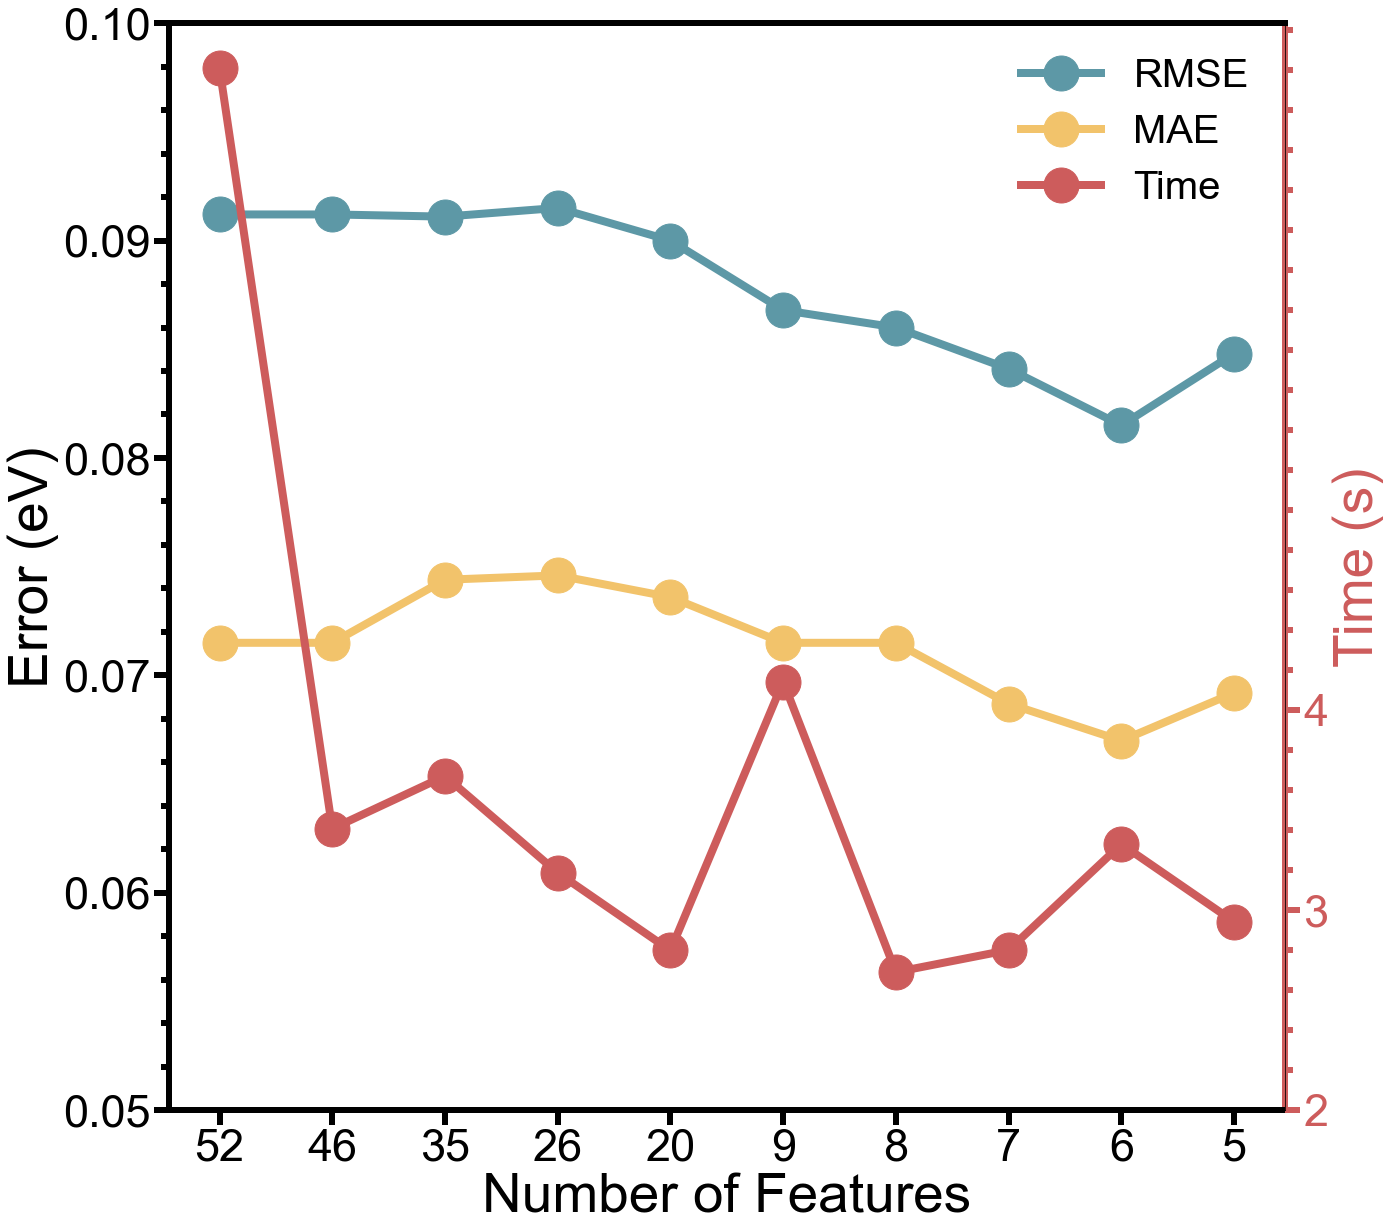

In [96]:
# Get XGBR MAE values
mae_0 = results_df['XGBR'][1][0]
mae_1 = results_df['XGBR'][2][0]
mae_2 = results_df['XGBR'][3][0]
mae_3 = results_df['XGBR'][4][0]
mae_4 = results_df['XGBR'][5][0]
mae_5 = results_df['XGBR'][6][0]
mae_6 = results_df['XGBR'][7][0]
mae_7 = results_df['XGBR'][8][0]
mae_8 = results_df['XGBR'][9][0]
mae_9 = results_df['XGBR'][10][0]
mae = [mae_0, mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8, mae_9]

# Get XGBR RMSE values
rmse_0 = results_df['XGBR'][1][1]
rmse_1 = results_df['XGBR'][2][1]
rmse_2 = results_df['XGBR'][3][1]
rmse_3 = results_df['XGBR'][4][1]
rmse_4 = results_df['XGBR'][5][1]
rmse_5 = results_df['XGBR'][6][1]
rmse_6 = results_df['XGBR'][7][1]
rmse_7 = results_df['XGBR'][8][1]
rmse_8 = results_df['XGBR'][9][1]
rmse_9 = results_df['XGBR'][10][1]
rmse = [rmse_0, rmse_1, rmse_2, rmse_3, rmse_4, rmse_5, rmse_6, rmse_7, rmse_8, rmse_9]

# Get run times
time1 = results_xgbr['Time'][1]
time2 = results_xgbr['Time'][2]
time3 = results_xgbr['Time'][3]
time4 = results_xgbr['Time'][4]
time5 = results_xgbr['Time'][5]
time6 = results_xgbr['Time'][6]
time7 = results_xgbr['Time'][7]
time8 = results_xgbr['Time'][8]
time9 = results_xgbr['Time'][9]
time10 = results_xgbr['Time'][10]
run_time = [time1, time2, time3, time4, time5, time6, time7, time8, time9, time10]

# Get # of features
feature1 = str(results_df['# Features'][1])
feature2 = str(results_df['# Features'][2])
feature3 = str(results_df['# Features'][3])
feature4 = str(results_df['# Features'][4])
feature5 = str(results_df['# Features'][5])
feature6 = str(results_df['# Features'][6])
feature7 = str(results_df['# Features'][7])
feature8 = str(results_df['# Features'][8])
feature9 = str(results_df['# Features'][9])
feature10 = str(results_df['# Features'][10])
ml_features = [feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10]

# Plot figure
ml_features = np.array(ml_features)
run_time = np.array(run_time)
data1 = np.array(rmse)
data2 = np.array(mae)

m1_t = pd.DataFrame({
 'run_time' : run_time,
 'RMSE (eV)' : data1,
 'MAE (eV)' : data2})

fig, ax1 = plt.subplots()

bar1 = ax1.plot(ml_features, m1_t['RMSE (eV)'], color='#5D98A6', label='RMSE', 
                marker = 'o', linewidth = 8, markersize = 35)
bar2 = ax1.plot(ml_features, m1_t['MAE (eV)'], color='#F2C36B', label='MAE', 
                marker = 'o', linewidth = 8, markersize = 35)

ax1.set_xticklabels(ml_features)
ax1.tick_params(axis='y', labelcolor='black', labelsize = 45, width=6, length=15, color='black', which='major')
ax1.tick_params(axis='x', labelcolor='black', labelsize = 45, width=6, length=15, color='black', which='major')
ax1.tick_params(axis='y', labelcolor='black', labelsize = 45, width=6, length=8, color='black', which="minor")

ax1.minorticks_on()
ax1.set_yticks([0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

ax2 = ax1.twinx()

linecolor = '#CD5C5C'
time = ax2.plot(ml_features, m1_t['run_time'], marker = 'o', color = linecolor, label='Time', linewidth = 8, markersize = 35)
ax2.tick_params(axis='y', labelcolor=linecolor, labelsize = 45, width=6, length=15, color=linecolor, which='major')
ax2.tick_params(axis='y', labelcolor=linecolor, labelsize = 45, width=6, length=8, color=linecolor, which="minor")

lns = bar1+bar2+time
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0, fontsize=40, frameon=False)


ax1.set_xlabel('Number of Features', size = 55)
ax1.set_ylabel('Error (eV)', color='black', size = 55)
ax2.set_ylabel('Time (s)', color=linecolor, size = 55)
ax2.minorticks_on()
ax2.set_yticks([2, 3, 4])

for axis in ['top','bottom','left','right']:
    if axis == 'right':
        ax1.spines[axis].set_color(linecolor)
    ax1.spines[axis].set_linewidth(6)

plt.savefig('{}dim_feature_selection.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show()

In [97]:
# Save errors to csv
results_df.to_csv('CO Dimerization Errors.csv')

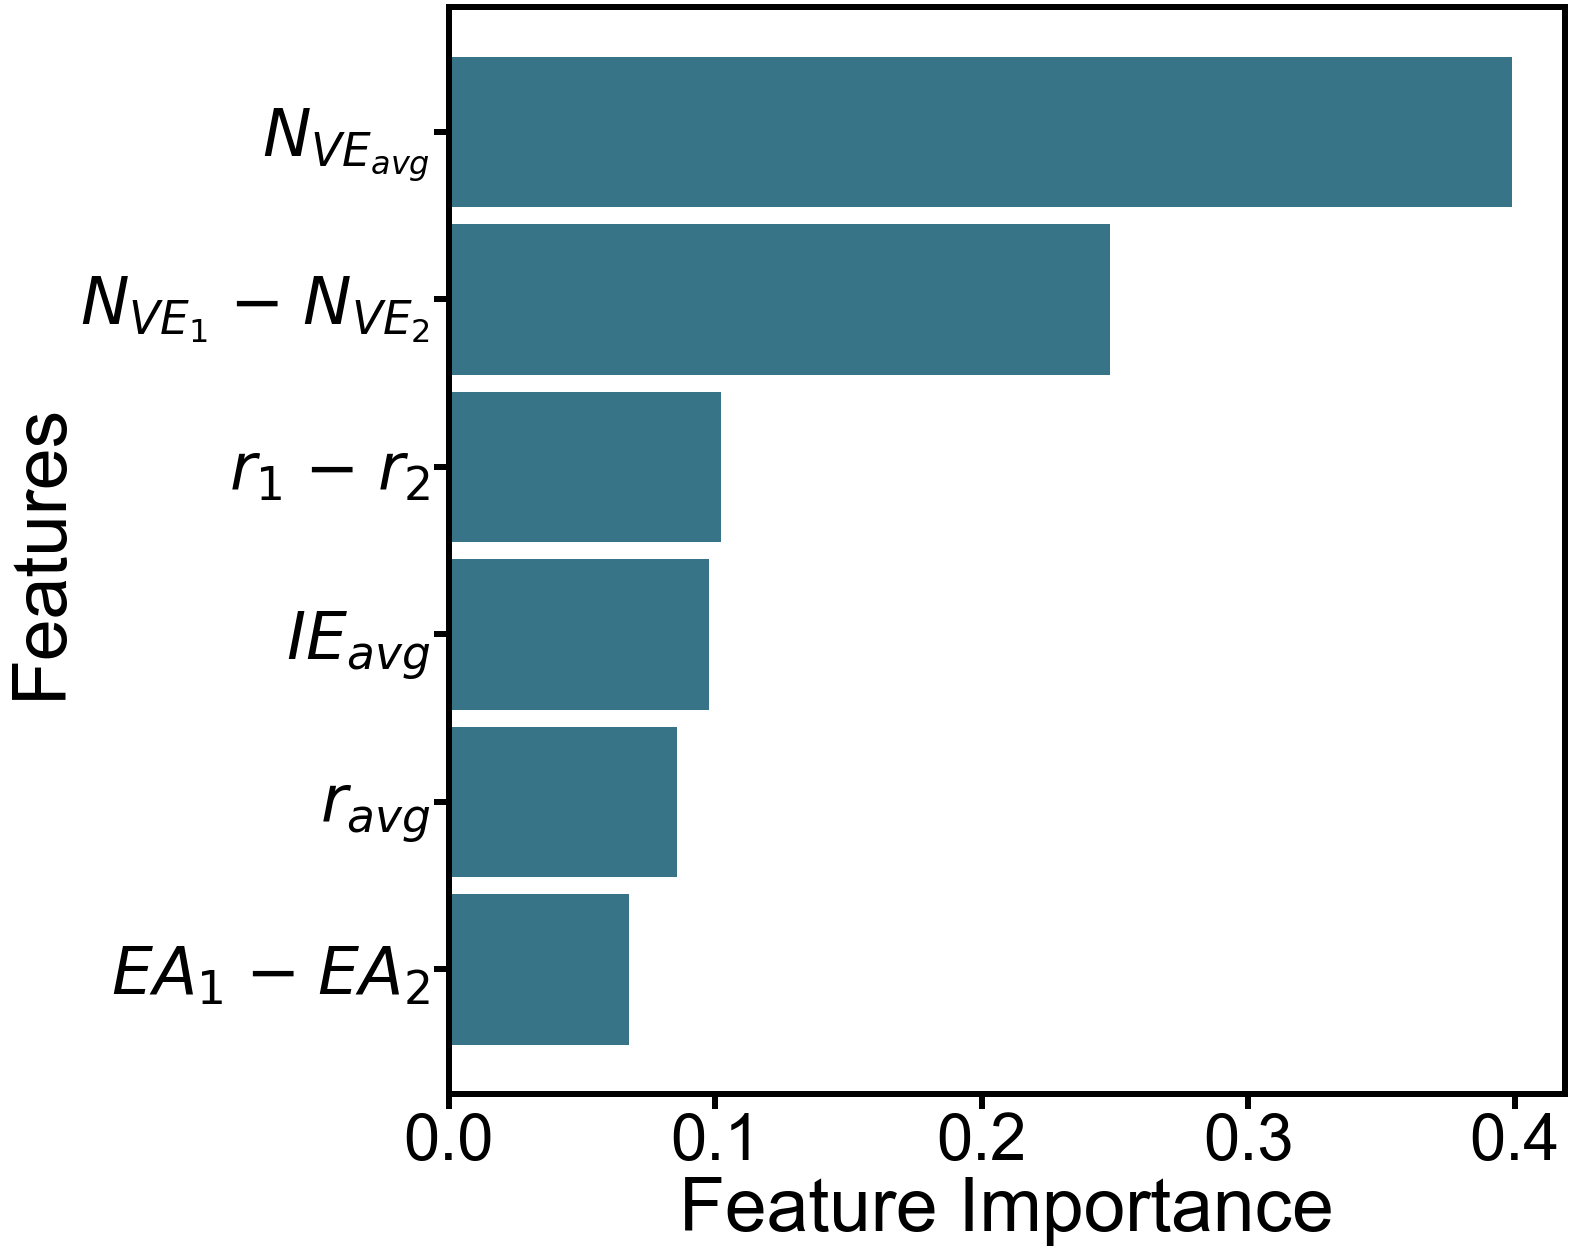

In [98]:
# Plot final feature importance figure

importance_labels = ['$N_{VE_{avg}}$', '$N_{VE_{1}}$ $-$ $N_{VE_{2}}$', '$r_1$ $-$ $r_2$', '$IE_{avg}$', 
                     '$r_{avg}}$',  '$EA_{1}$ $-$ $EA_{2}$']
importance_labels = reversed(importance_labels)

features = df_v9.iloc[:, 0:-1]
target = df_v9.iloc[:, -1]

xgbr.fit(features, target)

importance = xgbr.feature_importances_
features = df_v9.columns[0:-1]

col = zip(features, importance)

# sort and save features based on its importance into a dataframe
importance_data = pd.DataFrame(col, columns=['feature', 'importance'])
importance_data_asc = importance_data.sort_values('importance')

# plot the importance data
fig, ax = plt.subplots()
plt.barh(y=importance_data_asc['feature'], width=importance_data_asc['importance'], height=0.9, color='#377488')
ax.set_yticklabels(importance_labels)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)

ax.tick_params(axis='x', colors='black', width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', width=6, length=15, color='black')    

ax.set_xlabel("Feature Importance", fontsize = 75)
ax.set_ylabel("Features", fontsize = 75)

ax.tick_params(axis='x', colors='black', labelsize = 65, width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', labelsize = 65, width=6, length=15, color='black')

plt.savefig('{}dim_final_features.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show();

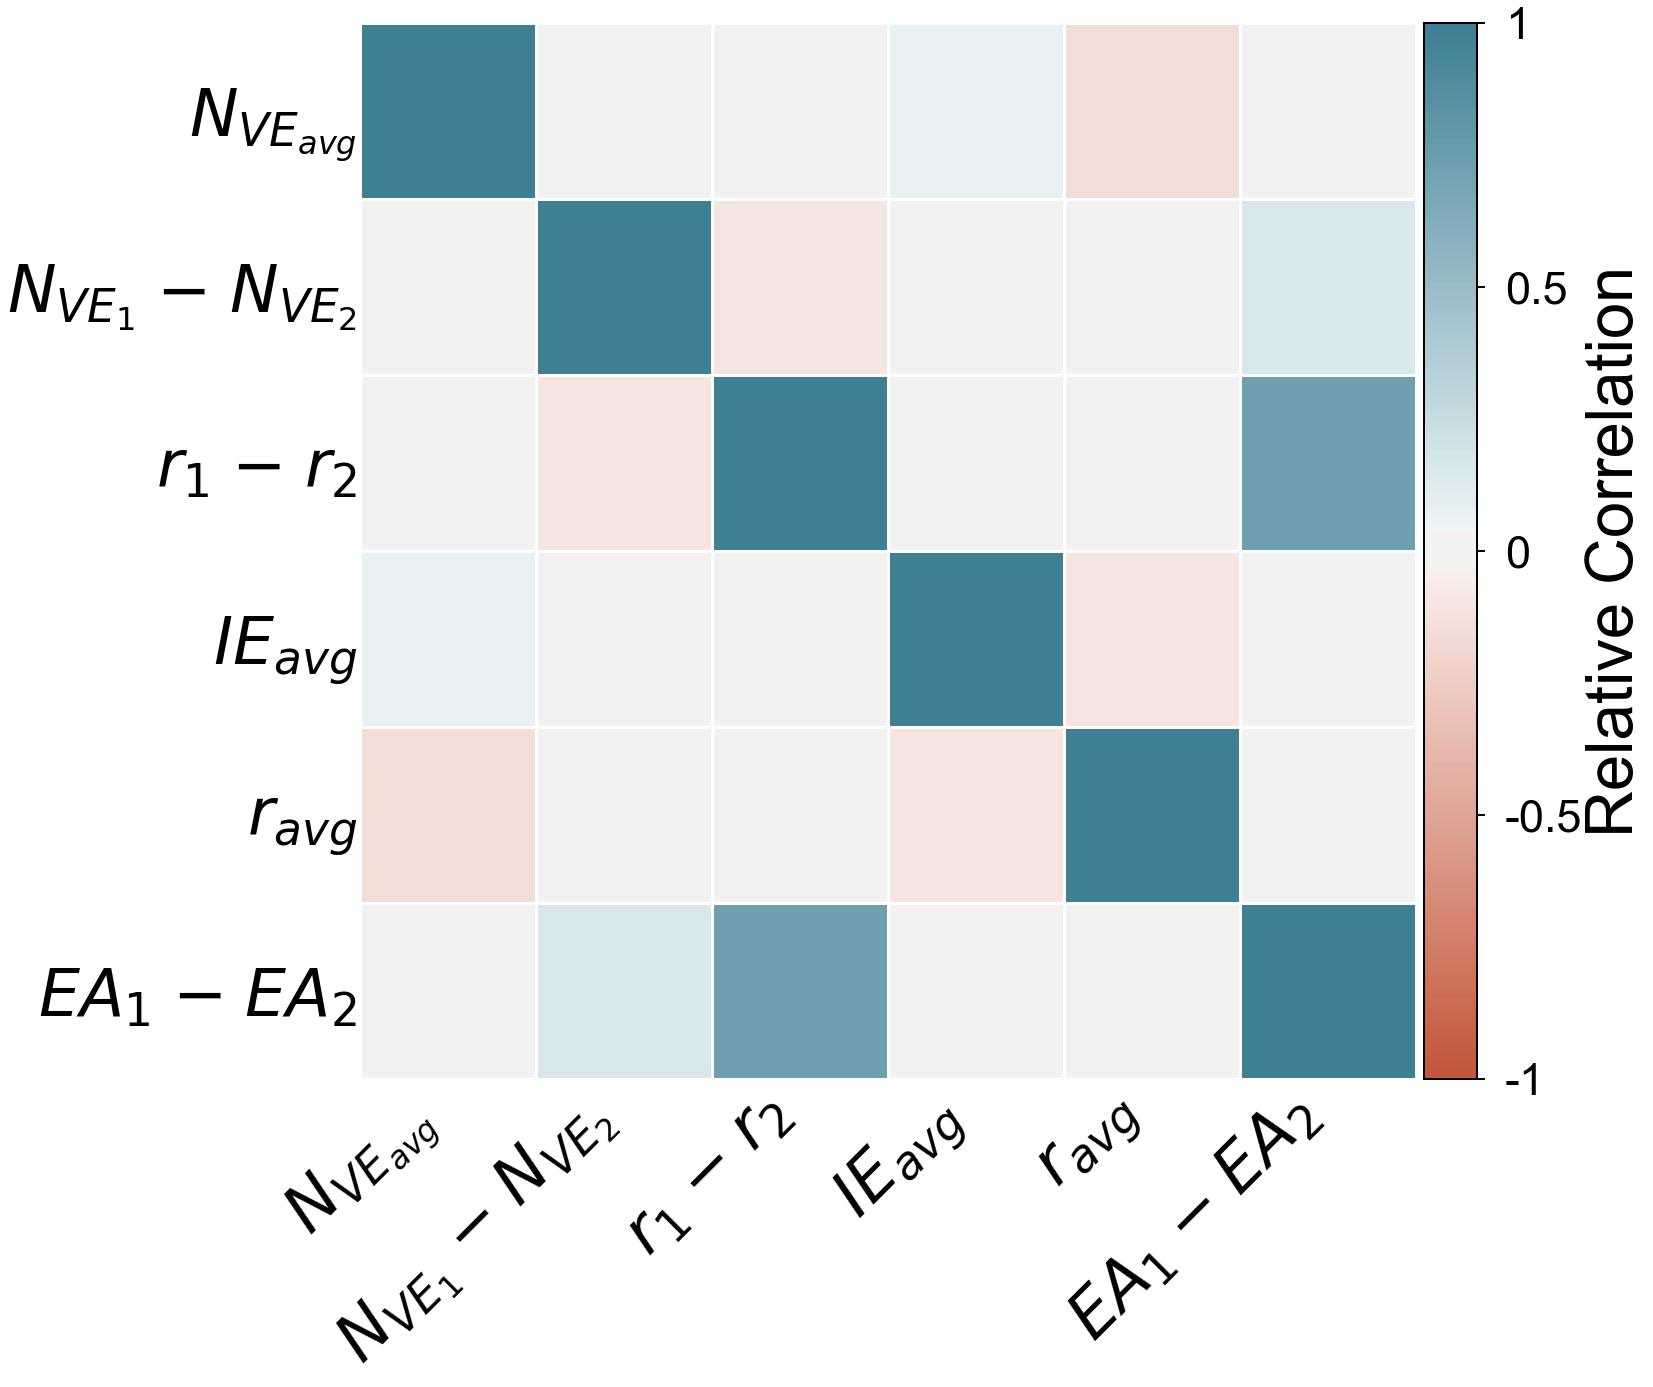

In [99]:
# Plot final correlation figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

corr_labels = ['$N_{VE_{avg}}$', '$N_{VE_{1}}$ $-$ $N_{VE_{2}}$', '$r_1$ $-$ $r_2$', '$IE_{avg}$', 
                     '$r_{avg}}$',  '$EA_{1}$ $-$ $EA_{2}$']

data = df_v9.iloc[:, :-1].corr()
data = data[['Average num of Valence Electron', 'num of Valence 1 minus num of Valence 2', 
                           'Covalent Radius 1 minus Covalent Radius 2', 'Average IE', 'Average Covalent Radius',
                           'EA 1 minus EA 2']]
data = data.reindex(['Average num of Valence Electron', 'num of Valence 1 minus num of Valence 2', 
                           'Covalent Radius 1 minus Covalent Radius 2', 'Average IE', 'Average Covalent Radius',
                           'EA 1 minus EA 2'])
#sns.set(font_scale=4)

ax = sns.heatmap(data, linewidth=2,
                 cmap = sns.diverging_palette(20, 220, n=220), square = True, vmin = -1, vmax = 1,
                 cbar=False)
plt.xticks(ha='right')
  
#ax.figure.axes[-1].yaxis.label.set_size(35)

divider = make_axes_locatable(ax) 
cax = divider.append_axes("right", size="5%", pad=0.1) 
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'], size=45)
cbar.ax.set_ylabel("Relative Correlation", fontsize = 65)
cbar.ax.tick_params(axis='y', which='major', length=8, width = 2, pad=20)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)


    
ax.set_xticklabels(corr_labels, rotation = 45, size = 65)
ax.set_yticklabels(corr_labels, rotation = 0, size = 65)

ax.tick_params(axis='x', labelcolor='black', labelsize = 65, width=0, length=0, color='black') 
ax.tick_params(axis='y', labelcolor='black', labelsize = 65, width=0, length=0, color='black') 

plt.savefig('{}dim_feature_correlation.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show()

# 4. XGBR Hyperparameter Tuning

In [100]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
import xgboost
import lightgbm

In [308]:
features = df_v9.iloc[:, 0:-1]
target = df_v9.iloc[:, -1]

In [309]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedKFold


# Defining XGBR hyperparameters
xgbr_grid = {
    
    'min_child_weight': [1, 5, 10],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.3, 1, 2],
    'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'colsample_bylevel': [0.1, 0.5, 0.8, 1],

}

# Defining fold parameters
fold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

In [310]:
# Performing Randomized CV search on XGBR
xgbr_grid_cv = GridSearchCV(estimator = xgbr, cv = fold,
            param_grid = xgbr_grid, n_jobs = -1, scoring='neg_root_mean_squared_error',
            verbose = 5, return_train_score = True)

"# Performing Randomized CV search on XGBR\nxgbr_grid_cv = GridSearchCV(estimator = xgbr, cv = fold,\n            param_grid = xgbr_grid, n_jobs = -1, scoring='neg_root_mean_squared_error',\n            verbose = 5, return_train_score = True)"

In [311]:
xgbr_grid_cv.fit(features, target)

'xgbr_grid_cv.fit(features, target)'

In [315]:
from sklearn.model_selection import cross_val_score

xgbr_optimized = xgbr_grid_cv.best_estimator_

rmse_score = cross_val_score(xgbr_optimized, features, target, cv = fold, scoring='neg_root_mean_squared_error')
mae_score = cross_val_score(xgbr_optimized, features, target, cv = fold, scoring='neg_mean_absolute_error')

"from sklearn.model_selection import cross_val_score\n\nxgbr_optimized = xgbr_grid_cv.best_estimator_\n\nrmse_score = cross_val_score(xgbr_optimized, features, target, cv = fold, scoring='neg_root_mean_squared_error')\nmae_score = cross_val_score(xgbr_optimized, features, target, cv = fold, scoring='neg_mean_absolute_error')"

In [316]:
optimized_xgbr_rmse = np.abs(rmse_score).mean()
optimized_xgbr_mae = np.abs(mae_score).mean()

'optimized_xgbr_rmse = np.abs(rmse_score).mean()\noptimized_xgbr_mae = np.abs(mae_score).mean()'

# 5. Analysis of Separation Ratios

In [364]:
from sklearn.model_selection import train_test_split

r2 = []
rmse = []
mae = []


for i in [0.5, 0.667, 0.75, 0.8, 0.83, 0.857, 0.875, 0.889, 0.9]:
    r2_temp = []
    rmse_temp = []
    mae_temp = []
    for j in range(50):
        X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = i, random_state = j)
        xgbr.fit(X_train, y_train)

        # Predicting training data
        train_data = X_train.copy()
        train_data['G_co (eV)'] = y_train.copy()
        train_data['prediction'] = xgbr.predict(train_data.iloc[:, :-1])    

        # Predicting testing data
        test_data = X_test.copy()
        test_data['G_co (eV)'] = y_test.copy()
        test_data['prediction'] = xgbr.predict(test_data.iloc[:, :-1])
        test_data['mae_error'] = np.abs(test_data['G_co (eV)'] - test_data['prediction'])
        test_data['rmse_error'] = (test_data['G_co (eV)'] - test_data['prediction']) ** 2

        mae_temp.append(test_data['mae_error'].mean())
        rmse_temp.append(np.sqrt(test_data['rmse_error'].mean()))

        x = pd.concat([train_data['G_co (eV)'], test_data['G_co (eV)']])
        y = pd.concat([train_data['prediction'], test_data['prediction']])

        # Calculate R Squared
        coeffs = np.polyfit(x, y, 1)
        p = np.poly1d(coeffs)

        ybar = np.sum(y) / len(y)
        ssreg = np.sum((p(x) - ybar) ** 2)
        sstot = np.sum((y - ybar) ** 2)
        Rsqr = ssreg / sstot

        r2_temp.append(Rsqr)
    
    r2.append(np.array(r2_temp).mean())
    rmse.append(np.array(rmse_temp).mean())
    mae.append(np.array(mae_temp).mean())

## Training/Testing Ratio Plot

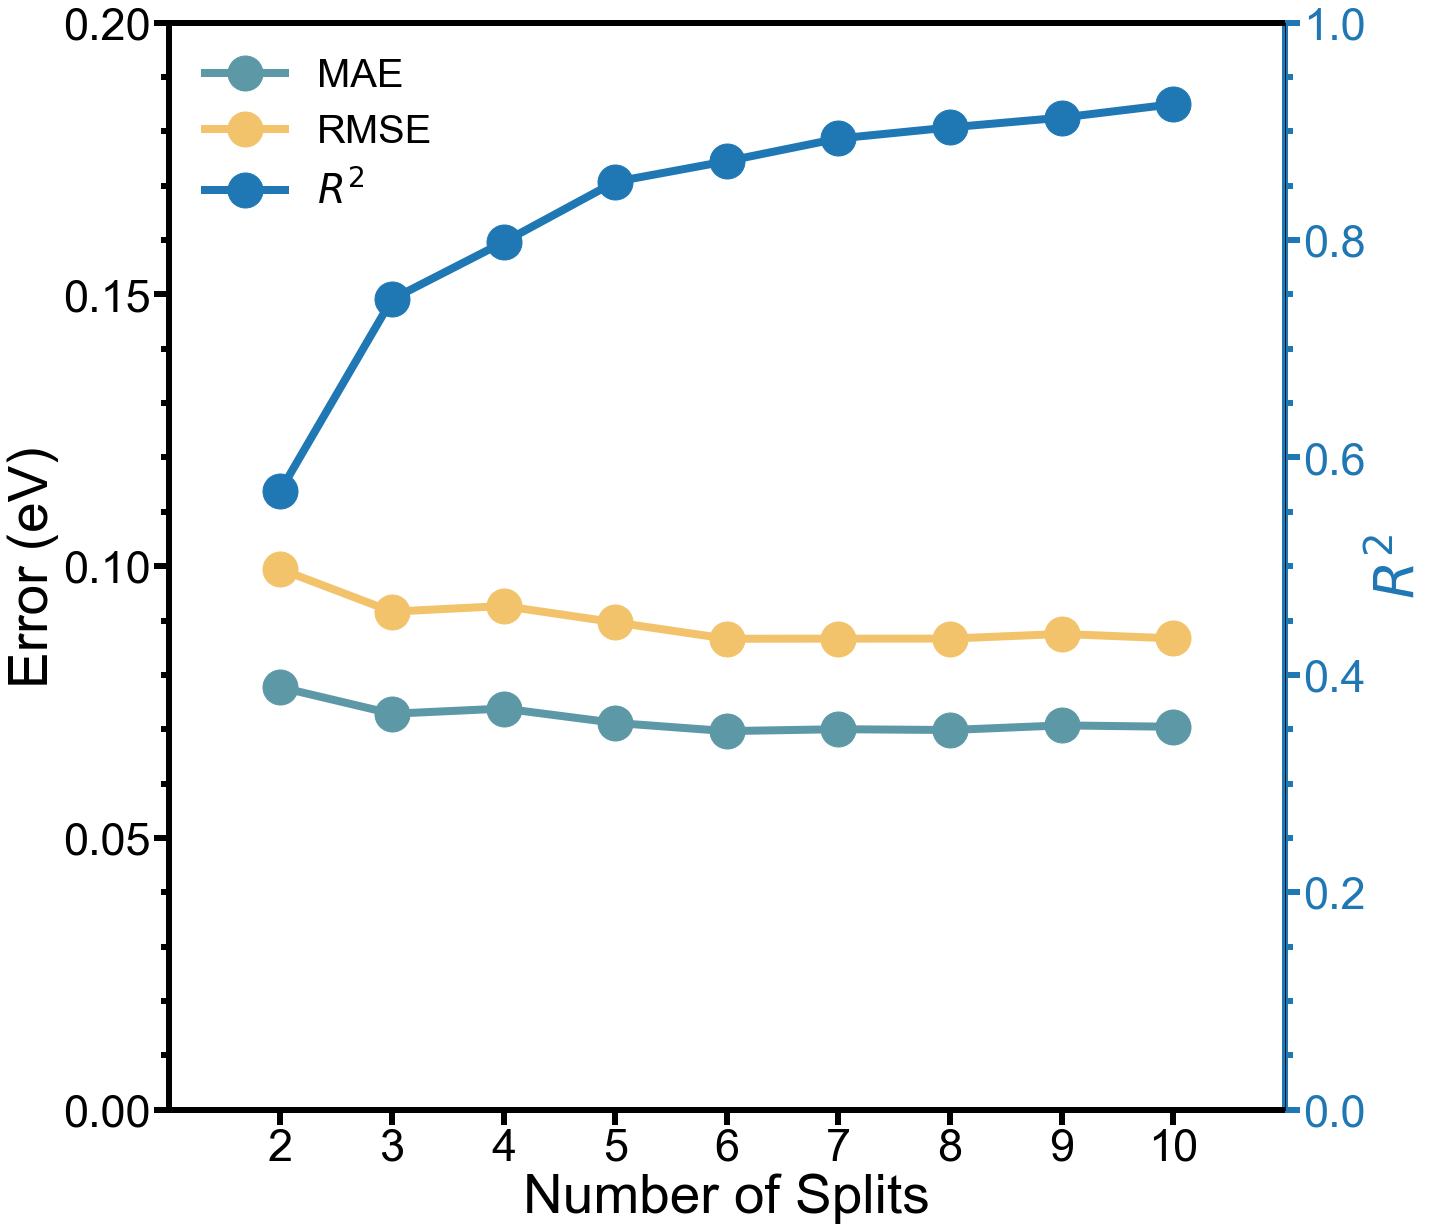

In [375]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

t = [2, 3, 4, 5, 6, 7, 8, 9, 10]
data1 = mae
data2 = r2
data3 = rmse

fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Splits', size = 55)
ax1.set_ylabel('Error (eV)', color='black', size = 55)
line1 = ax1.plot(t, data1, color='#5D98A6', marker = 'o', linewidth = 8, markersize = 35, label = 'MAE')
line2 = ax1.plot(t, data3, color='#F2C36B', marker = 'o', linewidth = 8, markersize = 35, label = 'RMSE')
ax1.tick_params(axis='y', labelcolor='black', labelsize = 45, width=6, length=15, color='black', which="major")
ax1.tick_params(axis='y', labelcolor='black', labelsize = 45, width=6, length=8, color='black', which="minor")

ax1.tick_params(axis='x', colors='black', labelsize = 45, width=6, length=15, color='black')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(6)


ax1.minorticks_on()
ax1.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax1.set_xticks([2, 3, 4, 5, 6, 7, 8, 9, 10])
ax1.set_xticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$R^2$', color=color, size = 55)  # we already handled the x-label with ax1
line3 = ax2.plot(t, data2, color=color, marker = 'o', linewidth = 8, markersize = 35, label = '$R^2$')
ax2.tick_params(axis='y', labelcolor=color, labelsize = 45, width=6, length=15, color=color, which='major')
ax2.tick_params(axis='y', labelcolor=color, labelsize = 45, width=6, length=8, color=color, which="minor")

lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0, fontsize=40, frameon=False)

for axis in ['top','bottom','left','right']:
    if axis == 'right':
        ax1.spines[axis].set_color(color)
    ax1.spines[axis].set_linewidth(6)

ax2.minorticks_on()
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlim(1, 11)
plt.ylim(0, 1);

plt.savefig('{}dim_train_split.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show()

# 6. Neural Network Implementation

In [117]:
from sklearn.model_selection import train_test_split

# Split training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.9, random_state = 30)

In [118]:
import time

# Training neural network to minimize RMSE
start = time.time()
model_history_rmse = train_model_rmse(X_train, y_train, num_cols = len(features.columns))
end = time.time()

print('Time taken to train this neural network was {} seconds'.format(int(end - start)))

Epoch 1/1600
1/1 [==============================] - ETA: 0s - loss: 0.2074
Epoch 00001: val_loss improved from inf to 0.20680, saving model to model_best_weights.h5
1/1 [==============================] - 0s 211ms/step - loss: 0.2074 - val_loss: 0.2068
Epoch 2/1600
1/1 [==============================] - ETA: 0s - loss: 0.1978
Epoch 00002: val_loss improved from 0.20680 to 0.20590, saving model to model_best_weights.h5
1/1 [==============================] - 0s 40ms/step - loss: 0.1978 - val_loss: 0.2059
Epoch 3/1600
1/1 [==============================] - ETA: 0s - loss: 0.2003
Epoch 00003: val_loss improved from 0.20590 to 0.20520, saving model to model_best_weights.h5
1/1 [==============================] - 0s 40ms/step - loss: 0.2003 - val_loss: 0.2052
Epoch 4/1600
1/1 [==============================] - ETA: 0s - loss: 0.1956
Epoch 00004: val_loss improved from 0.20520 to 0.20420, saving model to model_best_weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1956 - 

1/1 [==============================] - 0s 43ms/step - loss: 0.1573 - val_loss: 0.1723
Epoch 33/1600
1/1 [==============================] - ETA: 0s - loss: 0.1545
Epoch 00033: val_loss improved from 0.17233 to 0.17151, saving model to model_best_weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1545 - val_loss: 0.1715
Epoch 34/1600
1/1 [==============================] - ETA: 0s - loss: 0.1514
Epoch 00034: val_loss improved from 0.17151 to 0.17039, saving model to model_best_weights.h5
1/1 [==============================] - 0s 40ms/step - loss: 0.1514 - val_loss: 0.1704
Epoch 35/1600
1/1 [==============================] - ETA: 0s - loss: 0.1533
Epoch 00035: val_loss did not improve from 0.17039
1/1 [==============================] - 0s 14ms/step - loss: 0.1533 - val_loss: 0.1706
Epoch 36/1600
1/1 [==============================] - ETA: 0s - loss: 0.1487
Epoch 00036: val_loss improved from 0.17039 to 0.17006, saving model to model_best_weights.h5
1/1 [==============

Epoch 99/1600
1/1 [==============================] - ETA: 0s - loss: 0.1002
Epoch 00099: val_loss improved from 0.10787 to 0.10757, saving model to model_best_weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1002 - val_loss: 0.1076
Epoch 100/1600
1/1 [==============================] - ETA: 0s - loss: 0.1016
Epoch 00100: val_loss improved from 0.10757 to 0.10757, saving model to model_best_weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.1016 - val_loss: 0.1076
Epoch 101/1600
1/1 [==============================] - ETA: 0s - loss: 0.1017
Epoch 00101: val_loss improved from 0.10757 to 0.10746, saving model to model_best_weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.1017 - val_loss: 0.1075
Epoch 102/1600
1/1 [==============================] - ETA: 0s - loss: 0.1094
Epoch 00102: val_loss did not improve from 0.10746
1/1 [==============================] - 0s 13ms/step - loss: 0.1094 - val_loss: 0.1079
Epoch 103/1600
1

1/1 [==============================] - 0s 39ms/step - loss: 0.0922 - val_loss: 0.0994
Epoch 136/1600
1/1 [==============================] - ETA: 0s - loss: 0.0861
Epoch 00136: val_loss improved from 0.09935 to 0.09801, saving model to model_best_weights.h5
1/1 [==============================] - 0s 41ms/step - loss: 0.0861 - val_loss: 0.0980
Epoch 137/1600
1/1 [==============================] - ETA: 0s - loss: 0.0874
Epoch 00137: val_loss improved from 0.09801 to 0.09734, saving model to model_best_weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.0874 - val_loss: 0.0973
Epoch 138/1600
1/1 [==============================] - ETA: 0s - loss: 0.0943
Epoch 00138: val_loss did not improve from 0.09734
1/1 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.0983
Epoch 139/1600
1/1 [==============================] - ETA: 0s - loss: 0.0875
Epoch 00139: val_loss did not improve from 0.09734
1/1 [==============================] - 0s 13ms/step - loss

1/1 [==============================] - ETA: 0s - loss: 0.0794
Epoch 00210: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0794 - val_loss: 0.1699
Epoch 211/1600
1/1 [==============================] - ETA: 0s - loss: 0.0771
Epoch 00211: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0771 - val_loss: 0.1814
Epoch 212/1600
1/1 [==============================] - ETA: 0s - loss: 0.0790
Epoch 00212: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0790 - val_loss: 0.1774
Epoch 213/1600
1/1 [==============================] - ETA: 0s - loss: 0.0840
Epoch 00213: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0840 - val_loss: 0.1816
Epoch 214/1600
1/1 [==============================] - ETA: 0s - loss: 0.0787
Epoch 00214: val_loss did not improve from 0.09107
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0811
Epoch 00286: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0811 - val_loss: 0.1246
Epoch 287/1600
1/1 [==============================] - ETA: 0s - loss: 0.0746
Epoch 00287: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0746 - val_loss: 0.1244
Epoch 288/1600
1/1 [==============================] - ETA: 0s - loss: 0.0851
Epoch 00288: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0851 - val_loss: 0.1220
Epoch 289/1600
1/1 [==============================] - ETA: 0s - loss: 0.0842
Epoch 00289: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0842 - val_loss: 0.1200
Epoch 290/1600
1/1 [==============================] - ETA: 0s - loss: 0.0835
Epoch 00290: val_loss did not improve from 0.09107
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0782
Epoch 00362: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0782 - val_loss: 0.0939
Epoch 363/1600
1/1 [==============================] - ETA: 0s - loss: 0.0840
Epoch 00363: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0840 - val_loss: 0.0931
Epoch 364/1600
1/1 [==============================] - ETA: 0s - loss: 0.0832
Epoch 00364: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 14ms/step - loss: 0.0832 - val_loss: 0.0950
Epoch 365/1600
1/1 [==============================] - ETA: 0s - loss: 0.0876
Epoch 00365: val_loss did not improve from 0.09107
1/1 [==============================] - 0s 13ms/step - loss: 0.0876 - val_loss: 0.0973
Epoch 366/1600
1/1 [==============================] - ETA: 0s - loss: 0.0747
Epoch 00366: val_loss did not improve from 0.09107
1/1 [==========================

Epoch 400/1600
1/1 [==============================] - ETA: 0s - loss: 0.0870
Epoch 00400: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 13ms/step - loss: 0.0870 - val_loss: 0.1025
Epoch 401/1600
1/1 [==============================] - ETA: 0s - loss: 0.0737
Epoch 00401: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 13ms/step - loss: 0.0737 - val_loss: 0.1019
Epoch 402/1600
1/1 [==============================] - ETA: 0s - loss: 0.0667
Epoch 00402: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 13ms/step - loss: 0.0667 - val_loss: 0.1020
Epoch 403/1600
1/1 [==============================] - ETA: 0s - loss: 0.0731
Epoch 00403: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 13ms/step - loss: 0.0731 - val_loss: 0.1045
Epoch 404/1600
1/1 [==============================] - ETA: 0s - loss: 0.0744
Epoch 00404: val_loss did not improve from 0.08885
1/1 [===========

1/1 [==============================] - ETA: 0s - loss: 0.0719
Epoch 00476: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 14ms/step - loss: 0.0719 - val_loss: 0.0945
Epoch 477/1600
1/1 [==============================] - ETA: 0s - loss: 0.0758
Epoch 00477: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 13ms/step - loss: 0.0758 - val_loss: 0.0935
Epoch 478/1600
1/1 [==============================] - ETA: 0s - loss: 0.0719
Epoch 00478: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 14ms/step - loss: 0.0719 - val_loss: 0.0932
Epoch 479/1600
1/1 [==============================] - ETA: 0s - loss: 0.0732
Epoch 00479: val_loss did not improve from 0.08885
1/1 [==============================] - 0s 14ms/step - loss: 0.0732 - val_loss: 0.0951
Epoch 480/1600
1/1 [==============================] - ETA: 0s - loss: 0.0646
Epoch 00480: val_loss did not improve from 0.08885
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0708
Epoch 00551: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0708 - val_loss: 0.0978
Epoch 552/1600
1/1 [==============================] - ETA: 0s - loss: 0.0680
Epoch 00552: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0680 - val_loss: 0.0974
Epoch 553/1600
1/1 [==============================] - ETA: 0s - loss: 0.0735
Epoch 00553: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0735 - val_loss: 0.1006
Epoch 554/1600
1/1 [==============================] - ETA: 0s - loss: 0.0719
Epoch 00554: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0719 - val_loss: 0.1007
Epoch 555/1600
1/1 [==============================] - ETA: 0s - loss: 0.0704
Epoch 00555: val_loss did not improve from 0.07610
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0792
Epoch 00627: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 14ms/step - loss: 0.0792 - val_loss: 0.0961
Epoch 628/1600
1/1 [==============================] - ETA: 0s - loss: 0.0730
Epoch 00628: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0730 - val_loss: 0.1001
Epoch 629/1600
1/1 [==============================] - ETA: 0s - loss: 0.0940
Epoch 00629: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0940 - val_loss: 0.1046
Epoch 630/1600
1/1 [==============================] - ETA: 0s - loss: 0.0841
Epoch 00630: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0841 - val_loss: 0.1059
Epoch 631/1600
1/1 [==============================] - ETA: 0s - loss: 0.0818
Epoch 00631: val_loss did not improve from 0.07610
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0806
Epoch 00703: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0806 - val_loss: 0.0943
Epoch 704/1600
1/1 [==============================] - ETA: 0s - loss: 0.0745
Epoch 00704: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0745 - val_loss: 0.0937
Epoch 705/1600
1/1 [==============================] - ETA: 0s - loss: 0.0723
Epoch 00705: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0723 - val_loss: 0.0919
Epoch 706/1600
1/1 [==============================] - ETA: 0s - loss: 0.0775
Epoch 00706: val_loss did not improve from 0.07610
1/1 [==============================] - 0s 13ms/step - loss: 0.0775 - val_loss: 0.0909
Epoch 707/1600
1/1 [==============================] - ETA: 0s - loss: 0.0755
Epoch 00707: val_loss did not improve from 0.07610
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0742
Epoch 00779: val_loss did not improve from 0.07495
1/1 [==============================] - 0s 13ms/step - loss: 0.0742 - val_loss: 0.0922
Epoch 780/1600
1/1 [==============================] - ETA: 0s - loss: 0.0774
Epoch 00780: val_loss did not improve from 0.07495
1/1 [==============================] - 0s 13ms/step - loss: 0.0774 - val_loss: 0.0880
Epoch 781/1600
1/1 [==============================] - ETA: 0s - loss: 0.0728
Epoch 00781: val_loss did not improve from 0.07495
1/1 [==============================] - 0s 13ms/step - loss: 0.0728 - val_loss: 0.0826
Epoch 782/1600
1/1 [==============================] - ETA: 0s - loss: 0.0736
Epoch 00782: val_loss did not improve from 0.07495
1/1 [==============================] - 0s 13ms/step - loss: 0.0736 - val_loss: 0.0828
Epoch 783/1600
1/1 [==============================] - ETA: 0s - loss: 0.0854
Epoch 00783: val_loss did not improve from 0.07495
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0789
Epoch 00854: val_loss did not improve from 0.05974
1/1 [==============================] - 0s 14ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 855/1600
1/1 [==============================] - ETA: 0s - loss: 0.0650
Epoch 00855: val_loss did not improve from 0.05974
1/1 [==============================] - 0s 13ms/step - loss: 0.0650 - val_loss: 0.0775
Epoch 856/1600
1/1 [==============================] - ETA: 0s - loss: 0.0879
Epoch 00856: val_loss did not improve from 0.05974
1/1 [==============================] - 0s 13ms/step - loss: 0.0879 - val_loss: 0.0731
Epoch 857/1600
1/1 [==============================] - ETA: 0s - loss: 0.0842
Epoch 00857: val_loss did not improve from 0.05974
1/1 [==============================] - 0s 14ms/step - loss: 0.0842 - val_loss: 0.0705
Epoch 858/1600
1/1 [==============================] - ETA: 0s - loss: 0.0689
Epoch 00858: val_loss did not improve from 0.05974
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0721
Epoch 00930: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0721 - val_loss: 0.1005
Epoch 931/1600
1/1 [==============================] - ETA: 0s - loss: 0.0827
Epoch 00931: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0827 - val_loss: 0.1002
Epoch 932/1600
1/1 [==============================] - ETA: 0s - loss: 0.0800
Epoch 00932: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0800 - val_loss: 0.0994
Epoch 933/1600
1/1 [==============================] - ETA: 0s - loss: 0.0793
Epoch 00933: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0793 - val_loss: 0.0985
Epoch 934/1600
1/1 [==============================] - ETA: 0s - loss: 0.0690
Epoch 00934: val_loss did not improve from 0.05426
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0723
Epoch 01006: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0723 - val_loss: 0.0877
Epoch 1007/1600
1/1 [==============================] - ETA: 0s - loss: 0.0720
Epoch 01007: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0720 - val_loss: 0.0906
Epoch 1008/1600
1/1 [==============================] - ETA: 0s - loss: 0.0700
Epoch 01008: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0700 - val_loss: 0.0911
Epoch 1009/1600
1/1 [==============================] - ETA: 0s - loss: 0.0765
Epoch 01009: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0765 - val_loss: 0.0913
Epoch 1010/1600
1/1 [==============================] - ETA: 0s - loss: 0.0707
Epoch 01010: val_loss did not improve from 0.05426
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0590
Epoch 01082: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0590 - val_loss: 0.1017
Epoch 1083/1600
1/1 [==============================] - ETA: 0s - loss: 0.0650
Epoch 01083: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0650 - val_loss: 0.1038
Epoch 1084/1600
1/1 [==============================] - ETA: 0s - loss: 0.0656
Epoch 01084: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0656 - val_loss: 0.1074
Epoch 1085/1600
1/1 [==============================] - ETA: 0s - loss: 0.0693
Epoch 01085: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0693 - val_loss: 0.1081
Epoch 1086/1600
1/1 [==============================] - ETA: 0s - loss: 0.0848
Epoch 01086: val_loss did not improve from 0.05426
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0614
Epoch 01158: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 15ms/step - loss: 0.0614 - val_loss: 0.1039
Epoch 1159/1600
1/1 [==============================] - ETA: 0s - loss: 0.0703
Epoch 01159: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0703 - val_loss: 0.0973
Epoch 1160/1600
1/1 [==============================] - ETA: 0s - loss: 0.0612
Epoch 01160: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0888
Epoch 1161/1600
1/1 [==============================] - ETA: 0s - loss: 0.0678
Epoch 01161: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 14ms/step - loss: 0.0678 - val_loss: 0.0766
Epoch 1162/1600
1/1 [==============================] - ETA: 0s - loss: 0.0615
Epoch 01162: val_loss did not improve from 0.05426
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0747
Epoch 01234: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0747 - val_loss: 0.0930
Epoch 1235/1600
1/1 [==============================] - ETA: 0s - loss: 0.0690
Epoch 01235: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0690 - val_loss: 0.0926
Epoch 1236/1600
1/1 [==============================] - ETA: 0s - loss: 0.0734
Epoch 01236: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0734 - val_loss: 0.0948
Epoch 1237/1600
1/1 [==============================] - ETA: 0s - loss: 0.0763
Epoch 01237: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0763 - val_loss: 0.0924
Epoch 1238/1600
1/1 [==============================] - ETA: 0s - loss: 0.0823
Epoch 01238: val_loss did not improve from 0.05426
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0712
Epoch 01310: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0712 - val_loss: 0.0824
Epoch 1311/1600
1/1 [==============================] - ETA: 0s - loss: 0.0773
Epoch 01311: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0773 - val_loss: 0.0898
Epoch 1312/1600
1/1 [==============================] - ETA: 0s - loss: 0.0668
Epoch 01312: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0668 - val_loss: 0.0921
Epoch 1313/1600
1/1 [==============================] - ETA: 0s - loss: 0.0659
Epoch 01313: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0659 - val_loss: 0.0948
Epoch 1314/1600
1/1 [==============================] - ETA: 0s - loss: 0.0674
Epoch 01314: val_loss did not improve from 0.05426
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0627
Epoch 01386: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.1091
Epoch 1387/1600
1/1 [==============================] - ETA: 0s - loss: 0.0687
Epoch 01387: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0687 - val_loss: 0.1090
Epoch 1388/1600
1/1 [==============================] - ETA: 0s - loss: 0.0767
Epoch 01388: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0767 - val_loss: 0.1078
Epoch 1389/1600
1/1 [==============================] - ETA: 0s - loss: 0.0776
Epoch 01389: val_loss did not improve from 0.05426
1/1 [==============================] - 0s 13ms/step - loss: 0.0776 - val_loss: 0.1066
Epoch 1390/1600
1/1 [==============================] - ETA: 0s - loss: 0.0677
Epoch 01390: val_loss did not improve from 0.05426
1/1 [======================

Epoch 1462/1600
1/1 [==============================] - ETA: 0s - loss: 0.0696
Epoch 01462: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0696 - val_loss: 0.0710
Epoch 1463/1600
1/1 [==============================] - ETA: 0s - loss: 0.0758
Epoch 01463: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0758 - val_loss: 0.0672
Epoch 1464/1600
1/1 [==============================] - ETA: 0s - loss: 0.0634
Epoch 01464: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0634 - val_loss: 0.0564
Epoch 1465/1600
1/1 [==============================] - ETA: 0s - loss: 0.0668
Epoch 01465: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0668 - val_loss: 0.0540
Epoch 1466/1600
1/1 [==============================] - ETA: 0s - loss: 0.0615
Epoch 01466: val_loss did not improve from 0.04956
1/1 [======

1/1 [==============================] - ETA: 0s - loss: 0.0594
Epoch 01538: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0594 - val_loss: 0.0839
Epoch 1539/1600
1/1 [==============================] - ETA: 0s - loss: 0.0731
Epoch 01539: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0731 - val_loss: 0.0901
Epoch 1540/1600
1/1 [==============================] - ETA: 0s - loss: 0.0641
Epoch 01540: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0641 - val_loss: 0.0934
Epoch 1541/1600
1/1 [==============================] - ETA: 0s - loss: 0.0621
Epoch 01541: val_loss did not improve from 0.04956
1/1 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0947
Epoch 1542/1600
1/1 [==============================] - ETA: 0s - loss: 0.0649
Epoch 01542: val_loss did not improve from 0.04956
1/1 [======================

In [119]:
# Find the minimum RMSE
nn_RMSE = min(model_history_rmse.history['val_loss'])

In [120]:
# Training neural network to minimize MAE
start = time.time()
model_history_mae = train_model_mae(X_train, y_train, num_cols = len(features.columns))
end = time.time()

print('Time taken to train this neural network was {} seconds'.format(int(end - start)))

Epoch 1/1600
1/1 [==============================] - ETA: 0s - loss: 0.1764
Epoch 00001: val_loss improved from inf to 0.18763, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 133ms/step - loss: 0.1764 - val_loss: 0.1876
Epoch 2/1600
1/1 [==============================] - ETA: 0s - loss: 0.1606
Epoch 00002: val_loss improved from 0.18763 to 0.18661, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1606 - val_loss: 0.1866
Epoch 3/1600
1/1 [==============================] - ETA: 0s - loss: 0.1673
Epoch 00003: val_loss improved from 0.18661 to 0.18572, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 41ms/step - loss: 0.1673 - val_loss: 0.1857
Epoch 4/1600
1/1 [==============================] - ETA: 0s - loss: 0.1593
Epoch 00004: val_loss improved from 0.18572 to 0.18462, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 40ms/step -

1/1 [==============================] - ETA: 0s - loss: 0.1036
Epoch 00066: val_loss improved from 0.09311 to 0.09230, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1036 - val_loss: 0.0923
Epoch 67/1600
1/1 [==============================] - ETA: 0s - loss: 0.1058
Epoch 00067: val_loss improved from 0.09230 to 0.08988, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1058 - val_loss: 0.0899
Epoch 68/1600
1/1 [==============================] - ETA: 0s - loss: 0.1041
Epoch 00068: val_loss improved from 0.08988 to 0.08968, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.1041 - val_loss: 0.0897
Epoch 69/1600
1/1 [==============================] - ETA: 0s - loss: 0.1030
Epoch 00069: val_loss improved from 0.08968 to 0.08725, saving model to model_best_weights_mae.h5
1/1 [==============================] - 0s 38ms/step - loss: 

Epoch 137/1600
1/1 [==============================] - ETA: 0s - loss: 0.0764
Epoch 00137: val_loss did not improve from 0.05732
1/1 [==============================] - 0s 13ms/step - loss: 0.0764 - val_loss: 0.0619
Epoch 138/1600
1/1 [==============================] - ETA: 0s - loss: 0.0668
Epoch 00138: val_loss did not improve from 0.05732
1/1 [==============================] - 0s 13ms/step - loss: 0.0668 - val_loss: 0.0613
Epoch 139/1600
1/1 [==============================] - ETA: 0s - loss: 0.0689
Epoch 00139: val_loss did not improve from 0.05732
1/1 [==============================] - 0s 13ms/step - loss: 0.0689 - val_loss: 0.0607
Epoch 140/1600
1/1 [==============================] - ETA: 0s - loss: 0.0726
Epoch 00140: val_loss did not improve from 0.05732
1/1 [==============================] - 0s 13ms/step - loss: 0.0726 - val_loss: 0.0598
Epoch 141/1600
1/1 [==============================] - ETA: 0s - loss: 0.0672
Epoch 00141: val_loss did not improve from 0.05732
1/1 [===========

Epoch 175/1600
1/1 [==============================] - ETA: 0s - loss: 0.0750
Epoch 00175: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0750 - val_loss: 0.0680
Epoch 176/1600
1/1 [==============================] - ETA: 0s - loss: 0.0605
Epoch 00176: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0605 - val_loss: 0.0712
Epoch 177/1600
1/1 [==============================] - ETA: 0s - loss: 0.0642
Epoch 00177: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0642 - val_loss: 0.0733
Epoch 178/1600
1/1 [==============================] - ETA: 0s - loss: 0.0649
Epoch 00178: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0649 - val_loss: 0.0740
Epoch 179/1600
1/1 [==============================] - ETA: 0s - loss: 0.0676
Epoch 00179: val_loss did not improve from 0.05622
1/1 [===========

1/1 [==============================] - ETA: 0s - loss: 0.0685
Epoch 00251: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0685 - val_loss: 0.0877
Epoch 252/1600
1/1 [==============================] - ETA: 0s - loss: 0.0636
Epoch 00252: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0636 - val_loss: 0.0848
Epoch 253/1600
1/1 [==============================] - ETA: 0s - loss: 0.0623
Epoch 00253: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0822
Epoch 254/1600
1/1 [==============================] - ETA: 0s - loss: 0.0602
Epoch 00254: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0602 - val_loss: 0.0817
Epoch 255/1600
1/1 [==============================] - ETA: 0s - loss: 0.0692
Epoch 00255: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0632
Epoch 00327: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0632 - val_loss: 0.0711
Epoch 328/1600
1/1 [==============================] - ETA: 0s - loss: 0.0596
Epoch 00328: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0596 - val_loss: 0.0715
Epoch 329/1600
1/1 [==============================] - ETA: 0s - loss: 0.0624
Epoch 00329: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0708
Epoch 330/1600
1/1 [==============================] - ETA: 0s - loss: 0.0569
Epoch 00330: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0569 - val_loss: 0.0694
Epoch 331/1600
1/1 [==============================] - ETA: 0s - loss: 0.0605
Epoch 00331: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0577
Epoch 00403: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0577 - val_loss: 0.0818
Epoch 404/1600
1/1 [==============================] - ETA: 0s - loss: 0.0656
Epoch 00404: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0656 - val_loss: 0.0853
Epoch 405/1600
1/1 [==============================] - ETA: 0s - loss: 0.0634
Epoch 00405: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0634 - val_loss: 0.0835
Epoch 406/1600
1/1 [==============================] - ETA: 0s - loss: 0.0612
Epoch 00406: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0834
Epoch 407/1600
1/1 [==============================] - ETA: 0s - loss: 0.0660
Epoch 00407: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0574
Epoch 00479: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0574 - val_loss: 0.0858
Epoch 480/1600
1/1 [==============================] - ETA: 0s - loss: 0.0571
Epoch 00480: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0571 - val_loss: 0.0817
Epoch 481/1600
1/1 [==============================] - ETA: 0s - loss: 0.0523
Epoch 00481: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0523 - val_loss: 0.0781
Epoch 482/1600
1/1 [==============================] - ETA: 0s - loss: 0.0697
Epoch 00482: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0697 - val_loss: 0.0774
Epoch 483/1600
1/1 [==============================] - ETA: 0s - loss: 0.0661
Epoch 00483: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0527
Epoch 00555: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0527 - val_loss: 0.0973
Epoch 556/1600
1/1 [==============================] - ETA: 0s - loss: 0.0525
Epoch 00556: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0525 - val_loss: 0.0992
Epoch 557/1600
1/1 [==============================] - ETA: 0s - loss: 0.0609
Epoch 00557: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0609 - val_loss: 0.0981
Epoch 558/1600
1/1 [==============================] - ETA: 0s - loss: 0.0647
Epoch 00558: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0647 - val_loss: 0.0985
Epoch 559/1600
1/1 [==============================] - ETA: 0s - loss: 0.0522
Epoch 00559: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0553
Epoch 00631: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0553 - val_loss: 0.0951
Epoch 632/1600
1/1 [==============================] - ETA: 0s - loss: 0.0529
Epoch 00632: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0529 - val_loss: 0.0882
Epoch 633/1600
1/1 [==============================] - ETA: 0s - loss: 0.0456
Epoch 00633: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0456 - val_loss: 0.0855
Epoch 634/1600
1/1 [==============================] - ETA: 0s - loss: 0.0612
Epoch 00634: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0832
Epoch 635/1600
1/1 [==============================] - ETA: 0s - loss: 0.0548
Epoch 00635: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0543
Epoch 00707: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0543 - val_loss: 0.0856
Epoch 708/1600
1/1 [==============================] - ETA: 0s - loss: 0.0543
Epoch 00708: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0543 - val_loss: 0.0872
Epoch 709/1600
1/1 [==============================] - ETA: 0s - loss: 0.0563
Epoch 00709: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0563 - val_loss: 0.0858
Epoch 710/1600
1/1 [==============================] - ETA: 0s - loss: 0.0591
Epoch 00710: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0591 - val_loss: 0.0889
Epoch 711/1600
1/1 [==============================] - ETA: 0s - loss: 0.0549
Epoch 00711: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0528
Epoch 00783: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0528 - val_loss: 0.0876
Epoch 784/1600
1/1 [==============================] - ETA: 0s - loss: 0.0521
Epoch 00784: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0521 - val_loss: 0.0875
Epoch 785/1600
1/1 [==============================] - ETA: 0s - loss: 0.0621
Epoch 00785: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0887
Epoch 786/1600
1/1 [==============================] - ETA: 0s - loss: 0.0661
Epoch 00786: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0661 - val_loss: 0.0906
Epoch 787/1600
1/1 [==============================] - ETA: 0s - loss: 0.0542
Epoch 00787: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0592
Epoch 00859: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0592 - val_loss: 0.0787
Epoch 860/1600
1/1 [==============================] - ETA: 0s - loss: 0.0500
Epoch 00860: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0500 - val_loss: 0.0814
Epoch 861/1600
1/1 [==============================] - ETA: 0s - loss: 0.0647
Epoch 00861: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0647 - val_loss: 0.0874
Epoch 862/1600
1/1 [==============================] - ETA: 0s - loss: 0.0534
Epoch 00862: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0534 - val_loss: 0.0880
Epoch 863/1600
1/1 [==============================] - ETA: 0s - loss: 0.0559
Epoch 00863: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0526
Epoch 00935: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0526 - val_loss: 0.0902
Epoch 936/1600
1/1 [==============================] - ETA: 0s - loss: 0.0662
Epoch 00936: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0662 - val_loss: 0.0926
Epoch 937/1600
1/1 [==============================] - ETA: 0s - loss: 0.0556
Epoch 00937: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0556 - val_loss: 0.0925
Epoch 938/1600
1/1 [==============================] - ETA: 0s - loss: 0.0564
Epoch 00938: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0564 - val_loss: 0.0896
Epoch 939/1600
1/1 [==============================] - ETA: 0s - loss: 0.0557
Epoch 00939: val_loss did not improve from 0.05622
1/1 [==========================

1/1 [==============================] - ETA: 0s - loss: 0.0578
Epoch 01011: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0578 - val_loss: 0.0831
Epoch 1012/1600
1/1 [==============================] - ETA: 0s - loss: 0.0484
Epoch 01012: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0484 - val_loss: 0.0834
Epoch 1013/1600
1/1 [==============================] - ETA: 0s - loss: 0.0544
Epoch 01013: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0544 - val_loss: 0.0909
Epoch 1014/1600
1/1 [==============================] - ETA: 0s - loss: 0.0549
Epoch 01014: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0549 - val_loss: 0.0974
Epoch 1015/1600
1/1 [==============================] - ETA: 0s - loss: 0.0638
Epoch 01015: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0671
Epoch 01087: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0671 - val_loss: 0.0903
Epoch 1088/1600
1/1 [==============================] - ETA: 0s - loss: 0.0524
Epoch 01088: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0524 - val_loss: 0.0863
Epoch 1089/1600
1/1 [==============================] - ETA: 0s - loss: 0.0528
Epoch 01089: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0528 - val_loss: 0.0868
Epoch 1090/1600
1/1 [==============================] - ETA: 0s - loss: 0.0533
Epoch 01090: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0533 - val_loss: 0.0872
Epoch 1091/1600
1/1 [==============================] - ETA: 0s - loss: 0.0474
Epoch 01091: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0588
Epoch 01163: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0588 - val_loss: 0.0976
Epoch 1164/1600
1/1 [==============================] - ETA: 0s - loss: 0.0648
Epoch 01164: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0648 - val_loss: 0.0998
Epoch 1165/1600
1/1 [==============================] - ETA: 0s - loss: 0.0571
Epoch 01165: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0571 - val_loss: 0.1002
Epoch 1166/1600
1/1 [==============================] - ETA: 0s - loss: 0.0621
Epoch 01166: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0999
Epoch 1167/1600
1/1 [==============================] - ETA: 0s - loss: 0.0541
Epoch 01167: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0528
Epoch 01239: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0528 - val_loss: 0.0914
Epoch 1240/1600
1/1 [==============================] - ETA: 0s - loss: 0.0558
Epoch 01240: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0558 - val_loss: 0.0865
Epoch 1241/1600
1/1 [==============================] - ETA: 0s - loss: 0.0538
Epoch 01241: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0538 - val_loss: 0.0850
Epoch 1242/1600
1/1 [==============================] - ETA: 0s - loss: 0.0586
Epoch 01242: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0586 - val_loss: 0.0800
Epoch 1243/1600
1/1 [==============================] - ETA: 0s - loss: 0.0499
Epoch 01243: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0513
Epoch 01315: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0513 - val_loss: 0.1070
Epoch 1316/1600
1/1 [==============================] - ETA: 0s - loss: 0.0570
Epoch 01316: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0570 - val_loss: 0.1083
Epoch 1317/1600
1/1 [==============================] - ETA: 0s - loss: 0.0557
Epoch 01317: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0557 - val_loss: 0.1127
Epoch 1318/1600
1/1 [==============================] - ETA: 0s - loss: 0.0436
Epoch 01318: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0436 - val_loss: 0.1082
Epoch 1319/1600
1/1 [==============================] - ETA: 0s - loss: 0.0440
Epoch 01319: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0573
Epoch 01391: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0573 - val_loss: 0.0891
Epoch 1392/1600
1/1 [==============================] - ETA: 0s - loss: 0.0514
Epoch 01392: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0514 - val_loss: 0.0865
Epoch 1393/1600
1/1 [==============================] - ETA: 0s - loss: 0.0560
Epoch 01393: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0560 - val_loss: 0.0845
Epoch 1394/1600
1/1 [==============================] - ETA: 0s - loss: 0.0597
Epoch 01394: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0597 - val_loss: 0.0829
Epoch 1395/1600
1/1 [==============================] - ETA: 0s - loss: 0.0547
Epoch 01395: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0646
Epoch 01467: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0646 - val_loss: 0.0990
Epoch 1468/1600
1/1 [==============================] - ETA: 0s - loss: 0.0525
Epoch 01468: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0525 - val_loss: 0.0969
Epoch 1469/1600
1/1 [==============================] - ETA: 0s - loss: 0.0518
Epoch 01469: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0518 - val_loss: 0.0983
Epoch 1470/1600
1/1 [==============================] - ETA: 0s - loss: 0.0555
Epoch 01470: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0555 - val_loss: 0.0993
Epoch 1471/1600
1/1 [==============================] - ETA: 0s - loss: 0.0557
Epoch 01471: val_loss did not improve from 0.05622
1/1 [======================

1/1 [==============================] - ETA: 0s - loss: 0.0521
Epoch 01543: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 14ms/step - loss: 0.0521 - val_loss: 0.1010
Epoch 1544/1600
1/1 [==============================] - ETA: 0s - loss: 0.0503
Epoch 01544: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0503 - val_loss: 0.1007
Epoch 1545/1600
1/1 [==============================] - ETA: 0s - loss: 0.0516
Epoch 01545: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0516 - val_loss: 0.1009
Epoch 1546/1600
1/1 [==============================] - ETA: 0s - loss: 0.0497
Epoch 01546: val_loss did not improve from 0.05622
1/1 [==============================] - 0s 13ms/step - loss: 0.0497 - val_loss: 0.1041
Epoch 1547/1600
1/1 [==============================] - ETA: 0s - loss: 0.0522
Epoch 01547: val_loss did not improve from 0.05622
1/1 [======================

In [121]:
# Find the minimum MAE
nn_MAE = min(model_history_mae.history['val_loss'])

## Training/Validation Curves Final Figure

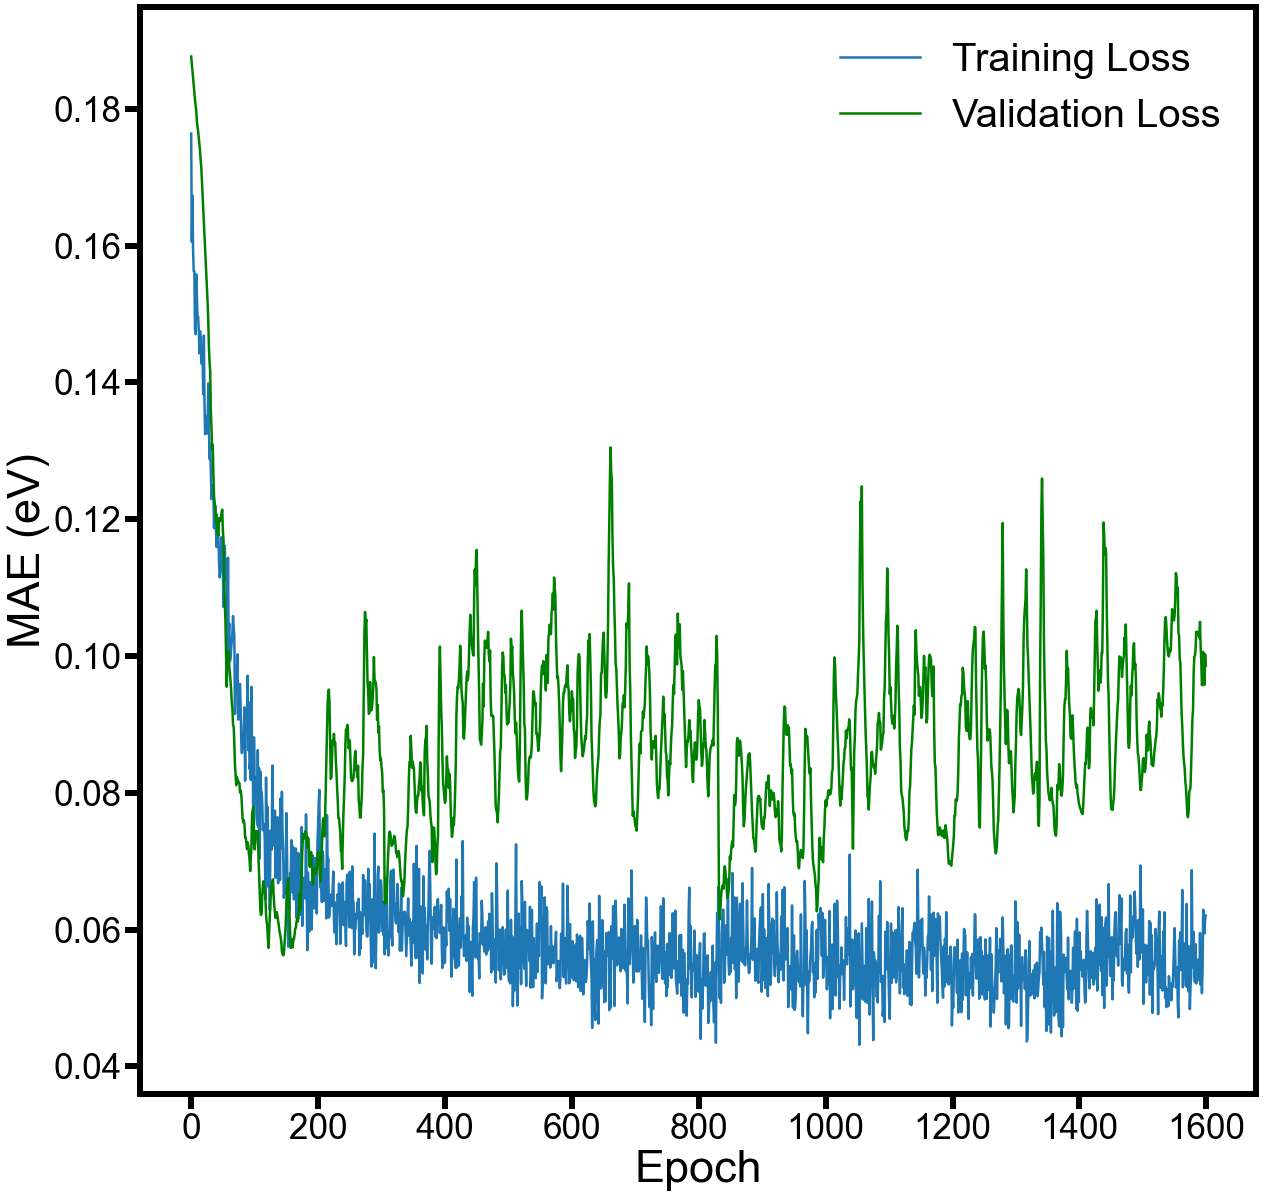

In [122]:
training_losses = model_history_mae.history['loss']
validation_losses = model_history_mae.history['val_loss']

fig, ax = plt.subplots()
plt.plot(training_losses, label="Training Loss", linewidth = 2.5)
plt.plot(validation_losses, label="Validation Loss", linewidth = 2.5, c='g')
#plt.title('Learning Curve', fontsize = 20)
ax.set_xlabel('Epoch', fontsize = 45)
ax.set_ylabel('MAE (eV)', fontsize = 45)

ax.tick_params(axis='x', colors='black', labelsize = 35, width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', labelsize = 35, width=6, length=15, color='black')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)

plt.savefig('{}dim_nn_mae.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.legend(frameon=False, fontsize = 40);

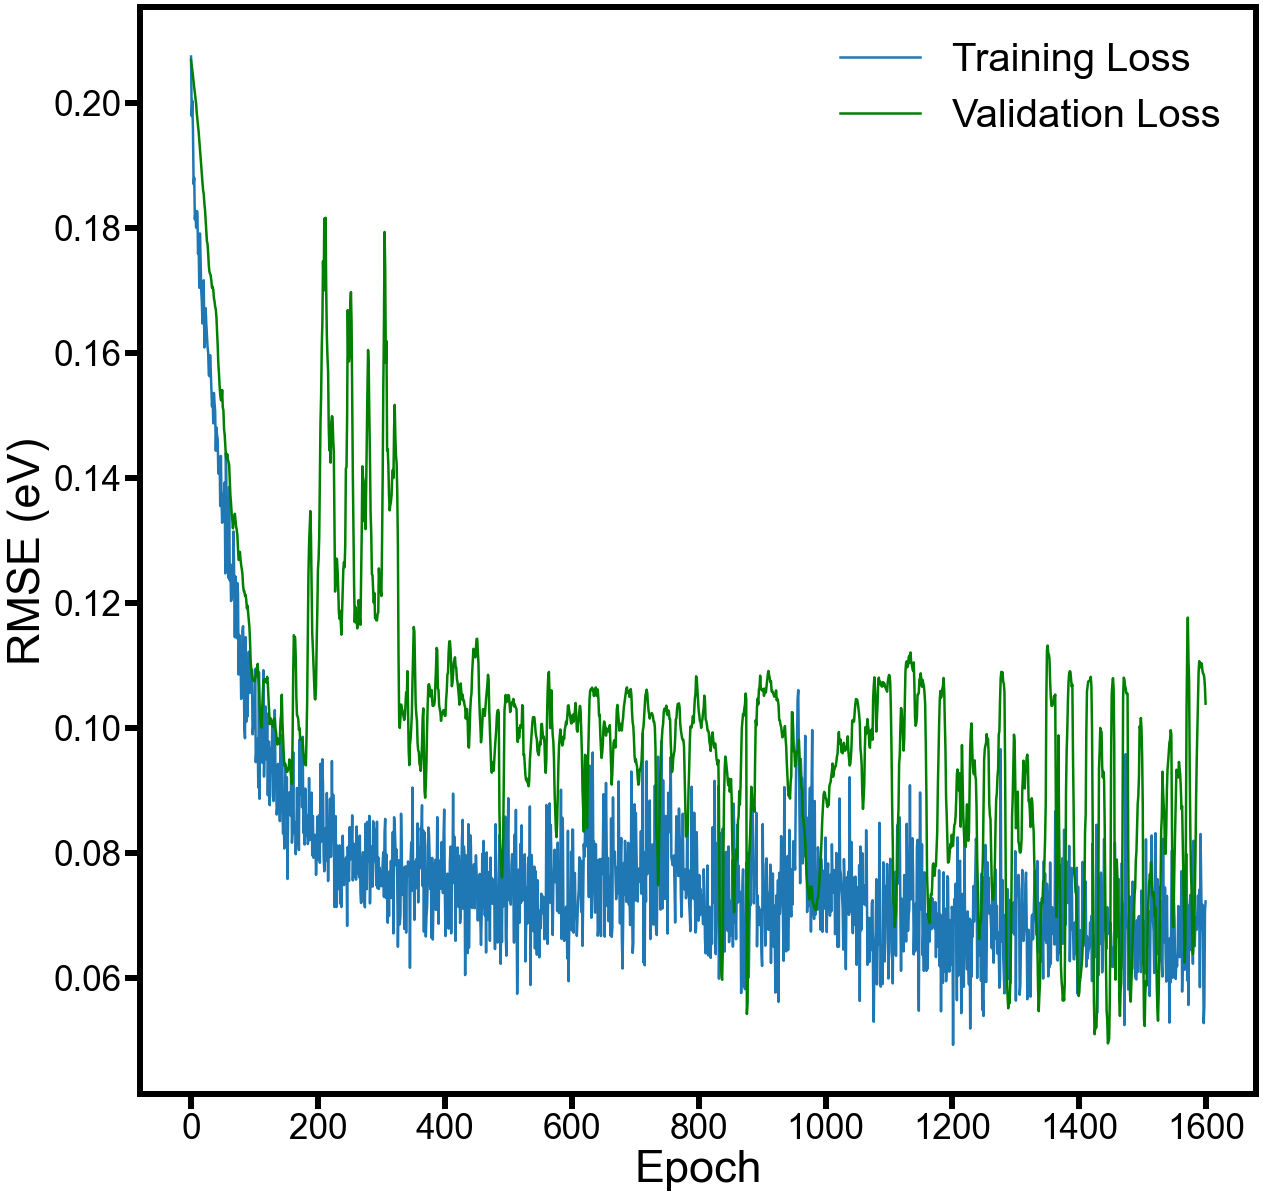

In [123]:
training_losses = model_history_rmse.history['loss']
validation_losses = model_history_rmse.history['val_loss']

fig, ax = plt.subplots()
plt.plot(training_losses, label="Training Loss", linewidth = 2.5)
plt.plot(validation_losses, label="Validation Loss", linewidth = 2.5, c='g')
#plt.title('Learning Curve', fontsize = 20)
ax.set_xlabel('Epoch', fontsize = 45)
ax.set_ylabel('RMSE (eV)', fontsize = 45)

ax.tick_params(axis='x', colors='black', labelsize = 35, width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', labelsize = 35, width=6, length=15, color='black')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)

plt.savefig('{}dim_nn_rmse.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.legend(frameon=False, fontsize = 40);

# 7. Regressor Performance Plots

In [124]:
# Train on models
GBR.fit(X_train, y_train)
KNR.fit(X_train, y_train)
RFR.fit(X_train, y_train)
SR.fit(X_train, y_train)
KRR.fit(X_train, y_train)
xgbr.fit(X_train, y_train)
#xgbr_optimized.fit(X_train, y_train)
light.fit(X_train, y_train)
nn = load_model('model_best_weights.h5', num_cols = len(features.columns))

In [125]:
def trendline_dimerization(xd, yd, i, name, rmse, ax, order=1, c='k', alpha=1, Rval=False):
    """Make a line of best fit"""

    # Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    # Plot trendline
    if i <= 3:
        ax[0, i].plot(xl, yl, c, alpha=alpha, linestyle='--', linewidth=0.8)

    if i > 3:
        ax[1, i - 4].plot(xl, yl, c, alpha=alpha, linestyle='--', linewidth=0.8)

    # Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        # Plot R^2 value
        if i <= 3:
            ax[0, i].text(0.12, 0.01, name, fontsize=18)
            ax[0, i].text(0.12, -0.06, '$MAE = %0.3f$ eV' % mae, fontsize=18)
            ax[0, i].text(0.12, -0.025, '$RMSE = %0.3f$ eV' % rmse, fontsize=18)
            ax[0, i].text(0.12, -0.095, '$R^2 = %0.3f$' % Rsqr, fontsize=18)
        if i > 3:
            ax[1, i - 4].text(0.12, 0.01, name, fontsize=18)
            ax[1, i - 4].text(0.12, -0.06, '$MAE = %0.3f$ eV' % mae, fontsize=18)
            ax[1, i - 4].text(0.12, -0.025, '$RMSE = %0.3f$ eV' % rmse, fontsize=18)
            ax[1, i - 4].text(0.12, -0.095, '$R^2 = %0.3f$' % Rsqr, fontsize=18)
    else:
        # Return the R^2 value:
        return Rsqr


def plot_data_dimerization(train_data, test_data, i, name, rmse, mae, ax):
    if i <= 3:
        # Plot data
        ax[0, i].scatter(train_data['G_co (eV)'], train_data['prediction'], label="Training Set",
                         alpha=1, marker='o', s=35, facecolor='none', color='#1f77b4')

        ax[0, i].scatter(test_data['G_co (eV)'], test_data['prediction'], label='Validation Set',
                         alpha=1, marker='s', s=35, facecolor='none', color='#ff7f0e')
        ax[0, i].tick_params(axis='y', labelcolor='black', labelsize=25, width=2, length=6, color='black',
                             which='major')
        ax[0, i].tick_params(axis='x', labelcolor='black', labelsize=25, width=2, length=6, color='black',
                             which='major')

        for axis in ['top', 'bottom', 'left', 'right']:
            ax[0, i].spines[axis].set_linewidth(2)

        ax[0, i].set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
        ax[0, i].set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])

        # Combine data for best fit line
        x = pd.concat([train_data['G_co (eV)'], test_data['G_co (eV)']])
        y = pd.concat([train_data['prediction'], test_data['prediction']])

        # plot best fit line
        trendline_dimerization(x, y, i, name, rmse, ax)

        # plot legend/axis
        ax[0, i].legend(loc='upper left', fontsize=18, frameon=False)

    if i > 3:
        # Plot data
        ax[1, i - 4].scatter(train_data['G_co (eV)'], train_data['prediction'], label="Training Set",
                             alpha=1, marker='o', s=35, facecolor='none', color='#1f77b4')
        ax[1, i - 4].scatter(test_data['G_co (eV)'], test_data['prediction'], label='Validation Set',
                             alpha=1, marker='s', s=35, facecolor='none', color='#ff7f0e')
        ax[1, i - 4].tick_params(axis='y', labelcolor='black', labelsize=25, width=2, length=6, color='black',
                                 which='major')
        ax[1, i - 4].tick_params(axis='x', labelcolor='black', labelsize=25, width=2, length=6, color='black',
                                 which='major')

        for axis in ['top', 'bottom', 'left', 'right']:
            ax[1, i - 4].spines[axis].set_linewidth(2)

        ax[1, i - 4].set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
        ax[1, i - 4].set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])

        # Combine data to create best fit line
        x = pd.concat([train_data['G_co (eV)'], test_data['G_co (eV)']])
        y = pd.concat([train_data['prediction'], test_data['prediction']])

        # Plot best fit line
        trendline_dimerization(x, y, i, name, rmse, ax)

        # Plot legend/axis
        ax[1, i - 4].legend(loc='upper left', fontsize=18, frameon=False)

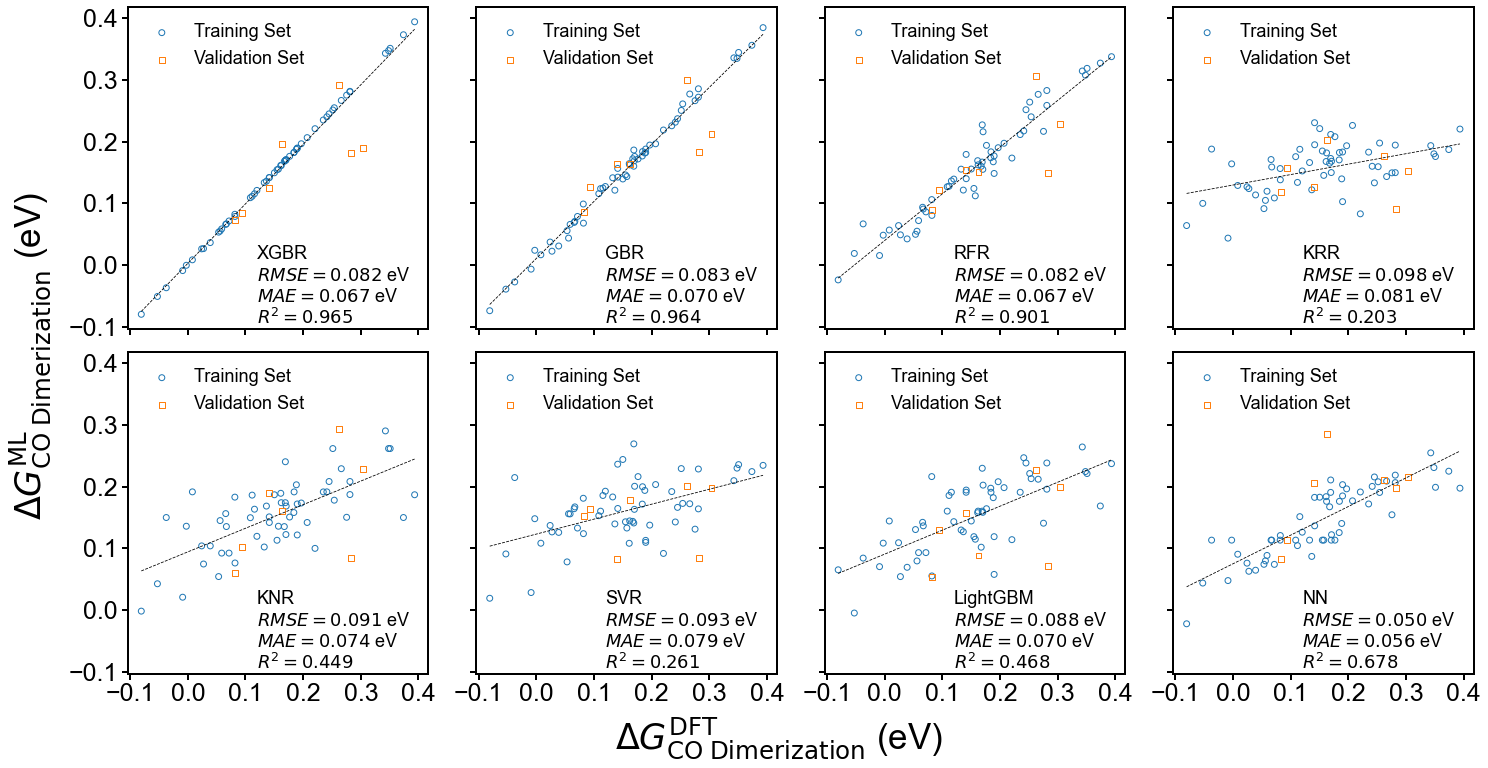

In [126]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex = True, sharey = True, figsize = (20, 10))

regressors = [xgbr, GBR, RFR, KRR, KNR, SR, light, nn]

names = {
    
    GBR: 'GBR',
    KNR: 'KNR',
    RFR: 'RFR',
    SR: 'SVR',
    light: 'LightGBM',
    xgbr: 'XGBR',
    KRR: 'KRR',
    nn: 'NN'
    
}

RMSE = {
    
    GBR: results_df['GBR'][9][1],
    KNR: results_df['KNR'][9][1],
    RFR: results_df['RFR'][9][1],
    SR: results_df['SVR'][9][1],
    light: results_df['LightGBM'][9][1],
    xgbr: results_df['XGBR'][9][1],
    KRR: results_df['KRR'][9][1],
    nn: nn_RMSE
    
}

MAE = {
    
    GBR: results_df['GBR'][9][0],
    KNR: results_df['KNR'][9][0],
    RFR: results_df['RFR'][9][0],
    SR: results_df['SVR'][9][0],
    light: results_df['LightGBM'][9][0],
    xgbr: results_df['XGBR'][9][0],
    KRR: results_df['KRR'][9][0],
    nn: nn_MAE
    
}

# Make Gco predictions on training and testing data using each regressor
for i, reg in enumerate(regressors):
    
    name = names[reg]
    rmse = RMSE[reg]
    mae = MAE[reg]
    
    
    # Predicting training data
    train_data = X_train.copy()
    train_data['G_co (eV)'] = y_train.copy()
    train_data['prediction'] = reg.predict(train_data.iloc[:, :-1])    
    
    # Predicting testing data
    test_data = X_test.copy()
    test_data['G_co (eV)'] = y_test.copy()
    test_data['prediction'] = reg.predict(test_data.iloc[:, :-1])    
    
    # Plotting the performance of each regressor
    plot_data_dimerization(train_data, test_data, i, name, rmse, mae, ax)

fig.text(0.5, -0.03, r'$\Delta G_{\mathrm{CO\;Dimerization}}^{\mathrm{DFT}}$ (eV)', ha='center', va='center', fontsize = 35)
fig.text(-0.02, 0.5, r'$\Delta G_{\mathrm{CO\;Dimerization}}^{\mathrm{ML}}$ (eV)', ha='center', va='center', rotation='vertical', fontsize = 35)
fig.tight_layout(pad = 1)

plt.savefig('{}dim_model_performances.png'.format(image_directory),dpi=600, bbox_inches = "tight")

## Full XGBR CV Errors

In [127]:
rmse_grid = -cross_val_score(xgbr, features, target, cv=RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 42), scoring='neg_mean_absolute_error')

In [128]:
rmse_grid = rmse_grid.tolist()
rmse_grid = np.array(['%.3f' % elem for elem in rmse_grid]).astype('float')
rmse_grid = transform_2D(rmse_grid, 11)

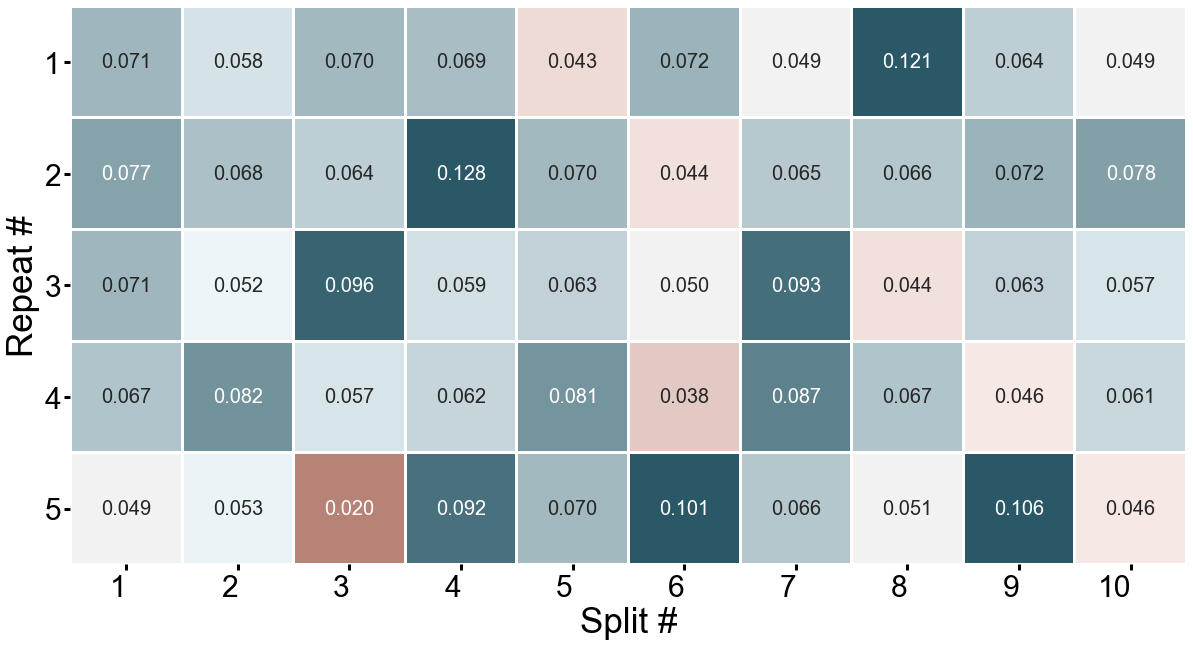

In [130]:
# Plotting all CV errors
ax = sns.heatmap(rmse_grid, linewidth=2,
                 cmap = sns.diverging_palette(20, 220, l=35, n=220), square = True, vmin = 0, vmax = 0.1,
                 cbar=False, annot=True, fmt='.3f', annot_kws={"fontsize":20})
plt.xticks(ha='right')

x_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


ax.set_xticklabels(x_labels, rotation = 0, size = 30)
ax.set_yticklabels(y_labels, rotation = 0, size = 30)

ax.tick_params(axis='x', labelcolor='black', labelsize = 30, width=3, length=6, color='black') 
ax.tick_params(axis='y', labelcolor='black', labelsize = 30, width=3, length=6, color='black') 


ax.set_xlabel('Split #', size = 35)
ax.set_ylabel('Repeat #', color='black', size = 35)

plt.savefig('{}dim_cv_splits.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show()

# 8. XGBR Prediction on Full Dataset

In [133]:
# Import full data
prediction_df = pd.read_csv('CO Dimerization Full Data.csv')

In [134]:
adsorbates = prediction_df[['Adsorbate 1', 'Adsorbate 2']]

In [135]:
# Savings the Gco column
targets = prediction_df['G_C2O2 - Gco']

In [136]:
# Removing all columns that were deleted in feature selection to maintain the same prediction features as training
prediction_df = prediction_df.drop(prediction_df.columns.difference(test_data.columns), 1)

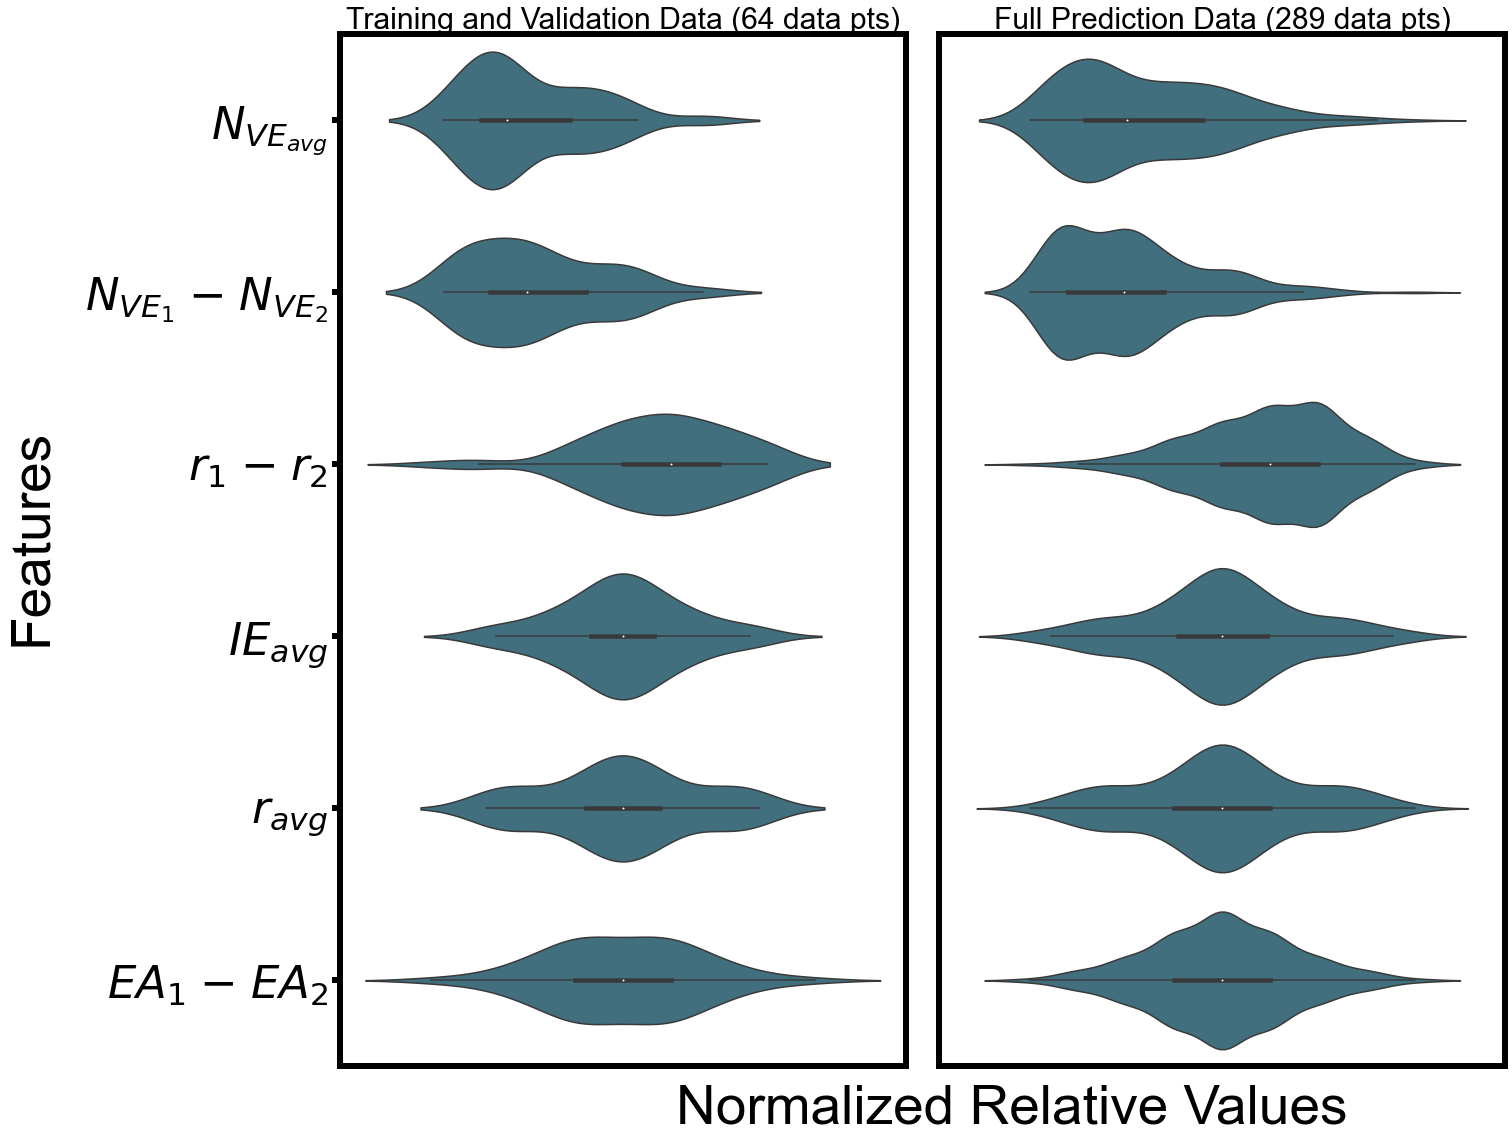

In [137]:
# Plot of the statistical distibution between training dataset and full dataset
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True, sharex = True, figsize = (20, 15))

# minmax scaling training data
training_df = scaler(df_v9.copy(), 'CO Dimerization Full Data.csv', 'G_C2O2 - Gco')
training_df = training_df.iloc[:, :-1].melt(var_name='Features', value_name='Values')

# minmax scaling full data
full_df = scaler(prediction_df.copy(), 'CO Dimerization Full Data.csv', 'G_C2O2 - Gco')
full_df = full_df.melt(var_name='Features', value_name='Values')

sns.violinplot(x = 'Values', y = 'Features', data = training_df, ax=ax[0], color="#377488").set(xticklabels=[], title='Training and Validation Data (64 data pts)')
sns.violinplot(x = 'Values', y = 'Features', data = full_df, ax=ax[1], color="#377488").set(xticklabels=[], title='Full Prediction Data (289 data pts)')

ax[0].set_ylabel('')    
ax[0].set_xlabel('')
ax[1].set_ylabel('')    
ax[1].set_xlabel('')


ax[0].tick_params(axis='y', labelcolor='black', labelsize = 45, which='both', width=6, length=8)
ax[0].tick_params(axis='x', width=0, length=0)
ax[1].tick_params(width=0, length=0)
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(6)
    ax[1].spines[axis].set_linewidth(6)

ax[0].set_yticklabels(corr_labels)
    
ax[0].set_title('Training and Validation Data (64 data pts)', fontsize=30)    
ax[1].set_title('Full Prediction Data (289 data pts)', fontsize=30)

plt.xticks(fontsize=40)

fig.text(0.65, -0.03, 'Normalized Relative Values', ha='center', va='center', fontsize = 55)
fig.text(-0.03, 0.5, 'Features', ha='center', va='center', rotation='vertical', fontsize = 55)
fig.tight_layout(pad = 1)

plt.savefig('{}dim_violin.png'.format(image_directory),dpi=600, bbox_inches = "tight")

In [138]:
# Adding the Gco column back
prediction_df['G_C2O2 - Gco'] = targets

In [140]:
# Full dataset prediction
import time

start = time.time()
ml_predict(prediction_df, 'G_C2O2 - Gco' ,xgbr, 'Gc-c_ML', 'Gc-c_Final')
end = time.time()
total = end-start

In [143]:
# obtain the relative RMSE of the full dataset based on training set (not strictly accurate)
b = np.sqrt(((prediction_df['G_C2O2 - Gco'] - prediction_df['Gc-c_ML'])**2).mean()).round(4)
print('Training RMSE: {}'.format(results_df['XGBR'][9][1].round(4)))
print('Testing RMSE: {}'.format(b))

Training RMSE: 0.0815
Testing RMSE: 0.058


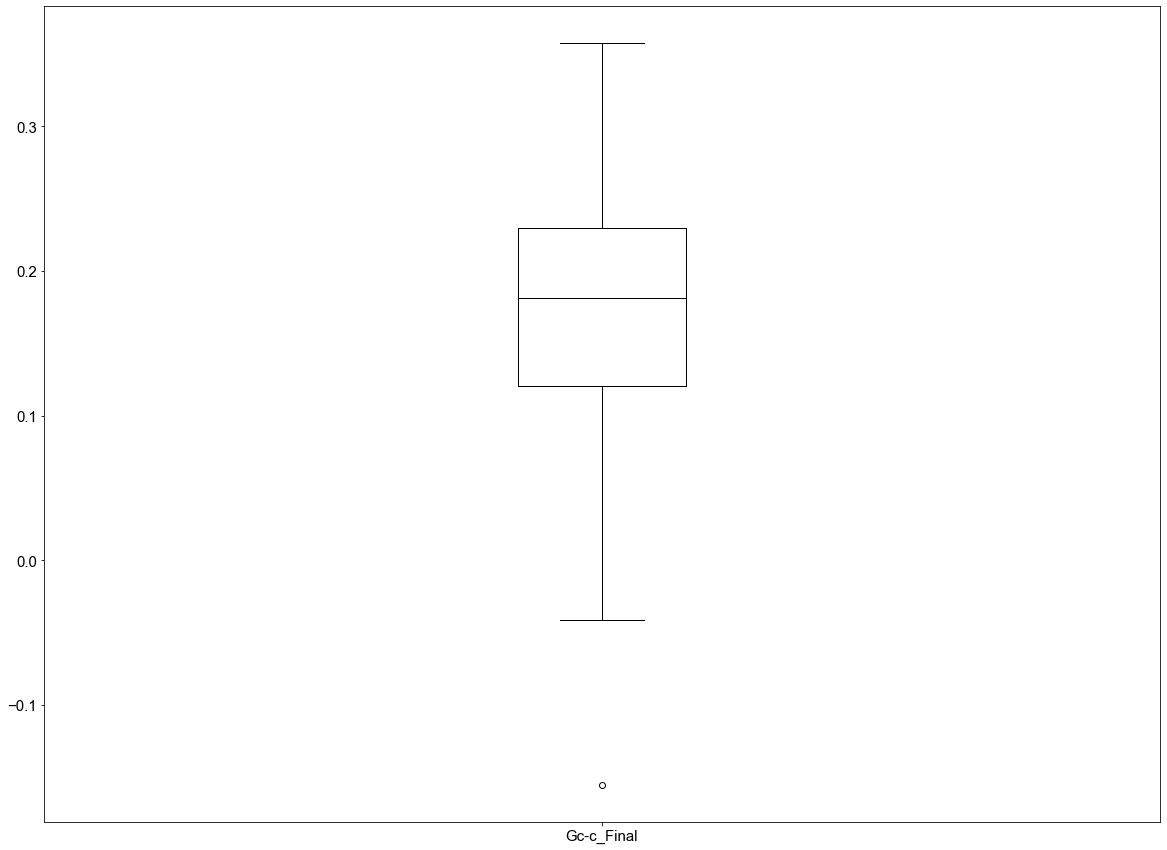

In [145]:
prediction_df.boxplot(color=dict(boxes='black', whiskers='black', medians='black', caps='black'), 
                      column='Gc-c_Final', grid=False, figsize=(20, 15));

In [146]:
# Add adsorbate names back to df
final_df = adsorbates.join(prediction_df, how = 'left')

In [147]:
# Double check no errors in df
final_df

,Adsorbate 1,Adsorbate 2,Average Covalent Radius,Average IE,Average num of Valence Electron,Covalent Radius 1 minus Covalent Radius 2,EA 1 minus EA 2,num of Valence 1 minus num of Valence 2,G_C2O2 - Gco,Gc-c_ML,Gc-c_Final
0,O,O,0.63,13.62,6.0,0.00,0.00,0,0.03073,0.135930,0.030730
1,O,OH,0.56,13.32,6.5,0.15,0.35,-1,0.15131,0.111519,0.151310
2,O,N,0.67,14.08,5.5,-0.08,1.53,1,NaN,0.080537,0.080537
3,O,NH,0.58,13.21,6.0,0.11,1.12,0,NaN,0.053870,0.053870
4,O,NH2,0.54,12.20,6.5,0.18,0.98,-1,NaN,0.077731,0.077731
...,...,...,...,...,...,...,...,...,...,...,...
284,I,SH2,0.95,10.46,7.5,0.77,1.86,-1,NaN,0.221270,0.221270
285,I,F,0.99,13.94,7.0,0.69,-0.34,0,NaN,0.306168,0.306168
286,I,Cl,1.16,11.71,7.0,0.34,-0.55,0,NaN,0.357323,0.357323
287,I,Br,1.24,11.13,7.0,0.19,-0.30,0,NaN,0.288063,0.288063


In [148]:
# Save the predicted dataframe
final_df.to_csv('predicted_Gc-c_xgbr.csv')

# 9. Full Data Heat Map

In [149]:
# Due to the variability of ML predictions, we repeated the prediction 5 times and took the average Gc-c as result
five_times = pd.read_csv('dim_five_times.csv')

In [150]:
five_times

,Adsorbate 1,Adsorbate 2,Gco DFT,Gc-c_Final,Gc-c_Final.1,Gc-c_Final.2,Gc-c_Final.3,Gc-c_Final.4,Averaged Gco
0,O,O,0.03073,0.030730,0.030730,0.030730,0.030730,0.030730,0.030730
1,O,OH,0.15131,0.151310,0.151310,0.151310,0.151310,0.151310,0.151310
2,O,N,NaN,0.095938,0.049531,0.080537,0.128133,0.071945,0.085217
3,O,NH,NaN,-0.019133,0.013329,0.053870,0.000173,0.050779,0.019804
4,O,NH2,NaN,0.148904,0.150668,0.077731,0.170350,0.151449,0.139821
...,...,...,...,...,...,...,...,...,...
284,I,SH2,NaN,0.262081,0.242230,0.221270,0.236264,0.229923,0.238354
285,I,F,NaN,0.316360,0.298598,0.306168,0.347352,0.334894,0.320674
286,I,Cl,NaN,0.361769,0.371757,0.357323,0.364660,0.354339,0.361970
287,I,Br,NaN,0.239019,0.264102,0.288063,0.296487,0.313405,0.280215


In [151]:
# Define the adsorbate names and all dimerization energies
adsorbates = ['O', 'OH', 'N', 'NH', 'NH$_2$', 'NH$_{3}$', 'C', 'CH', 'CH$_2$', 'CH$_3$', 'S',
 'SH', 'SH$_2$', 'F', 'Cl', 'Br', 'I']
dim_energy = five_times['Averaged Gco']
dim_energy_min_cu = five_times['Averaged Gco']

In [152]:
dim_energy.describe()

count    289.000000
mean       0.176200
std        0.084605
min       -0.155088
25%        0.119809
50%        0.177441
75%        0.231483
max        0.361970
Name: Averaged Gco, dtype: float64

In [153]:
# Transform series into a 2D array
twoD = transform_2D(dim_energy_min_cu, 18)

In [154]:
twoD = np.array(twoD)

In [156]:
# count the number of combinations that exhibit catalytic performance greater than pristine Cu
final = (twoD + twoD.T) / 2 - 0.184
mask = np.tril(np.ones_like(final, dtype=bool))

count = 0
for i in range(0, 17):
    for j in range(0, 17):
        if (final[i, j] < 0) and (mask[i,j]):
            count +=1
            

In [157]:
count

81

In [158]:
final_dim = final + 0.184

In [159]:
result = []
for i in range(len(final_dim)):
    for j in range(len(final_dim[i])):
        result.append(final_dim[i, j])

In [160]:
result = np.array(result)

In [161]:
final_df['Gc-c_Final'] = result

In [162]:
final_df

,Adsorbate 1,Adsorbate 2,Average Covalent Radius,Average IE,Average num of Valence Electron,Covalent Radius 1 minus Covalent Radius 2,EA 1 minus EA 2,num of Valence 1 minus num of Valence 2,G_C2O2 - Gco,Gc-c_ML,Gc-c_Final
0,O,O,0.63,13.62,6.0,0.00,0.00,0,0.03073,0.135930,0.030730
1,O,OH,0.56,13.32,6.5,0.15,0.35,-1,0.15131,0.111519,0.151310
2,O,N,0.67,14.08,5.5,-0.08,1.53,1,NaN,0.080537,0.088160
3,O,NH,0.58,13.21,6.0,0.11,1.12,0,NaN,0.053870,0.032986
4,O,NH2,0.54,12.20,6.5,0.18,0.98,-1,NaN,0.077731,0.151224
...,...,...,...,...,...,...,...,...,...,...,...
284,I,SH2,0.95,10.46,7.5,0.77,1.86,-1,NaN,0.221270,0.250180
285,I,F,0.99,13.94,7.0,0.69,-0.34,0,NaN,0.306168,0.322836
286,I,Cl,1.16,11.71,7.0,0.34,-0.55,0,NaN,0.357323,0.353047
287,I,Br,1.24,11.13,7.0,0.19,-0.30,0,NaN,0.288063,0.271246


In [163]:
final_df.to_csv('predicted_Gc-c_xgbr_avg.csv')

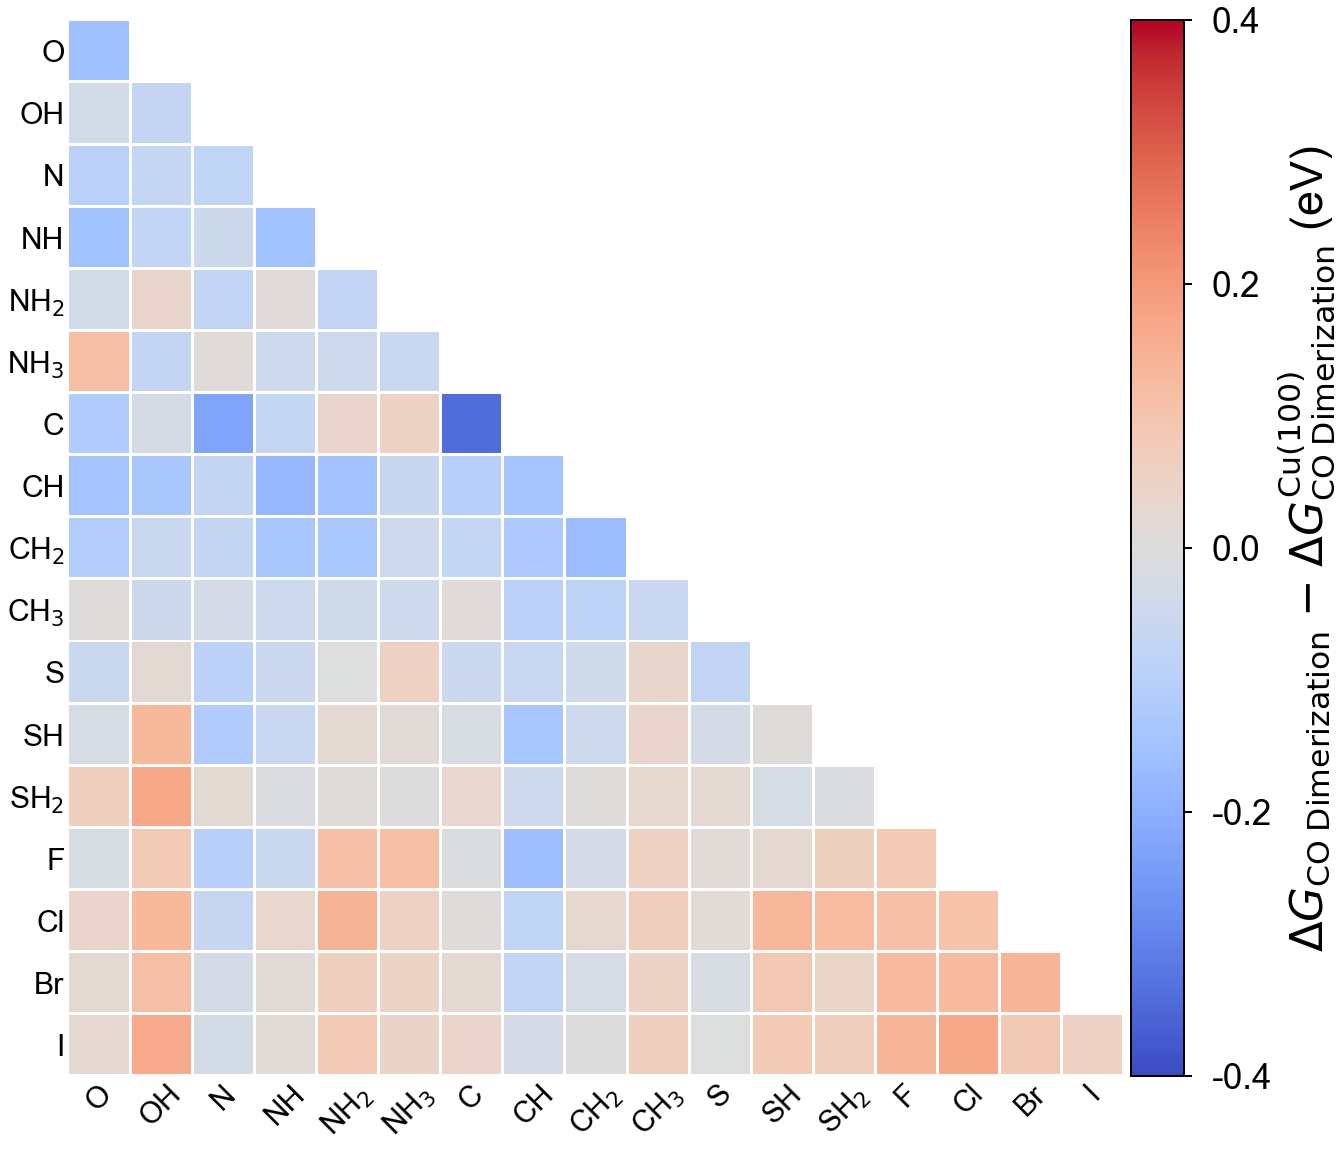

In [164]:
# Plot final result heatmap
import matplotlib

cmap1 = matplotlib.colors.ListedColormap(['g'])
mask = np.tril(np.ones_like(final, dtype=bool))

ax = sns.heatmap(final, linewidth=2, mask = 1 - mask,
                 cmap = "coolwarm", square = True, cbar = False, vmin=-0.4, vmax=0.4)
ax.figure.axes[-1].yaxis.label.set_size(30)

#ax = sns.heatmap(twoD, linewidth=2, mask = np.array(twoD) < 0.3, cmap = cmap1, square = True, cbar=False)

ax.set_xticklabels(adsorbates, rotation = 45, size = 30)
ax.set_yticklabels(adsorbates, rotation = 0, size = 30)

ax.tick_params(axis='x', colors='black', width=0, length=0, color='black')
ax.tick_params(axis='y', colors='black', width=0, length=0, color='black') 

divider = make_axes_locatable(ax) 
cax = divider.append_axes("right", size="5%", pad=0.1) 
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.set_ticks([-0.4, -0.2, 0.0, 0.2, 0.4])
cbar.ax.set_yticklabels(['-0.4', '-0.2',  '0.0', '0.2', '0.4'], size=35)
cbar.ax.set_ylabel('$\Delta G_{\mathrm{CO \; Dimerization}}$ $-$ $\Delta G_{\mathrm{CO \; Dimerization}}^{\mathrm{Cu(100)}}$ (eV)', fontsize = 45)
cbar.ax.tick_params(axis='y', which='major', length=8, width = 2, pad=20)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)

plt.savefig('{}dim_heatmap.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show()

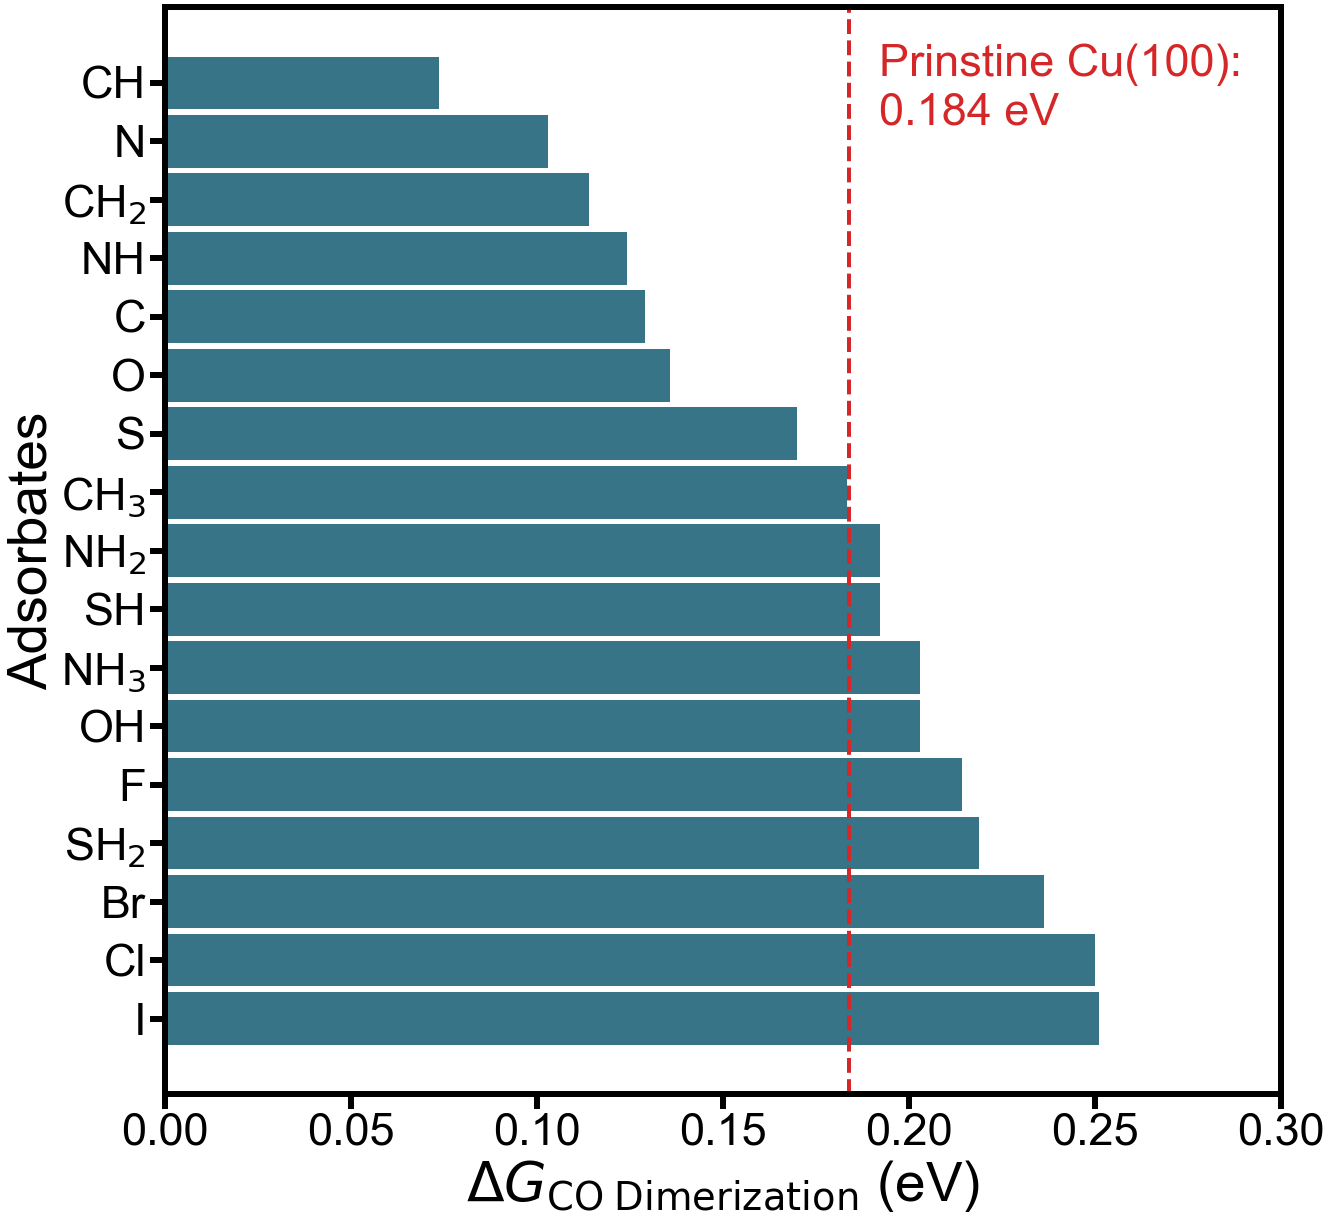

In [165]:
#Calculate the average CO dimerization of each adsorbate

dim_avg = calc_average(dim_energy, 18)

col = zip(adsorbates, dim_avg)

# sort and save features based on its importance into a dataframe
difference = pd.DataFrame(col, columns=['adsorbates', 'difference'])
difference_data_asc = difference.sort_values('difference', ascending=False)

# plot the importance data
fig, ax = plt.subplots()
plt.barh(y=difference_data_asc['adsorbates'], width=difference_data_asc['difference'], height=0.9, color='#377488')
ax.set_yticklabels(difference_data_asc['adsorbates'])

ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)

ax.tick_params(axis='x', colors='black', width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', width=6, length=15, color='black')    

ax.set_xlabel("$\Delta G_{\mathrm{CO \; Dimerization}}$ (eV)", fontsize = 55)
ax.set_ylabel('Adsorbates', fontsize = 55)

ax.tick_params(axis='x', colors='black', labelsize = 45, width=6, length=15, color='black')
ax.tick_params(axis='y', colors='black', labelsize = 45, width=6, length=15, color='black')

plt.axvline(x=0.1840105, color='tab:red', linewidth = 4, linestyle = '--')
plt.text(0.192, 15.9, 'Prinstine Cu(100): \n0.184 eV', ha='left', va='center', fontsize = 45, color='tab:red')

plt.savefig('{}dim_avg_ads.png'.format(image_directory),dpi=600, bbox_inches = "tight")
plt.show();

In [166]:
# numerical representation of adsorbate averages
difference_data_asc

,adsorbates,difference
16,I,0.251159
14,Cl,0.250129
15,Br,0.236287
12,SH$_2$,0.218845
13,F,0.214401
1,OH,0.203152
5,NH$_{3}$,0.203101
11,SH,0.192364
4,NH$_2$,0.192302
9,CH$_3$,0.183352
